# Część 1

### Trzeba odpalić

In [3]:
def evaluate_model(y_true, y_pred_proba, model_name="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    ks_statistic = max(tpr - fpr)
    
    logloss = log_loss(y_true, y_pred_proba)
    
    brier = brier_score_loss(y_true, y_pred_proba)
    
    results = {
        'Model': model_name,
        'AUC-ROC': roc_auc,
        'PR-AUC': pr_auc,
        'KS Statistic': ks_statistic,
        'Log Loss': logloss,
        'Brier Score': brier
    }
    
    return results

def print_evaluation(results):
    print("=" * 70)
    print(f"WYNIKI EWALUACJI: {results['Model']}")
    print("=" * 70)
    print(f"AUC-ROC:       {results['AUC-ROC']:.4f}")
    print(f"PR-AUC:        {results['PR-AUC']:.4f}")
    print(f"KS Statistic:  {results['KS Statistic']:.4f}")
    print(f"Log Loss:      {results['Log Loss']:.4f}")
    print(f"Brier Score:   {results['Brier Score']:.4f}")
    print("=" * 70)

def evaluate_model(y_true, y_pred_proba, model_name="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    ks_statistic = max(tpr - fpr)
    
    logloss = log_loss(y_true, y_pred_proba)
    
    brier = brier_score_loss(y_true, y_pred_proba)
    
    results = {
        'Model': model_name,
        'AUC-ROC': roc_auc,
        'PR-AUC': pr_auc,
        'KS Statistic': ks_statistic,
        'Log Loss': logloss,
        'Brier Score': brier
    }
    
    return results

def print_evaluation(results):
    print("=" * 70)
    print(f"WYNIKI EWALUACJI: {results['Model']}")
    print("=" * 70)
    print(f"AUC-ROC:       {results['AUC-ROC']:.4f}")
    print(f"PR-AUC:        {results['PR-AUC']:.4f}")
    print(f"KS Statistic:  {results['KS Statistic']:.4f}")
    print(f"Log Loss:      {results['Log Loss']:.4f}")
    print(f"Brier Score:   {results['Brier Score']:.4f}")
    print("=" * 70)


In [4]:
# Standardowe biblioteki i ustawienia
import os
import warnings
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from scipy.stats import beta as beta_dist
from scipy.special import expit, logit
from scipy.optimize import minimize
import scipy.stats.mstats as mstats # lub po prostu import scipy.mstats as mstats
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))

# Preprocessing i Inżynieria Cech (Feature Engineering)
from sklearn.experimental import enable_iterative_imputer # Wymagane dla IterativeImputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    PowerTransformer
)
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, RFE

# Wybór i Walidacja Modeli
from sklearn.model_selection import (
    TimeSeriesSplit,
    train_test_split
)

# Modele
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    IsolationForest
)
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
import shap
import lime.lime_tabular
from sklearn.metrics import auc, precision_recall_curve
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    log_loss,
    brier_score_loss,
    roc_curve,
    confusion_matrix
)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
from sklearn.inspection import PartialDependenceDisplay

# Statystyka i Wpływ
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import lime
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_auc_score


import optuna
from optuna.pruners import MedianPruner

### Reszta

In [3]:
df = pd.read_csv('zbior_10.csv')
target_col = 'default' 
X = df.drop(columns=[target_col])
y = df[target_col]

In [4]:
def full_feature_engineering(df):
    df_new = df.copy()

    def safe_div(a, b):
        return np.divide(a, b, out=np.zeros_like(a, dtype=float), where=b != 0)

    if 'pkdKod' in df_new.columns:
        temp_pkd = df_new['pkdKod'].fillna(0).astype(int).astype(str)
        df_new['PKD_Dzial'] = temp_pkd.str[:2].astype('category')

    zob_krotkie = df_new['Zobowiazania_krotkoterminowe'].fillna(0)
    zob_dlugie = df_new['Zobowiazania_dlugoterminowe'].fillna(0)
    zob_total = zob_krotkie + zob_dlugie
    aktywa = df_new['Aktywa']
    przychody = df_new['przychody']

    df_new['New_Current_Ratio'] = safe_div(df_new['Aktywa_obrotowe'], zob_krotkie)
    df_new['New_Cash_Ratio'] = safe_div(df_new['Srodki_pieniezne'], zob_krotkie)
    df_new['New_Debt_Ratio'] = safe_div(zob_total, aktywa)
    df_new['New_Equity_Multiplier'] = safe_div(aktywa, df_new['Kapital_wlasny'])

    df_new['New_ROA'] = safe_div(df_new['Zysk_netto'], aktywa)
    df_new['New_ROS'] = safe_div(df_new['Zysk_netto'], przychody)
    df_new['New_Op_Margin'] = safe_div(df_new['zysk_operacyjny'], przychody)
    df_new['New_Asset_Turnover'] = safe_div(przychody, aktywa)
    df_new['New_Receivables_Cycle'] = safe_div(df_new['Naleznosci_krotkoterminowe'], przychody)

    for col in ['Aktywa', 'przychody', 'zysk_brutto']:
        if col in df_new.columns:
            df_new[f'Log_{col}'] = np.log1p(df_new[col].clip(lower=0)).astype('float32')

    ebitda = df_new['zysk_operacyjny'].fillna(0) + df_new['amortyzacja'].fillna(0)
    df_new['Calc_EBITDA'] = ebitda
    df_new['Ratio_Interest_Coverage'] = safe_div(ebitda, df_new['koszty_odsetki'].fillna(0))

    net_debt = zob_total - df_new['Srodki_pieniezne'].fillna(0)
    df_new['Ratio_NetDebt_EBITDA'] = safe_div(net_debt, ebitda)
    df_new['Log_EBITDA'] = np.log1p(ebitda.clip(lower=0)).astype('float32')

    koszty_op = df_new['koszty_operacyjne']
    df_new['Cycle_Receivables'] = safe_div(df_new['Naleznosci_krotkoterminowe'], przychody)
    df_new['Cycle_Inventory'] = safe_div(df_new['Zapasy'], koszty_op)
    df_new['Cycle_Payables'] = safe_div(zob_krotkie, koszty_op)
    df_new['Cycle_Gap'] = df_new['Cycle_Payables'] - df_new['Cycle_Receivables']

    permanent_capital = df_new['Kapital_wlasny'].fillna(0) + zob_dlugie
    df_new['Rule_Golden'] = safe_div(permanent_capital, df_new['Aktywa_trwale'])
    df_new['Structure_Debt_LongTerm'] = safe_div(zob_dlugie, zob_total)

    rel_receivables = (df_new['Naleznosci_dostaw_uslug_12m_powiazane'].fillna(0) + 
                       df_new['Naleznosci_dostaw_uslug_pow12m_powiazane'].fillna(0))
    df_new['Risk_Related_Receivables'] = safe_div(rel_receivables, aktywa)

    rel_payables = (df_new['Zobowiazania_dostaw_uslug_12m_powiazane'].fillna(0) + 
                    df_new['Zobowiazania_dostaw_uslug_pow12m_powiazane'].fillna(0))
    df_new['Risk_Related_Payables'] = safe_div(rel_payables, zob_total)

    nwc = df_new['Aktywa_obrotowe'] - zob_krotkie
    df_new['Altman_T1_WorkingCapital'] = safe_div(nwc, aktywa)
    df_new['Structure_Retained_Earnings'] = safe_div(df_new['Kapital_zapasowy'].fillna(0), df_new['Kapital_wlasny'])

    trade_receivables = (df_new['Naleznosci_dostaw_uslug_12m'].fillna(0) + df_new['Naleznosci_dostaw_uslug_pow12m'].fillna(0))
    trade_payables = (df_new['Zobowiazania_dostaw_uslug_12m'].fillna(0) + df_new['Zobowiazania_dostaw_uslug_pow12m'].fillna(0))
    df_new['Ratio_Trade_Financing'] = safe_div(trade_payables, trade_receivables)

    df_new['Ratio_Overhead_Burden'] = safe_div(df_new['koszty_ogolnego_zarzadu'], przychody)
    df_new['Ratio_Effective_Tax'] = safe_div(df_new['podatek_dochodowy'], df_new['zysk_brutto'])
    df_new['Structure_Intangibles'] = safe_div(df_new['Wartosci_niematerialne_prawne'], aktywa)
    df_new['Ratio_FinCost_Coverage'] = safe_div(df_new['zysk_operacyjny'], df_new['koszty_finansowe'])
    
    df_new['Ratio_Legal_Proceedings'] = safe_div(
        df_new['Naleznosci_dostaw_uslug_pozostale_sadowe'].fillna(0), aktywa
    )

    total_receivables = df_new['Naleznosci_dlugoterminowe'].fillna(0) + df_new['Naleznosci_krotkoterminowe'].fillna(0)
    df_new['Structure_Receivables_Long'] = safe_div(df_new['Naleznosci_dlugoterminowe'].fillna(0), total_receivables)

    liquid_assets = df_new['Srodki_pieniezne'].fillna(0) + df_new['Naleznosci_krotkoterminowe'].fillna(0)
    df_new['Structure_Liquidity_Share'] = safe_div(liquid_assets, aktywa)

    related_party_vol = (df_new['Naleznosci_dostaw_uslug_12m_powiazane'].fillna(0) + 
                         df_new['Zobowiazania_dostaw_uslug_12m_powiazane'].fillna(0))
    df_new['Dependency_Related_Parties'] = safe_div(related_party_vol, aktywa)

    
    df_new['Flag_No_Revenue'] = (przychody <= 0).astype('int8')

    obj_cols = df_new.select_dtypes(include=['object']).columns
    df_new[obj_cols] = df_new[obj_cols].astype('category')

    float_cols = df_new.select_dtypes(include=['float64']).columns
    df_new[float_cols] = df_new[float_cols].astype('float32')

    return df_new

X_fin = full_feature_engineering(X)

In [5]:

X_train, X_temp, y_train, y_temp = train_test_split(
    X_fin, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)
print(f"{X_train.shape}")
print(f"{X_val.shape}")
print(f"{X_test.shape}")


(1800, 256)
(600, 256)
(600, 256)


In [6]:

def advanced_preprocessing(X_train, X_test, X_val, use_svd=True, vif_threshold=10.0):
    print("Rozpoczynam zaawansowane przetwarzanie danych...")
    
    X_train_proc = X_train.copy()
    X_test_proc = X_test.copy()
    X_val_proc = X_val.copy()

    numeric_cols = X_train_proc.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X_train_proc.select_dtypes(exclude=[np.number]).columns.tolist()

    for df in [X_train_proc, X_test_proc, X_val_proc]:
        df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)
    
    print(f"  Imputacja braków danych (IterativeImputer) dla {len(numeric_cols)} kolumn...")
    imputer = IterativeImputer(max_iter=10, random_state=42, initial_strategy='median')
    
    # Fit tylko na Train
    X_train_proc[numeric_cols] = imputer.fit_transform(X_train_proc[numeric_cols])
    X_test_proc[numeric_cols] = imputer.transform(X_test_proc[numeric_cols])
    X_val_proc[numeric_cols] = imputer.transform(X_val_proc[numeric_cols])

    print("  Winsoryzacja i transformacja Yeo-Johnson...")
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    
    # Winsoryzacja
    for col in numeric_cols:
        q_low = X_train_proc[col].quantile(0.01)
        q_high = X_train_proc[col].quantile(0.99)
        if q_high > q_low:
            X_train_proc[col] = np.clip(X_train_proc[col], q_low, q_high)
            X_test_proc[col] = np.clip(X_test_proc[col], q_low, q_high)
            X_val_proc[col] = np.clip(X_val_proc[col], q_low, q_high)

    X_train_proc[numeric_cols] = pt.fit_transform(X_train_proc[numeric_cols])
    X_test_proc[numeric_cols] = pt.transform(X_test_proc[numeric_cols])
    X_val_proc[numeric_cols] = pt.transform(X_val_proc[numeric_cols])


    iso = IsolationForest(n_estimators=100, contamination=0.05, random_state=42, n_jobs=-1)
    iso.fit(X_train_proc[numeric_cols])
    
    X_train_proc['Anomaly_Score'] = iso.decision_function(X_train_proc[numeric_cols])
    X_test_proc['Anomaly_Score'] = iso.decision_function(X_test_proc[numeric_cols])
    X_val_proc['Anomaly_Score'] = iso.decision_function(X_val_proc[numeric_cols])
    
    pca_lev = PCA(n_components=10)
    pca_lev.fit(X_train_proc[numeric_cols])
    
    def get_leverage_proxy(data, pca_model):
        X_pca = pca_model.transform(data)
        return np.sum(X_pca**2, axis=1)

    X_train_proc['Leverage_Proxy'] = get_leverage_proxy(X_train_proc[numeric_cols], pca_lev)
    X_test_proc['Leverage_Proxy'] = get_leverage_proxy(X_test_proc[numeric_cols], pca_lev)
    X_val_proc['Leverage_Proxy'] = get_leverage_proxy(X_val_proc[numeric_cols], pca_lev)
    
    numeric_cols.extend(['Anomaly_Score', 'Leverage_Proxy'])
    print(f"  Analiza VIF (próg={vif_threshold})...")
    
    # # Sekcja VIF - zakomentowana ponieważ potem robimy szybsze RFE
    # cols_to_keep = numeric_cols.copy()
    # X_vif_sample = X_train_proc[cols_to_keep].sample(min(5000, len(X_train_proc)), random_state=42)
    # X_vif_sample = sm.add_constant(X_vif_sample)
    
    # drop_vif = True
    # while drop_vif and len(cols_to_keep) > 5:
    #     vifs = pd.Series(
    #         [variance_inflation_factor(X_vif_sample[cols_to_keep].values, i) 
    #          for i in range(len(cols_to_keep))],
    #         index=cols_to_keep
    #     )
    #     max_vif = vifs.max()
    #     if max_vif > vif_threshold:
    #         feature_to_drop = vifs.idxmax()
    #         print(f"    Usuwanie zmiennej z VIF={max_vif:.2f}: {feature_to_drop}")
    #         cols_to_keep.remove(feature_to_drop)
    #         X_vif_sample = X_vif_sample.drop(columns=[feature_to_drop])
    #     else:
    #         drop_vif = False
            
    # print(f"  Pozostawiono {len(cols_to_keep)} zmiennych numerycznych po selekcji VIF.")
    # final_cols = cols_to_keep + cat_cols
    final_cols = numeric_cols + cat_cols

    X_train_final = X_train_proc[final_cols].copy()
    X_test_final = X_test_proc[final_cols].copy()
    X_val_final = X_val_proc[final_cols].copy()

    if use_svd:
        print("  Dodawanie cech latentnych (SVD/PCA) - Wykład I...")
        pca = PCA(n_components=3)
        X_pca_train = pca.fit_transform(X_train_proc[numeric_cols])
        X_pca_test = pca.transform(X_test_proc[numeric_cols])
        X_pca_val = pca.transform(X_val_proc[numeric_cols])
        
        for i in range(3):
            col_name = f'Latent_SVD_Component_{i+1}'
            X_train_final[col_name] = X_pca_train[:, i]
            X_test_final[col_name] = X_pca_test[:, i]
            X_val_final[col_name] = X_pca_val[:, i]

    return X_train_final, X_test_final, X_val_final
X_train_final, X_test_final, X_val_final = advanced_preprocessing(X_train, X_test, X_val)

Rozpoczynam zaawansowane przetwarzanie danych...
  Imputacja braków danych (IterativeImputer) dla 253 kolumn...
  Winsoryzacja i transformacja Yeo-Johnson...
  Analiza VIF (próg=10.0)...
  Dodawanie cech latentnych (SVD/PCA) - Wykład I...


In [7]:
print(f"Finalny kształt X_train: {X_train_final.shape}")
print(f"Finalne kolumny: {X_train_final.columns.tolist()}")

Finalny kształt X_train: (1800, 261)
Finalne kolumny: ['szczegolnaFormaPrawna_Symbol', 'formaWlasnosci_Symbol', 'pkdKod', 'wsk_liczba_dni_istnienia', 'Aktywa', 'Aktywa_trwale', 'Wartosci_niematerialne_prawne', 'Wartosc_firmy', 'Rzeczowe_aktywa_trwale', 'Srodki_trwale', 'Naleznosci_dlugoterminowe', 'Inwestycje_dlugoterminowe', 'Rozliczenia_miedzyokresowe_dlugie', 'Aktywa_obrotowe', 'Zapasy', 'Naleznosci_krotkoterminowe', 'Naleznosci_dostaw_uslug_12m_powiazane', 'Naleznosci_dostaw_uslug_pow12m_powiazane', 'Naleznosci_dostaw_uslug_12m_kapitale', 'Naleznosci_dostaw_uslug_pow12m_kapitale', 'Naleznosci_dostaw_uslug_12m_pozostale', 'Naleznosci_dostaw_uslug_pow12m_pozostale', 'Naleznosci_dostaw_uslug_pozostale_sadowe', 'Inwestycje_krotkoterminowe', 'Srodki_pieniezne', 'Rozliczenia_miedzyokresowe_krotkie', 'Kapital_wlasny', 'Kapital_podstawowy', 'Kapital_zapasowy', 'Zysk_netto', 'Zobowiazania_rezerwy', 'Rezerwy_na_zobowiazania', 'Rezerwa_z_tytulu_odroczonego_podatku_dochodowego', 'Rezerwa_na_sw

#### Selekcja zmiennych używając RFE

START: Analiza 261 zmiennych.
  Próg ważności (szum): 0.002639
  Odrzucono: 150 (szum/śmieci).
  Pozostało: 111 cech do precyzyjnej analizy.

[Faza 2] Iteracyjne usuwanie (krok=1) z walidacją...
  Iter 1: 111 cech -> AUC Val: 0.76113 (Nowy Rekord)
  Iter 2: 110 cech -> AUC Val: 0.76113 (Nowy Rekord)
  Iter 3: 109 cech -> AUC Val: 0.76113 (Nowy Rekord)
  Iter 4: 108 cech -> AUC Val: 0.76113 (Nowy Rekord)
  Iter 5: 107 cech -> AUC Val: 0.76113 (Nowy Rekord)
  Iter 6: 106 cech -> AUC Val: 0.76113 (Nowy Rekord)
  Iter 7: 105 cech -> AUC Val: 0.76113 (Nowy Rekord)
  Iter 8: 104 cech -> AUC Val: 0.76113 (Nowy Rekord)
  Iter 9: 103 cech -> AUC Val: 0.76517 (Nowy Rekord)
  Iter 10: 102 cech -> AUC Val: 0.76517 (Nowy Rekord)
  Iter 11: 101 cech -> AUC Val: 0.76517 (Nowy Rekord)
  Iter 12: 100 cech -> AUC Val: 0.78334 (Nowy Rekord)
  Iter 13: 99 cech -> AUC Val: 0.78334 (Nowy Rekord)
  Iter 15: 97 cech -> AUC Val: 0.77438
  Iter 20: 92 cech -> AUC Val: 0.76714
  Iter 25: 87 cech -> AUC Val: 0.77

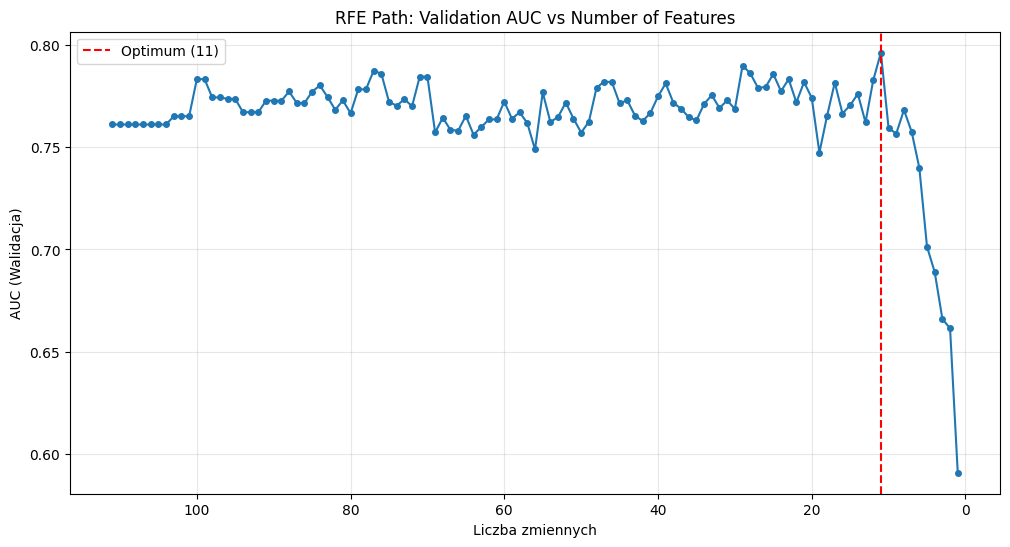

In [8]:
def hybrid_feature_selection(X_train, y_train, X_val, y_val, step_phase2=1):
    if isinstance(X_train, pd.DataFrame):
        features = X_train.columns.tolist()
        X_t = X_train.copy()
        X_v = X_val.copy()
    else:
        features = [f"feat_{i}" for i in range(X_train.shape[1])]
        X_t = pd.DataFrame(X_train, columns=features)
        X_v = pd.DataFrame(X_val, columns=features)

    print(f"START: Analiza {len(features)} zmiennych.")

    # --- FAZA 1: Probe Method (Odsiewanie szumu) ---    
    X_shadow = X_t.copy()
    X_shadow['RANDOM_PROBE'] = np.random.normal(0, 1, size=len(X_shadow))
    
    model_probe = XGBClassifier(n_estimators=100, max_depth=6, random_state=42, n_jobs=-1, enable_categorical=True)
    model_probe.fit(X_shadow, y_train)
    
    imps = pd.Series(model_probe.feature_importances_, index=X_shadow.columns)
    noise_threshold = imps['RANDOM_PROBE']
    
    keep_features = imps[imps > noise_threshold].index.tolist()
    if 'RANDOM_PROBE' in keep_features: keep_features.remove('RANDOM_PROBE')
    
    print(f"  Próg ważności (szum): {noise_threshold:.6f}")
    print(f"  Odrzucono: {len(features) - len(keep_features)} (szum/śmieci).")
    print(f"  Pozostało: {len(keep_features)} cech do precyzyjnej analizy.")

    if not keep_features:
        print("! UWAGA: Wszystkie cechy gorsze od szumu. Zwracam top 10 wg Gain.")
        return imps.drop('RANDOM_PROBE').nlargest(10).index.tolist()

    print(f"\n[Faza 2] Iteracyjne usuwanie (krok={step_phase2}) z walidacją...")
    
    current_features = keep_features.copy()
    history = []
    best_auc = 0
    best_features = []
    
    iteration = 0
    while len(current_features) >= 1:
        iteration += 1
        
        model = XGBClassifier(n_estimators=60, learning_rate=0.1, max_depth=4, n_jobs=-1, random_state=42, enable_categorical=True)
        model.fit(X_t[current_features], y_train)
        
        # Kluczowe: Decyzja na podstawie Walidacji
        y_pred_val = model.predict_proba(X_v[current_features])[:, 1]
        auc_val = roc_auc_score(y_val, y_pred_val)
        
        history.append({'n_features': len(current_features), 'auc_val': auc_val})
        
        if auc_val >= best_auc:
            best_auc = auc_val
            best_features = current_features.copy()
            print(f"  Iter {iteration}: {len(current_features)} cech -> AUC Val: {auc_val:.5f} (Nowy Rekord)")
        elif iteration % 5 == 0:
            print(f"  Iter {iteration}: {len(current_features)} cech -> AUC Val: {auc_val:.5f}")

        if len(current_features) == 1:
            break
            
        feat_imps = pd.Series(model.feature_importances_, index=current_features)
        n_drop = min(len(current_features) - 1, step_phase2)
        vars_to_drop = feat_imps.nsmallest(n_drop).index.tolist()
        
        for v in vars_to_drop:
            current_features.remove(v)

    print(f"KONIEC. Wybrano {len(best_features)} zmiennych.")
    print(f"Max AUC Val: {best_auc:.5f}")

    hist_df = pd.DataFrame(history)
    plt.figure(figsize=(12, 6))
    plt.plot(hist_df['n_features'], hist_df['auc_val'], marker='o', markersize=4, linewidth=1.5)
    plt.axvline(len(best_features), color='red', linestyle='--', label=f'Optimum ({len(best_features)})')
    plt.title('RFE Path: Validation AUC vs Number of Features')
    plt.xlabel('Liczba zmiennych')
    plt.ylabel('AUC (Walidacja)')
    plt.gca().invert_xaxis()
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    
    return best_features

selected_cols = hybrid_feature_selection(X_train_final, y_train, X_test_final, y_test, step_phase2=1)

In [9]:
selected_cols = ['wsk_liczba_dni_istnienia',
 'Srodki_trwale',
 'Srodki_pieniezne',
 'Kapital_wlasny',
 'Zobowiazania_rezerwy',
 'Zobowiazania_dostaw_uslug_12m',
 'przychody_sprzedazy',
 'pozostale_przychody_oper',
 'koszty_operacyjne_pozostale',
 'koszty_operacyjne',
 'RP_przeplywy_operacyjne',
 'RP_amortyzacja',
 'wsk_marza_ebitda_2',
 'wsk_ogolnego_zadluzenia_1',
 'wsk_ROE_brutto',
 'wsk_rotacja_zobowiazan_dostaw_uslug',
 'wsk_poziom_kapitalu_obrotowego_netto',
 'wsk_udzial_zob_biez_sprzedaz_2',
 'wsk_zast_kapitalu_obcego',
 'New_Debt_Ratio',
 'New_Equity_Multiplier',
 'Cycle_Gap',
 'Rule_Golden',
 'Altman_T1_WorkingCapital',
 'PKD_Dzial']

In [10]:
X_train_final.to_csv('data/X_train_final.csv', index=False)
X_val_final.to_csv('data/X_val_final.csv', index=False)
X_test_final.to_csv('data/X_test_final.csv', index=False)
y_train.to_csv('data/y_train.csv', index=False)
y_val.to_csv('data/y_val.csv', index=False)
y_test.to_csv('data/y_test.csv', index=False)
print('Dane zostały nadpisane w folderze data/')


Dane zostały nadpisane w folderze data/


#### dodatkowy kod na potem - żeby nie trzeba było szukać funkcji do ładowania i metryk

In [11]:
def save_best_params(params_dict, model_name, filepath=None):
    if filepath is None:
        filepath = f'best_params_{model_name}_tuned.json'
    
    params_serializable = {}
    for key, value in params_dict.items():
        if isinstance(value, (np.integer, np.int64, np.int32)):
            params_serializable[key] = int(value)
        elif isinstance(value, (np.floating, np.float64, np.float32)):
            params_serializable[key] = float(value)
        else:
            params_serializable[key] = value
    
    with open(filepath, 'w', encoding='utf-8') as f:
        json.dump(params_serializable, f, indent=4, ensure_ascii=False)
    
    print(f"✓ Zapisano parametry {model_name} do: {filepath}")
    return filepath

def load_best_params(model_name, filepath=None):

    if filepath is None:
        filepath = f'best_params_{model_name}_tuned.json'
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            params = json.load(f)
        print(f"✓ Wczytano parametry {model_name} z: {filepath}")
        return params
    except FileNotFoundError:
        print(f"✗ Nie znaleziono pliku: {filepath}")
        return None
    except json.JSONDecodeError as e:
        print(f"✗ Błąd w parsowaniu JSON: {e}")
        return None

print("Funkcje save_best_params() i load_best_params() zostały zdefiniowane.")

Funkcje save_best_params() i load_best_params() zostały zdefiniowane.


# Część 2
Trenowanie modeli Black                                                                                                                         Box                                                                                                                                                                                                                                                                                                     

##### Trzeba odpalić

In [ ]:
X_train_final = pd.read_csv('data/X_train_final.csv')
X_val_final = pd.read_csv('data/X_val_final.csv')
X_test_final = pd.read_csv('data/X_test_final.csv')
y_train = pd.read_csv('data/y_train.csv').iloc[:, 0]
y_val = pd.read_csv('data/y_test.csv').iloc[:, 0]
y_test = pd.read_csv('data/y_test.csv').iloc[:, 0]

In [23]:
selected_cols = ['wsk_liczba_dni_istnienia',
 'Srodki_trwale',
 'Srodki_pieniezne',
 'Kapital_wlasny',
 'Zobowiazania_rezerwy',
 'Zobowiazania_dostaw_uslug_12m',
 'przychody_sprzedazy',
 'pozostale_przychody_oper',
 'koszty_operacyjne_pozostale',
 'koszty_operacyjne',
 'RP_przeplywy_operacyjne',
 'RP_amortyzacja',
 'wsk_marza_ebitda_2',
 'wsk_ogolnego_zadluzenia_1',
 'wsk_ROE_brutto',
 'wsk_rotacja_zobowiazan_dostaw_uslug',
 'wsk_poziom_kapitalu_obrotowego_netto',
 'wsk_udzial_zob_biez_sprzedaz_2',
 'wsk_zast_kapitalu_obcego',
 'New_Debt_Ratio',
 'New_Equity_Multiplier',
 'Cycle_Gap',
 'Rule_Golden',
 'Altman_T1_WorkingCapital',
 'PKD_Dzial']

X_train_final = X_train_final[selected_cols]
X_test_final = X_test_final[selected_cols]
X_val_final = X_val_final[selected_cols]

### Trenowanie

#### LightGMB

In [24]:
lgbm_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("Trenowanie LightGBM...")
lgbm_model.fit(X_train_final, y_train)

y_pred_proba_lgbm_train = lgbm_model.predict_proba(X_train_final)[:, 1]
y_pred_proba_lgbm_val = lgbm_model.predict_proba(X_val_final)[:, 1]
y_pred_proba_lgbm_test = lgbm_model.predict_proba(X_test_final)[:, 1]


results_lgbm_train = evaluate_model(y_train, y_pred_proba_lgbm_train, model_name="LightGBM (Train)")
print_evaluation(results_lgbm_train)

results_lgbm_val = evaluate_model(y_val, y_pred_proba_lgbm_val, model_name="LightGBM (Val)")
print_evaluation(results_lgbm_val)

results_lgbm_test = evaluate_model(y_test, y_pred_proba_lgbm_test, model_name="LightGBM (Test)")
print_evaluation(results_lgbm_test)


Trenowanie LightGBM...


WYNIKI EWALUACJI: LightGBM (Train)
AUC-ROC:       0.9952
PR-AUC:        0.9591
KS Statistic:  0.9325
Log Loss:      0.0782
Brier Score:   0.0194
WYNIKI EWALUACJI: LightGBM (Val)
AUC-ROC:       0.7079
PR-AUC:        0.1354
KS Statistic:  0.3418
Log Loss:      0.2316
Brier Score:   0.0580
WYNIKI EWALUACJI: LightGBM (Test)
AUC-ROC:       0.7783
PR-AUC:        0.1896
KS Statistic:  0.4716
Log Loss:      0.2071
Brier Score:   0.0540


#### XGBoost

In [25]:
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    enable_categorical=True
)

print("Trenowanie XGBoost...")
xgb_model.fit(X_train_final, y_train)

y_pred_proba_xgb_train = xgb_model.predict_proba(X_train_final)[:, 1]
y_pred_proba_xgb_val = xgb_model.predict_proba(X_val_final)[:, 1]
y_pred_proba_xgb_test = xgb_model.predict_proba(X_test_final)[:, 1]


results_xgb_train = evaluate_model(y_train, y_pred_proba_xgb_train, model_name="XGBoost (Train)")
print_evaluation(results_xgb_train)

results_xgb_val = evaluate_model(y_val, y_pred_proba_xgb_val, model_name="XGBoost (Val)")
print_evaluation(results_xgb_val)

results_xgb_test = evaluate_model(y_test, y_pred_proba_xgb_test, model_name="XGBoost (Test)")
print_evaluation(results_xgb_test)

Trenowanie XGBoost...


WYNIKI EWALUACJI: XGBoost (Train)
AUC-ROC:       0.9949
PR-AUC:        0.9551
KS Statistic:  0.9198
Log Loss:      0.0841
Brier Score:   0.0214
WYNIKI EWALUACJI: XGBoost (Val)
AUC-ROC:       0.7076
PR-AUC:        0.1306
KS Statistic:  0.3938
Log Loss:      0.2307
Brier Score:   0.0585
WYNIKI EWALUACJI: XGBoost (Test)
AUC-ROC:       0.7851
PR-AUC:        0.1913
KS Statistic:  0.4261
Log Loss:      0.2018
Brier Score:   0.0531


#### SVM

In [26]:
cat_cols = X_train_final.select_dtypes(include=['object', 'category']).columns
num_cols = X_train_final.select_dtypes(exclude=['object', 'category']).columns

preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    (StandardScaler(), num_cols),
    verbose_feature_names_out=False
)

svm_pipeline = make_pipeline(
    preprocessor,
    SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
)

print("Trenowanie SVM...")
svm_pipeline.fit(X_train_final, y_train)

y_pred_proba_svm_train = svm_pipeline.predict_proba(X_train_final)[:, 1]
y_pred_proba_svm_val = svm_pipeline.predict_proba(X_val_final)[:, 1]
y_pred_proba_svm_test = svm_pipeline.predict_proba(X_test_final)[:, 1]

results_svm_train = evaluate_model(y_train, y_pred_proba_svm_train, model_name="SVM (Train)")
print_evaluation(results_svm_train)

results_svm_val = evaluate_model(y_val, y_pred_proba_svm_val, model_name="SVM (Val)")
print_evaluation(results_svm_val)

results_svm_test = evaluate_model(y_test, y_pred_proba_svm_test, model_name="SVM (Test)")
print_evaluation(results_svm_test)

Trenowanie SVM...
WYNIKI EWALUACJI: SVM (Train)
AUC-ROC:       0.9505
PR-AUC:        0.8349
KS Statistic:  0.8069
Log Loss:      0.1728
Brier Score:   0.0436
WYNIKI EWALUACJI: SVM (Val)
AUC-ROC:       0.6574
PR-AUC:        0.1159
KS Statistic:  0.2762
Log Loss:      0.2232
Brier Score:   0.0569
WYNIKI EWALUACJI: SVM (Test)
AUC-ROC:       0.6623
PR-AUC:        0.1067
KS Statistic:  0.2926
Log Loss:      0.2201
Brier Score:   0.0559


### Porównanie wszystkich modeli

           Model  AUC-ROC   PR-AUC  KS Statistic  Log Loss  Brier Score
LightGBM (Train) 0.995237 0.959131      0.932491  0.078207     0.019376
  LightGBM (Val) 0.707887 0.135433      0.341750  0.231557     0.057975
 LightGBM (Test) 0.778320 0.189595      0.471631  0.207076     0.054027
 XGBoost (Train) 0.994882 0.955119      0.919849  0.084093     0.021369
   XGBoost (Val) 0.707647 0.130608      0.393788  0.230713     0.058519
  XGBoost (Test) 0.785116 0.191256      0.426123  0.201762     0.053146
     SVM (Train) 0.950516 0.834899      0.806939  0.172752     0.043640
       SVM (Val) 0.657434 0.115921      0.276175  0.223242     0.056936
      SVM (Test) 0.662283 0.106670      0.292553  0.220066     0.055858


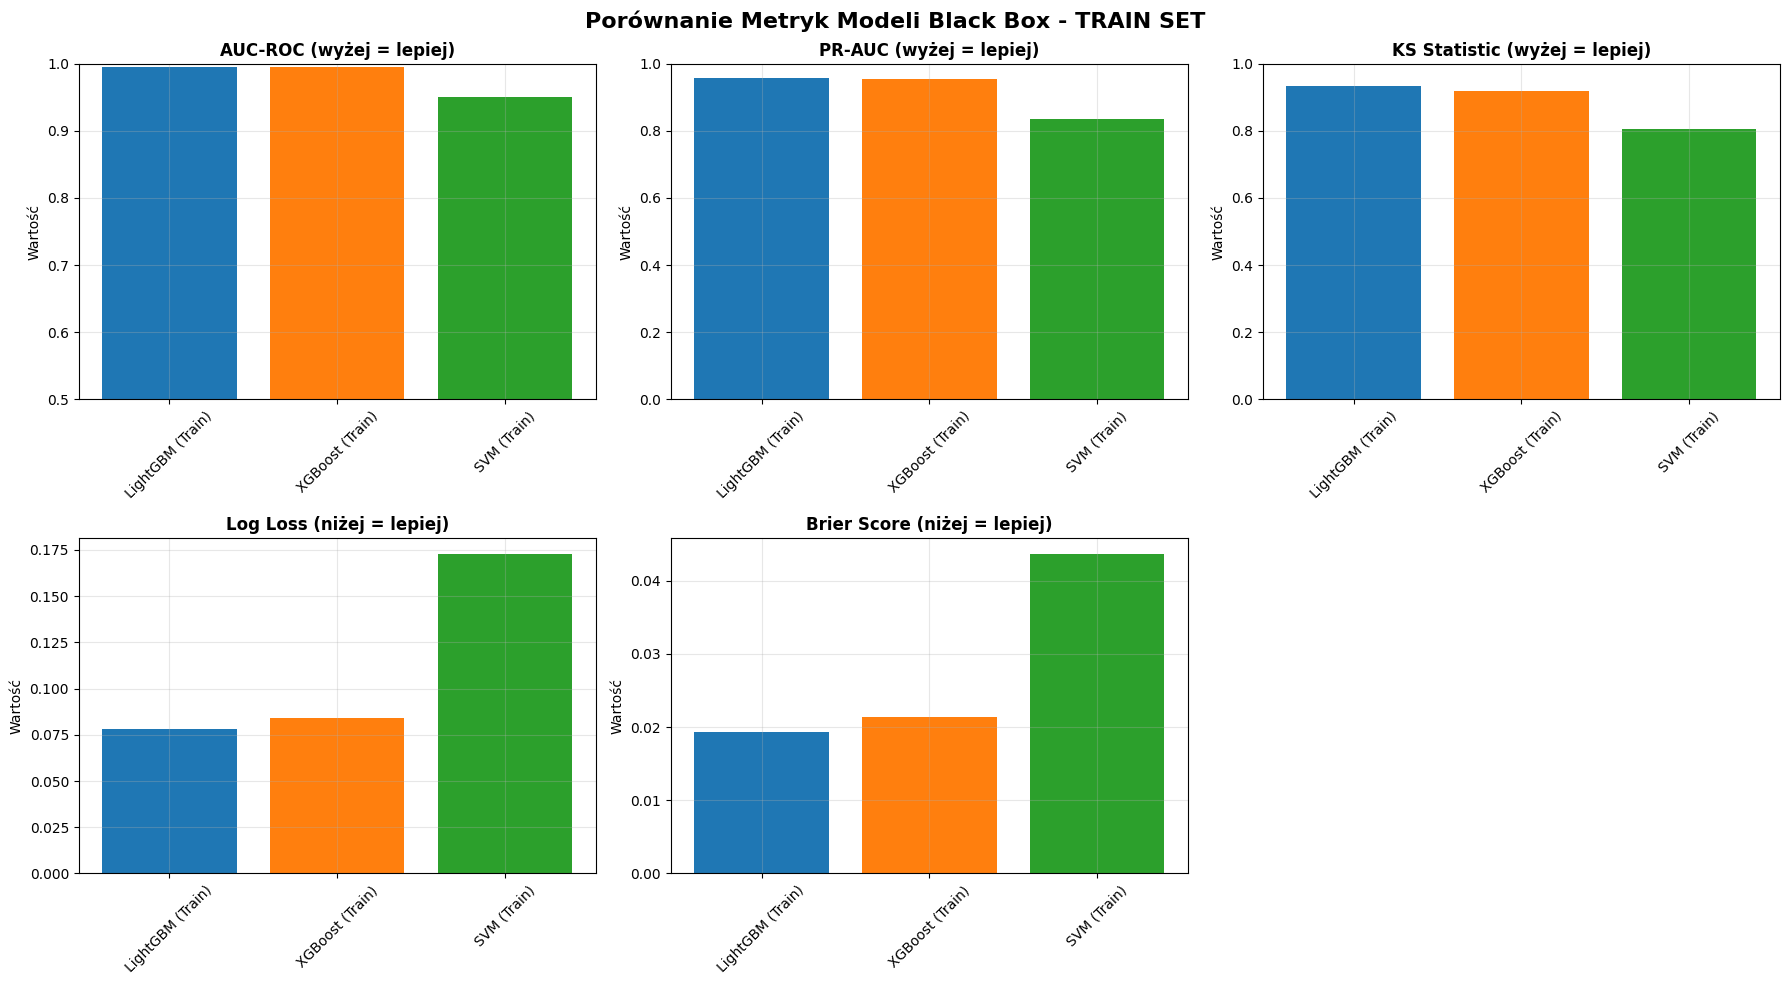

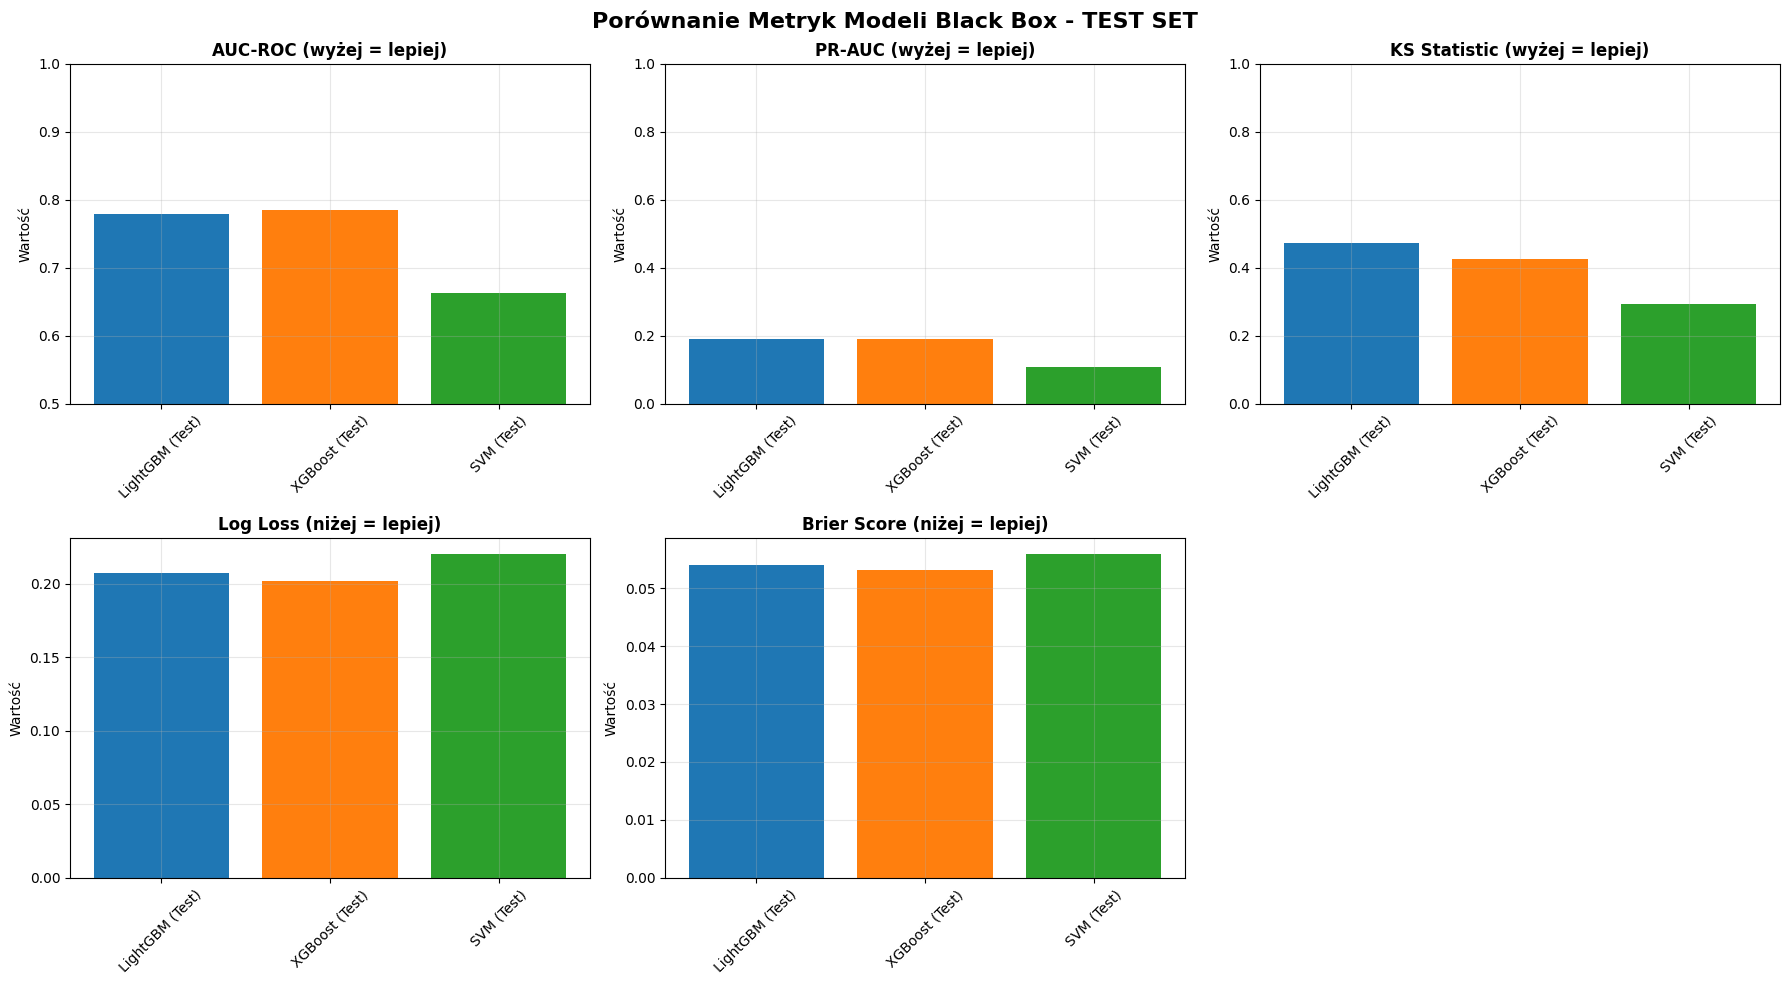

In [27]:
all_results_train = [results_lgbm_train, results_xgb_train, results_svm_train]
all_results_test = [results_lgbm_test, results_xgb_test, results_svm_test]
comparison_df_train = pd.DataFrame(all_results_train)
comparison_df_test = pd.DataFrame(all_results_test)

all_results_detailed = [
    results_lgbm_train, results_lgbm_val, results_lgbm_test,
    results_xgb_train, results_xgb_val, results_xgb_test,
    results_svm_train, results_svm_val, results_svm_test
]
comparison_df_detailed = pd.DataFrame(all_results_detailed)


print(comparison_df_detailed.to_string(index=False))

# Wizualizacja porównania - TRAIN SET
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Porównanie Metryk Modeli Black Box - TRAIN SET', fontsize=16, fontweight='bold')

metrics = ['AUC-ROC', 'PR-AUC', 'KS Statistic', 'Log Loss', 'Brier Score']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# AUC-ROC
axes[0, 0].bar(comparison_df_train['Model'], comparison_df_train['AUC-ROC'], color=colors)
axes[0, 0].set_title('AUC-ROC (wyżej = lepiej)', fontweight='bold')
axes[0, 0].set_ylabel('Wartość')
axes[0, 0].set_ylim([0.5, 1.0])
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# PR-AUC
axes[0, 1].bar(comparison_df_train['Model'], comparison_df_train['PR-AUC'], color=colors)
axes[0, 1].set_title('PR-AUC (wyżej = lepiej)', fontweight='bold')
axes[0, 1].set_ylabel('Wartość')
axes[0, 1].set_ylim([0, 1.0])
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# KS Statistic
axes[0, 2].bar(comparison_df_train['Model'], comparison_df_train['KS Statistic'], color=colors)
axes[0, 2].set_title('KS Statistic (wyżej = lepiej)', fontweight='bold')
axes[0, 2].set_ylabel('Wartość')
axes[0, 2].set_ylim([0, 1.0])
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].tick_params(axis='x', rotation=45)

# Log Loss
axes[1, 0].bar(comparison_df_train['Model'], comparison_df_train['Log Loss'], color=colors)
axes[1, 0].set_title('Log Loss (niżej = lepiej)', fontweight='bold')
axes[1, 0].set_ylabel('Wartość')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Brier Score
axes[1, 1].bar(comparison_df_train['Model'], comparison_df_train['Brier Score'], color=colors)
axes[1, 1].set_title('Brier Score (niżej = lepiej)', fontweight='bold')
axes[1, 1].set_ylabel('Wartość')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

# Ukryj ostatni subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Wizualizacja porównania - TEST SET
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Porównanie Metryk Modeli Black Box - TEST SET', fontsize=16, fontweight='bold')

# AUC-ROC
axes[0, 0].bar(comparison_df_test['Model'], comparison_df_test['AUC-ROC'], color=colors)
axes[0, 0].set_title('AUC-ROC (wyżej = lepiej)', fontweight='bold')
axes[0, 0].set_ylabel('Wartość')
axes[0, 0].set_ylim([0.5, 1.0])
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# PR-AUC
axes[0, 1].bar(comparison_df_test['Model'], comparison_df_test['PR-AUC'], color=colors)
axes[0, 1].set_title('PR-AUC (wyżej = lepiej)', fontweight='bold')
axes[0, 1].set_ylabel('Wartość')
axes[0, 1].set_ylim([0, 1.0])
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# KS Statistic
axes[0, 2].bar(comparison_df_test['Model'], comparison_df_test['KS Statistic'], color=colors)
axes[0, 2].set_title('KS Statistic (wyżej = lepiej)', fontweight='bold')
axes[0, 2].set_ylabel('Wartość')
axes[0, 2].set_ylim([0, 1.0])
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].tick_params(axis='x', rotation=45)

# Log Loss
axes[1, 0].bar(comparison_df_test['Model'], comparison_df_test['Log Loss'], color=colors)
axes[1, 0].set_title('Log Loss (niżej = lepiej)', fontweight='bold')
axes[1, 0].set_ylabel('Wartość')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Brier Score
axes[1, 1].bar(comparison_df_test['Model'], comparison_df_test['Brier Score'], color=colors)
axes[1, 1].set_title('Brier Score (niżej = lepiej)', fontweight='bold')
axes[1, 1].set_ylabel('Wartość')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

# Ukryj ostatni subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## Hipetruning parametryczny z kontrolą overfittingu

### Trening

#### LightGBM - Optuna Tuning

In [28]:
def objective_lgbm(trial):    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),  
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.02, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 4), 
        'num_leaves': trial.suggest_int('num_leaves', 3, 10), 
        'min_child_samples': trial.suggest_int('min_child_samples', 100, 500),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.5, 10.0),
        'subsample': trial.suggest_float('subsample', 0.4, 0.7),
        'bagging_freq': 1,
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.7),
        'reg_alpha': trial.suggest_float('reg_alpha', 5.0, 100.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 5.0, 100.0, log=True), 
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    try:
        model = LGBMClassifier(**params)
        
        model.fit(X_train_final, y_train)
        
        y_pred_train = model.predict_proba(X_train_final)[:, 1]
        y_pred_val = model.predict_proba(X_val_final)[:, 1]
        
        auc_train = roc_auc_score(y_train, y_pred_train)
        auc_val = roc_auc_score(y_val, y_pred_val)
        
        penalty_weight = 0.5 
        score = auc_val - penalty_weight * abs(auc_train - auc_val)
        return score
        
    except Exception: # Użycie czystego except zamiast printowania błędu, zgodnie z instrukcją
        return -np.inf

In [29]:
sampler_lgbm = optuna.samplers.TPESampler(seed=42)
pruner_lgbm = MedianPruner()
study_lgbm = optuna.create_study(sampler=sampler_lgbm, pruner=pruner_lgbm, direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=100, show_progress_bar=False)

print(f"\nNajlepszy wynik LightGBM: {study_lgbm.best_value:.6f}")
print("Najlepsze parametry LightGBM:")
lgbm_best_params = study_lgbm.best_params
for param, value in lgbm_best_params.items():
    print(f"  {param}: {value}")


lgbm_tuned = LGBMClassifier(
    **lgbm_best_params,
    bagging_freq=1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgbm_tuned.fit(X_train_final, y_train)


[I 2025-12-12 00:43:35,350] A new study created in memory with name: no-name-ed700a72-b5a6-48b1-8e0b-7481ede6fbb1
[I 2025-12-12 00:43:37,297] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 144, 'learning_rate': 0.017254716573280357, 'max_depth': 4, 'num_leaves': 7, 'min_child_samples': 162, 'min_split_gain': 1.981947943193925, 'subsample': 0.4174250836504598, 'colsample_bytree': 0.6598528437324805, 'reg_alpha': 30.271829277346235, 'reg_lambda': 41.705532161810446}. Best is trial 0 with value: 0.5.
[I 2025-12-12 00:43:38,290] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 55, 'learning_rate': 0.018276027831785738, 'max_depth': 4, 'num_leaves': 4, 'min_child_samples': 172, 'min_split_gain': 2.2423428436076214, 'subsample': 0.4912726728878613, 'colsample_bytree': 0.5574269294896713, 'reg_alpha': 18.23658142455605, 'reg_lambda': 11.963764382790318}. Best is trial 0 with value: 0.5.
[I 2025-12-12 00:43:38,563] Trial 2 finished with value: 0.5 and parame


Najlepszy wynik LightGBM: 0.733022
Najlepsze parametry LightGBM:
  n_estimators: 95
  learning_rate: 0.0020027005787303103
  max_depth: 4
  num_leaves: 9
  min_child_samples: 141
  min_split_gain: 7.767378122650826
  subsample: 0.5799122360040712
  colsample_bytree: 0.598923585755943
  reg_alpha: 6.859293577707985
  reg_lambda: 9.31413758629182


LGBMClassifier(bagging_freq=1, colsample_bytree=0.598923585755943,
               learning_rate=0.0020027005787303103, max_depth=4,
               min_child_samples=141, min_split_gain=7.767378122650826,
               n_estimators=95, n_jobs=-1, num_leaves=9, random_state=42,
               reg_alpha=6.859293577707985, reg_lambda=9.31413758629182,
               subsample=0.5799122360040712, verbose=-1)

In [30]:
y_pred_lgbm_train_tuned = lgbm_tuned.predict_proba(X_train_final)[:, 1]
y_pred_lgbm_val_tuned = lgbm_tuned.predict_proba(X_val_final)[:, 1]
y_pred_lgbm_test_tuned = lgbm_tuned.predict_proba(X_test_final)[:, 1]

results_lgbm_train_tuned = evaluate_model(y_train, y_pred_lgbm_train_tuned, "LightGBM Tuned (Train)")
results_lgbm_val_tuned = evaluate_model(y_val, y_pred_lgbm_val_tuned, "LightGBM Tuned (Val)")
results_lgbm_test_tuned = evaluate_model(y_test, y_pred_lgbm_test_tuned, "LightGBM Tuned (Test)")

print_evaluation(results_lgbm_train_tuned)
print_evaluation(results_lgbm_val_tuned)
print_evaluation(results_lgbm_test_tuned)

WYNIKI EWALUACJI: LightGBM Tuned (Train)
AUC-ROC:       0.7451
PR-AUC:        0.2016
KS Statistic:  0.3783
Log Loss:      0.2286
Brier Score:   0.0572
WYNIKI EWALUACJI: LightGBM Tuned (Val)
AUC-ROC:       0.7371
PR-AUC:        0.1694
KS Statistic:  0.4353
Log Loss:      0.2301
Brier Score:   0.0577
WYNIKI EWALUACJI: LightGBM Tuned (Test)
AUC-ROC:       0.7601
PR-AUC:        0.1886
KS Statistic:  0.4060
Log Loss:      0.2256
Brier Score:   0.0562


#### XGBoost - Optuna Tuning

In [31]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 20),
        'subsample': trial.suggest_float('subsample', 0.4, 0.8), 
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.8),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 50.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1.0, 50.0, log=True),
        'gamma': trial.suggest_float('gamma', 0.1, 5.0),
        'enable_categorical': True,
        'eval_metric': 'auc',
        'random_state': 42
    }
    
    try:
        model = XGBClassifier(**params)
        
        # Trenowanie na zbiorze treningowym
        model.fit(X_train_final, y_train)
        
        # Ewaluacja na zbiorze treningowym i walidacyjnym
        y_pred_train = model.predict_proba(X_train_final)[:, 1]
        y_pred_val = model.predict_proba(X_val_final)[:, 1]
        
        auc_train = roc_auc_score(y_train, y_pred_train)
        auc_val = roc_auc_score(y_val, y_pred_val)
        
        penalty_weight = 0.5 
        score = auc_val - penalty_weight * abs(auc_train - auc_val)
        
        return score
    except Exception:
        return -np.inf

In [33]:
sampler_xgb = optuna.samplers.TPESampler(seed=42)
pruner_xgb = MedianPruner()
study_xgb = optuna.create_study(sampler=sampler_xgb, pruner=pruner_xgb, direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100, show_progress_bar=False)


[I 2025-12-12 00:44:51,749] A new study created in memory with name: no-name-4d9f47ad-1336-4cd8-b0d4-361c5849748e
[I 2025-12-12 00:44:52,176] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 144, 'learning_rate': 0.04123206532618727, 'max_depth': 5, 'min_child_weight': 14, 'subsample': 0.46240745617697465, 'colsample_bytree': 0.46239780813448106, 'reg_lambda': 1.2551115172973832, 'reg_alpha': 29.621516588303486, 'gamma': 3.0454635575417233}. Best is trial 0 with value: 0.5.
[I 2025-12-12 00:44:53,152] Trial 1 finished with value: 0.6851449393746838 and parameters: {'n_estimators': 227, 'learning_rate': 0.0010838581269344747, 'max_depth': 6, 'min_child_weight': 18, 'subsample': 0.4849356442713105, 'colsample_bytree': 0.4727299868828403, 'reg_lambda': 2.0492680115417348, 'reg_alpha': 3.2877474139911183, 'gamma': 2.6713065149979656}. Best is trial 1 with value: 0.6851449393746838.
[I 2025-12-12 00:44:53,689] Trial 2 finished with value: 0.6737054833734708 and parameters: 

In [34]:
xgb_best_params = study_xgb.best_params

xgb_tuned = XGBClassifier(
    n_estimators=int(xgb_best_params['n_estimators']),
    learning_rate=xgb_best_params['learning_rate'],
    max_depth=int(xgb_best_params['max_depth']),
    min_child_weight=int(xgb_best_params['min_child_weight']),
    subsample=xgb_best_params['subsample'],
    colsample_bytree=xgb_best_params['colsample_bytree'],
    reg_lambda=xgb_best_params['reg_lambda'],
    reg_alpha=xgb_best_params['reg_alpha'],
    gamma=xgb_best_params['gamma'],
    enable_categorical=True,
    eval_metric='auc',
    random_state=42
)
xgb_tuned.fit(X_train_final, y_train)

y_pred_xgb_train_tuned = xgb_tuned.predict_proba(X_train_final)[:, 1]
y_pred_xgb_val_tuned = xgb_tuned.predict_proba(X_val_final)[:, 1]
y_pred_xgb_test_tuned = xgb_tuned.predict_proba(X_test_final)[:, 1]

results_xgb_train_tuned = evaluate_model(y_train, y_pred_xgb_train_tuned, "XGBoost Tuned (Train)")
results_xgb_val_tuned = evaluate_model(y_val, y_pred_xgb_val_tuned, "XGBoost Tuned (Val)")
results_xgb_test_tuned = evaluate_model(y_test, y_pred_xgb_test_tuned, "XGBoost Tuned (Test)")

print("\nWyniki XGBoost Tuned:")
print_evaluation(results_xgb_train_tuned)
print_evaluation(results_xgb_val_tuned)
print_evaluation(results_xgb_test_tuned)


Wyniki XGBoost Tuned:
WYNIKI EWALUACJI: XGBoost Tuned (Train)
AUC-ROC:       0.7412
PR-AUC:        0.1464
KS Statistic:  0.4024
Log Loss:      0.2148
Brier Score:   0.0555
WYNIKI EWALUACJI: XGBoost Tuned (Val)
AUC-ROC:       0.7266
PR-AUC:        0.2202
KS Statistic:  0.4167
Log Loss:      0.2167
Brier Score:   0.0559
WYNIKI EWALUACJI: XGBoost Tuned (Test)
AUC-ROC:       0.7680
PR-AUC:        0.1682
KS Statistic:  0.4314
Log Loss:      0.2099
Brier Score:   0.0543


#### SVM - Optuna Tuning

In [35]:
cat_cols = X_train_final.select_dtypes(include=['object', 'category']).columns
num_cols = X_train_final.select_dtypes(exclude=['object', 'category']).columns

preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    (StandardScaler(), num_cols),
    verbose_feature_names_out=False
)

In [36]:
def objective_svm(trial):
    c_param = trial.suggest_float('C', 0.001, 5.0, log=True)
    gamma_param = trial.suggest_categorical('gamma', ['scale', 'auto'])
    weight_param = trial.suggest_categorical('class_weight', [None, 'balanced'])

    model_pipeline = make_pipeline(
        preprocessor,
        SVC(
            C=c_param,
            gamma=gamma_param,
            class_weight=weight_param,
            kernel='rbf',
            probability=True,
            random_state=42,
            cache_size=1000
        )
    )

    try:
        model_pipeline.fit(X_train_final, y_train)

        y_pred_train = model_pipeline.predict_proba(X_train_final)[:, 1]
        y_pred_val = model_pipeline.predict_proba(X_val_final)[:, 1]

        auc_train = roc_auc_score(y_train, y_pred_train)
        auc_val = roc_auc_score(y_val, y_pred_val)

        if auc_val< 0.6 or auc_train> 0.83:
            return -1


        score = auc_val

        return score

    except Exception:
        return -np.inf

In [37]:
sampler_svm = optuna.samplers.TPESampler(seed=42)
study_svm = optuna.create_study(sampler=sampler_svm, direction='maximize')
study_svm.optimize(objective_svm, n_trials=60, show_progress_bar=False)

print(f"\nNajlepszy wynik (score): {study_svm.best_value:.6f}")
print("Najlepsze parametry SVM:", study_svm.best_params)
best = study_svm.best_params


[I 2025-12-12 00:46:31,536] A new study created in memory with name: no-name-ba86f658-0b3b-4380-baa2-ded0627fbdc6
[I 2025-12-12 00:46:32,052] Trial 0 finished with value: -1.0 and parameters: {'C': 0.024289169469748875, 'gamma': 'scale', 'class_weight': None}. Best is trial 0 with value: -1.0.
[I 2025-12-12 00:46:33,840] Trial 1 finished with value: -1.0 and parameters: {'C': 0.003775887545682684, 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 0 with value: -1.0.
[I 2025-12-12 00:46:34,063] Trial 2 finished with value: -1.0 and parameters: {'C': 0.0011916299962955155, 'gamma': 'scale', 'class_weight': None}. Best is trial 0 with value: -1.0.
[I 2025-12-12 00:46:34,349] Trial 3 finished with value: -1.0 and parameters: {'C': 0.004768785415482609, 'gamma': 'auto', 'class_weight': None}. Best is trial 0 with value: -1.0.
[I 2025-12-12 00:46:35,593] Trial 4 finished with value: -1.0 and parameters: {'C': 0.18332660870188128, 'gamma': 'auto', 'class_weight': 'balanced'}. Best i


Najlepszy wynik (score): 0.722529
Najlepsze parametry SVM: {'C': 0.06312067961875495, 'gamma': 'scale', 'class_weight': 'balanced'}


In [38]:
svm_pipeline_final = make_pipeline(
    preprocessor,
    SVC(
        C=best['C'],
        gamma=best['gamma'],
        class_weight=best['class_weight'], 
        kernel='rbf',
        probability=True,
        random_state=42,
        cache_size=1000
    )
)

svm_pipeline_final.fit(X_train_final, y_train)

y_pred_svm_train = svm_pipeline_final.predict_proba(X_train_final)[:, 1]
y_pred_svm_val = svm_pipeline_final.predict_proba(X_val_final)[:, 1]
y_pred_svm_test = svm_pipeline_final.predict_proba(X_test_final)[:, 1]

results_svm_train_tuned = evaluate_model(y_train, y_pred_svm_train, "SVM BetterReg (Train)")
results_svm_val_tuned = evaluate_model(y_val, y_pred_svm_val, "SVM BetterReg (Val)")
results_svm_test_tuned = evaluate_model(y_test, y_pred_svm_test, "SVM BetterReg (Test)")

print("\nWyniki SVM po poprawkach:")
print_evaluation(results_svm_train_tuned)
print_evaluation(results_svm_val_tuned) 
print_evaluation(results_svm_test_tuned)  


Wyniki SVM po poprawkach:
WYNIKI EWALUACJI: SVM BetterReg (Train)
AUC-ROC:       0.8164
PR-AUC:        0.2200
KS Statistic:  0.4883
Log Loss:      0.1958
Brier Score:   0.0527
WYNIKI EWALUACJI: SVM BetterReg (Val)
AUC-ROC:       0.7225
PR-AUC:        0.1529
KS Statistic:  0.3976
Log Loss:      0.2144
Brier Score:   0.0553
WYNIKI EWALUACJI: SVM BetterReg (Test)
AUC-ROC:       0.7510
PR-AUC:        0.1548
KS Statistic:  0.4297
Log Loss:      0.2040
Brier Score:   0.0539


### Porównanie


                 Model  AUC-ROC   PR-AUC  KS Statistic  Log Loss  Brier Score
      LightGBM (Train) 0.995237 0.959131      0.932491  0.078207     0.019376
        LightGBM (Val) 0.707887 0.135433      0.341750  0.231557     0.057975
       LightGBM (Test) 0.778320 0.189595      0.471631  0.207076     0.054027
LightGBM Tuned (Train) 0.745108 0.201563      0.378268  0.228614     0.057215
  LightGBM Tuned (Val) 0.737051 0.169433      0.435265  0.230063     0.057694
 LightGBM Tuned (Test) 0.760097 0.188576      0.406028  0.225554     0.056237
       XGBoost (Train) 0.994882 0.955119      0.919849  0.084093     0.021369
         XGBoost (Val) 0.707647 0.130608      0.393788  0.230713     0.058519
        XGBoost (Test) 0.785116 0.191256      0.426123  0.201762     0.053146
 XGBoost Tuned (Train) 0.741192 0.146397      0.402367  0.214751     0.055524
   XGBoost Tuned (Val) 0.726585 0.220187      0.416735  0.216681     0.055903
  XGBoost Tuned (Test) 0.767952 0.168220      0.431442  0.20989

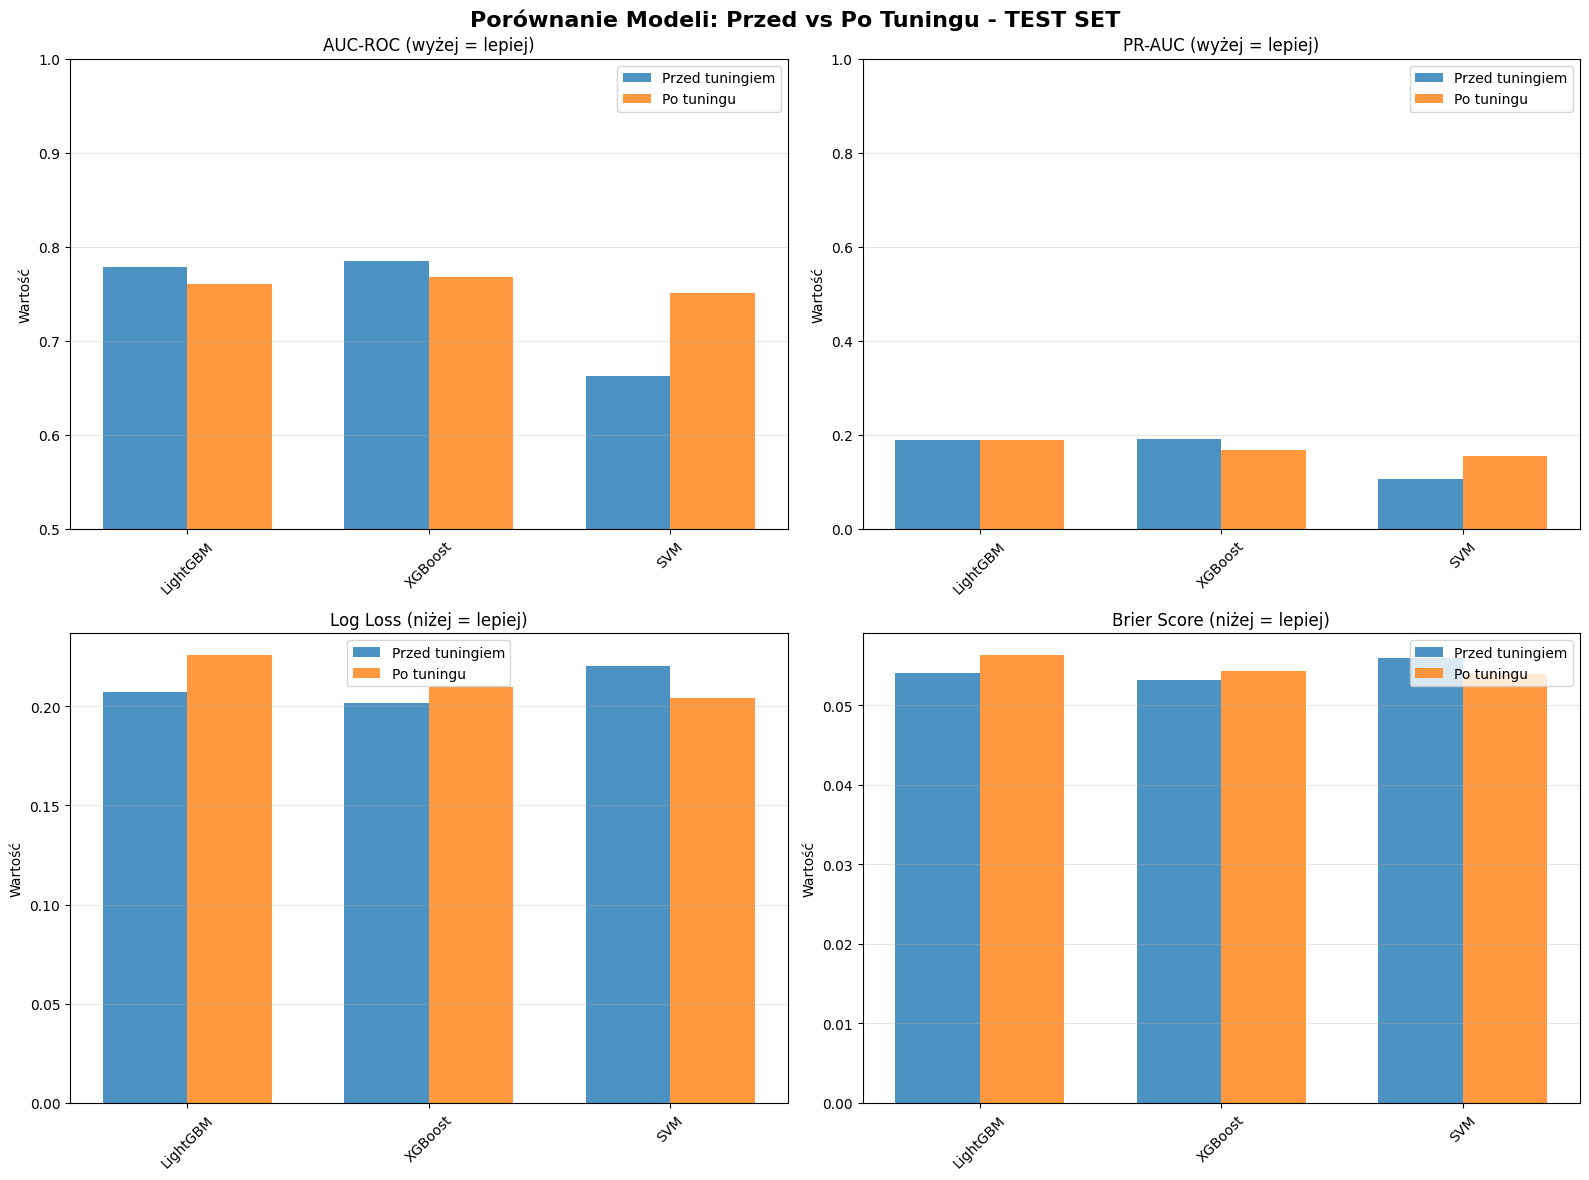

In [39]:

comparison_tuning = [
    results_lgbm_train, results_lgbm_val, results_lgbm_test,
    results_lgbm_train_tuned, results_lgbm_val_tuned, results_lgbm_test_tuned,
    results_xgb_train, results_xgb_val, results_xgb_test,
    results_xgb_train_tuned, results_xgb_val_tuned, results_xgb_test_tuned,
    results_svm_train, results_svm_val, results_svm_test,
    results_svm_train_tuned, results_svm_val_tuned, results_svm_test_tuned
]

df_tuning = pd.DataFrame(comparison_tuning)

print("\n" + df_tuning.to_string(index=False))


print(f"{'Model':<25} {'AUC-ROC':<12} {'PR-AUC':<12} {'Log Loss':<12} {'Brier':<12}")
print("-" * 75)

for model_name in ['LightGBM', 'XGBoost', 'SVM']:
    train_before = df_tuning[(df_tuning['Model'].str.contains(model_name)) & 
                             (df_tuning['Model'].str.contains('Train')) & 
                             (~df_tuning['Model'].str.contains('Tuned')) &
                             (~df_tuning['Model'].str.contains('BetterReg'))]
    test_before = df_tuning[(df_tuning['Model'].str.contains(model_name)) & 
                            (df_tuning['Model'].str.contains('Test')) & 
                            (~df_tuning['Model'].str.contains('Tuned')) &
                            (~df_tuning['Model'].str.contains('BetterReg'))]
    
    train_after = df_tuning[(df_tuning['Model'].str.contains(model_name)) & 
                            (df_tuning['Model'].str.contains('Train')) & 
                            ((df_tuning['Model'].str.contains('Tuned')) |
                             (df_tuning['Model'].str.contains('BetterReg')))]
    test_after = df_tuning[(df_tuning['Model'].str.contains(model_name)) & 
                           (df_tuning['Model'].str.contains('Test')) & 
                           ((df_tuning['Model'].str.contains('Tuned')) |
                            (df_tuning['Model'].str.contains('BetterReg')))]
    
    if not train_before.empty and not test_before.empty:
        print(f"\n{model_name} (PRZED tuningiem):")
        auc_diff = train_before['AUC-ROC'].values[0] - test_before['AUC-ROC'].values[0]
        pr_diff = train_before['PR-AUC'].values[0] - test_before['PR-AUC'].values[0]
        loss_diff = test_before['Log Loss'].values[0] - train_before['Log Loss'].values[0]
        brier_diff = test_before['Brier Score'].values[0] - train_before['Brier Score'].values[0]
        print(f"  {'(PRZED)':<25} {auc_diff:>11.4f}  {pr_diff:>11.4f}  {loss_diff:>11.4f}  {brier_diff:>11.4f}")
        
    if not train_after.empty and not test_after.empty:
        print(f"{model_name} (PO tuningu):")
        auc_diff = train_after['AUC-ROC'].values[0] - test_after['AUC-ROC'].values[0]
        pr_diff = train_after['PR-AUC'].values[0] - test_after['PR-AUC'].values[0]
        loss_diff = test_after['Log Loss'].values[0] - train_after['Log Loss'].values[0]
        brier_diff = test_after['Brier Score'].values[0] - train_after['Brier Score'].values[0]
        print(f"  {'(PO TUNINGU)':<25} {auc_diff:>11.4f}  {pr_diff:>11.4f}  {loss_diff:>11.4f}  {brier_diff:>11.4f}")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Porównanie Modeli: Przed vs Po Tuningu - TEST SET', fontsize=16, fontweight='bold')

models_names = ['LightGBM', 'XGBoost', 'SVM']
metrics_list = ['AUC-ROC', 'PR-AUC', 'Log Loss', 'Brier Score']

test_before = []
test_after = []
valid_models = []

for model_name in models_names:
    before = df_tuning[(df_tuning['Model'].str.contains(model_name)) & 
                      (df_tuning['Model'].str.contains('Test')) & 
                      (~df_tuning['Model'].str.contains('Tuned')) &
                      (~df_tuning['Model'].str.contains('BetterReg'))]
    after = df_tuning[(df_tuning['Model'].str.contains(model_name)) & 
                     (df_tuning['Model'].str.contains('Test')) & 
                     ((df_tuning['Model'].str.contains('Tuned')) |
                      (df_tuning['Model'].str.contains('BetterReg')))]
    
    if not before.empty and not after.empty:
        test_before.append(before.iloc[0])
        test_after.append(after.iloc[0])
        valid_models.append(model_name)

if len(valid_models) > 0:
    ax = axes[0, 0]
    x = np.arange(len(valid_models))
    width = 0.35
    before_values = [d['AUC-ROC'] for d in test_before]
    after_values = [d['AUC-ROC'] for d in test_after]
    ax.bar(x - width/2, before_values, width, label='Przed tuningiem', alpha=0.8)
    ax.bar(x + width/2, after_values, width, label='Po tuningu', alpha=0.8)
    ax.set_ylabel('Wartość')
    ax.set_title('AUC-ROC (wyżej = lepiej)')
    ax.set_xticks(x)
    ax.set_xticklabels(valid_models, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0.5, 1.0])

    # PR-AUC
    ax = axes[0, 1]
    before_values = [d['PR-AUC'] for d in test_before]
    after_values = [d['PR-AUC'] for d in test_after]
    ax.bar(x - width/2, before_values, width, label='Przed tuningiem', alpha=0.8)
    ax.bar(x + width/2, after_values, width, label='Po tuningu', alpha=0.8)
    ax.set_ylabel('Wartość')
    ax.set_title('PR-AUC (wyżej = lepiej)')
    ax.set_xticks(x)
    ax.set_xticklabels(valid_models, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1.0])

    # Log Loss
    ax = axes[1, 0]
    before_values = [d['Log Loss'] for d in test_before]
    after_values = [d['Log Loss'] for d in test_after]
    ax.bar(x - width/2, before_values, width, label='Przed tuningiem', alpha=0.8)
    ax.bar(x + width/2, after_values, width, label='Po tuningu', alpha=0.8)
    ax.set_ylabel('Wartość')
    ax.set_title('Log Loss (niżej = lepiej)')
    ax.set_xticks(x)
    ax.set_xticklabels(valid_models, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Brier Score
    ax = axes[1, 1]
    before_values = [d['Brier Score'] for d in test_before]
    after_values = [d['Brier Score'] for d in test_after]
    ax.bar(x - width/2, before_values, width, label='Przed tuningiem', alpha=0.8)
    ax.bar(x + width/2, after_values, width, label='Po tuningu', alpha=0.8)
    ax.set_ylabel('Wartość')
    ax.set_title('Brier Score (niżej = lepiej)')
    ax.set_xticks(x)
    ax.set_xticklabels(valid_models, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()
else:
    print("\n Brak wyników do wyświetlenia na wykresach")



=== ANALIZA OVERFITTINGU (Train vs Test) ===
                 AUC-ROC_Train  AUC-ROC_Test  AUC Gap (Train-Test)  Log Loss_Train  Log Loss_Test  LogLoss Gap (Test-Train)
Algorithm State                                                                                                            
LightGBM  PRZED         0.9952        0.7783                0.2169          0.0782         0.2071                    0.1289
          PO            0.7451        0.7601               -0.0150          0.2286         0.2256                   -0.0031
SVM       PRZED         0.9505        0.6623                0.2882          0.1728         0.2201                    0.0473
          PO            0.8164        0.7510                0.0653          0.1958         0.2040                    0.0082
XGBoost   PRZED         0.9949        0.7851                0.2098          0.0841         0.2018                    0.1177
          PO            0.7412        0.7680               -0.0268          0.2148    

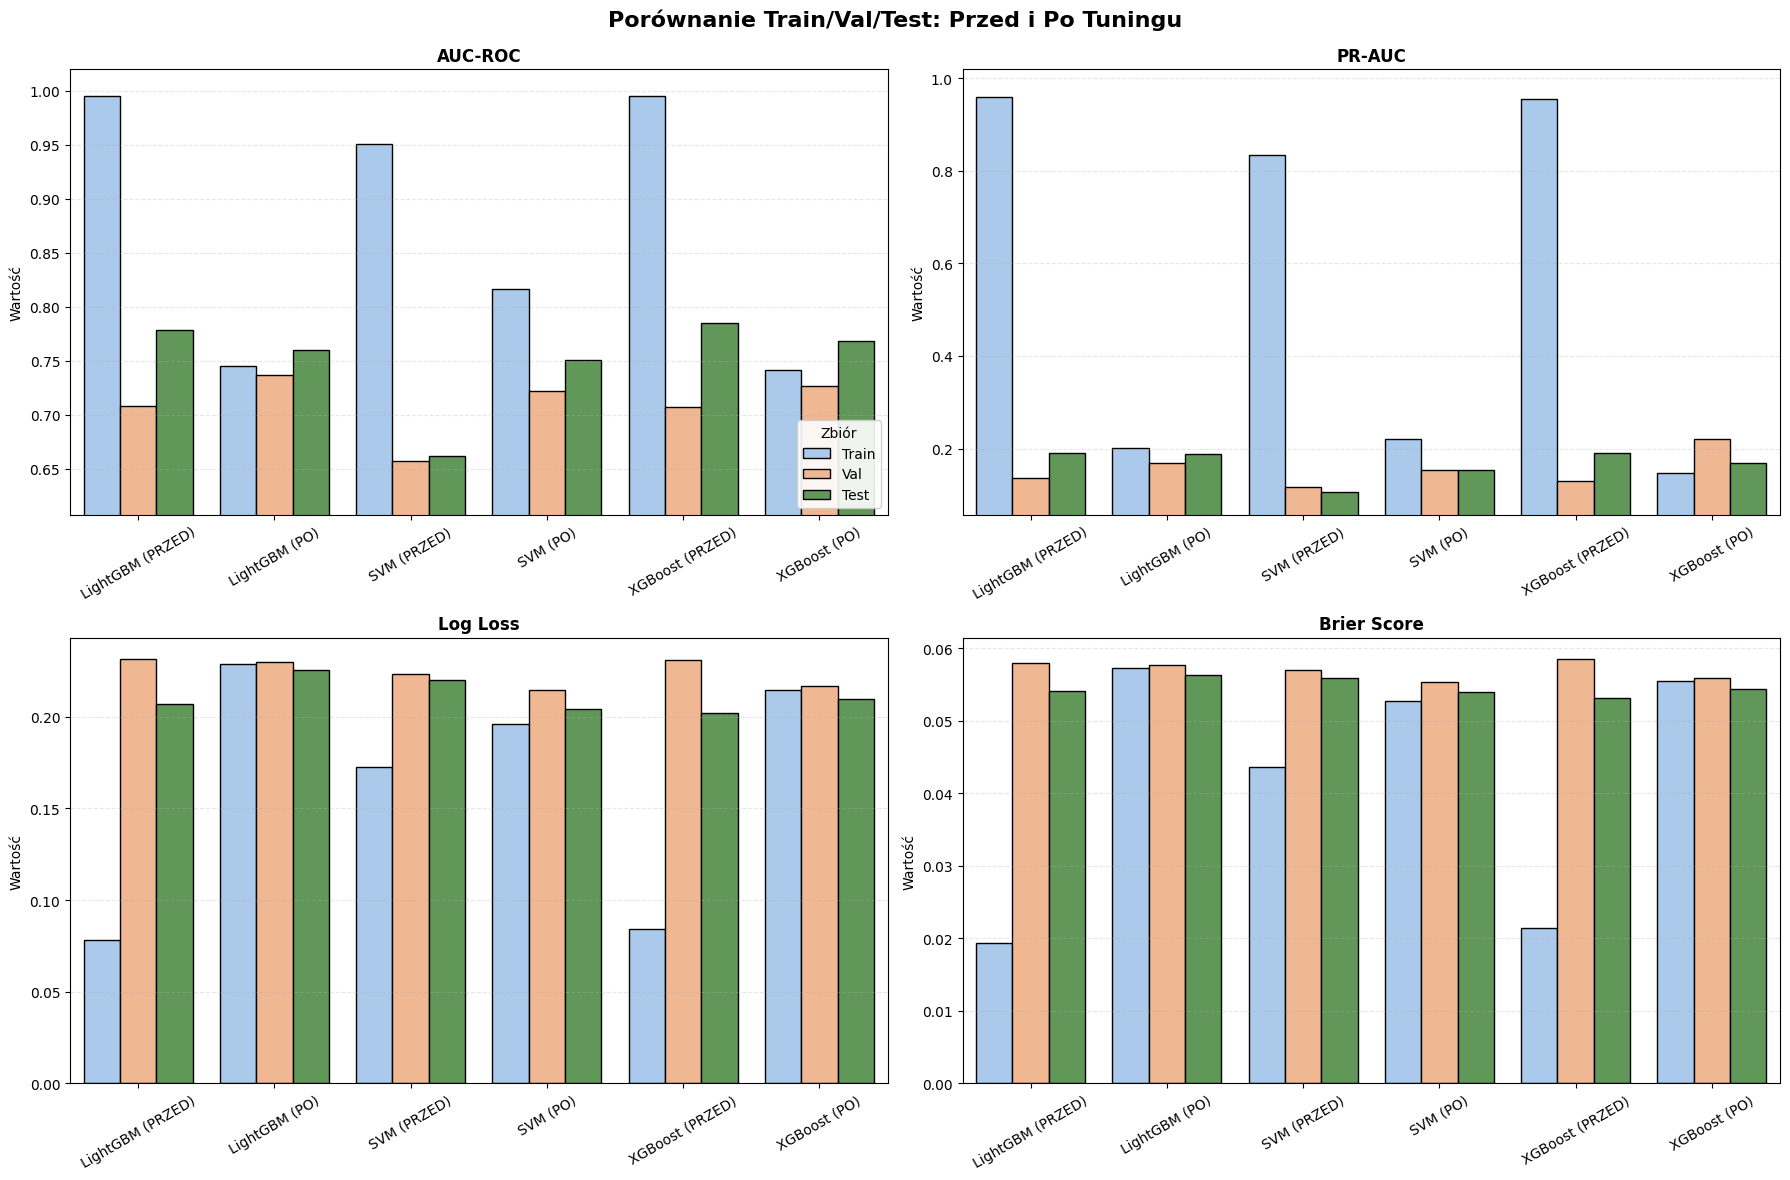

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Przygotowanie danych
def extract_meta(name):
    algo = 'SVM' if 'SVM' in name else 'XGBoost' if 'XGB' in name else 'LightGBM'
    split = 'Train' if 'Train' in name else 'Val' if 'Val' in name else 'Test'
    # Skrócenie nazw stanów dla czytelności wykresu
    state = 'PO' if ('Tuned' in name or 'BetterReg' in name) else 'PRZED'
    return pd.Series([algo, split, state])

df_viz = df_tuning.copy()
df_viz[['Algorithm', 'Split', 'State']] = df_viz['Model'].apply(extract_meta)

# Sortowanie
df_viz['Split'] = pd.Categorical(df_viz['Split'], categories=['Train', 'Val', 'Test'], ordered=True)
df_viz['State'] = pd.Categorical(df_viz['State'], categories=['PRZED', 'PO'], ordered=True)
df_viz = df_viz.sort_values(['Algorithm', 'State', 'Split'])

# 2. Tabela Overfittingu (Poprawiona logika indeksów)
gap_df = df_viz.pivot_table(
    index=['Algorithm', 'State'], 
    columns='Split', 
    values=['AUC-ROC', 'Log Loss']
)

# Spłaszczenie MultiIndexu kolumn do formatu "Metryka_Split"
gap_df.columns = [f"{col[0]}_{col[1]}" for col in gap_df.columns]

# Obliczenie różnic (Gap) na spłaszczonych kolumnach
gap_df['AUC Gap (Train-Test)'] = gap_df['AUC-ROC_Train'] - gap_df['AUC-ROC_Test']
gap_df['LogLoss Gap (Test-Train)'] = gap_df['Log Loss_Test'] - gap_df['Log Loss_Train']

# Wybór i wyświetlenie kolumn
cols_final = [
    'AUC-ROC_Train', 'AUC-ROC_Test', 'AUC Gap (Train-Test)',
    'Log Loss_Train', 'Log Loss_Test', 'LogLoss Gap (Test-Train)'
]

print("\n=== ANALIZA OVERFITTINGU (Train vs Test) ===")
print(gap_df[cols_final].round(4).to_string())

# 3. Wizualizacja
# Tworzymy nową kolumnę grupującą dla osi X (Algorytm + Stan)
df_viz['Group_Label'] = df_viz['Algorithm'] + ' (' + df_viz['State'].astype(str) + ')'

metrics = ['AUC-ROC', 'PR-AUC', 'Log Loss', 'Brier Score']
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Porównanie Train/Val/Test: Przed i Po Tuningu', fontsize=16, fontweight='bold')

axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    sns.barplot(
        data=df_viz,
        x='Group_Label',
        y=metric,
        hue='Split',
        palette={'Train': '#a1c9f4', 'Val': '#ffb482', 'Test': '#59a14f'},
        edgecolor='black',
        ax=ax
    )
    
    ax.set_title(metric, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Wartość')
    ax.tick_params(axis='x', rotation=30)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Skalowanie osi Y dla metryk z zakresu 0-1
    if metric in ['AUC-ROC', 'PR-AUC']:
        lower_lim = df_viz[metric].min() - 0.05
        ax.set_ylim(max(0, lower_lim), 1.02)
    
    # Legenda tylko na pierwszym wykresie
    if i == 0:
        ax.legend(title='Zbiór', loc='lower right', framealpha=0.9)
    else:
        if ax.get_legend():
            ax.get_legend().remove()

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

## Generowanie modelu złożonego

#### Seed Ensemble - Trening z różnymi seedami

In [41]:
print("SEED ENSEMBLE - Trening modeli (XGB, LGB, SVM) z różnymi seedami")

SEEDS = [42,1,2,3,6,70]

seed_predictions = {
    'xgb': {'train': [], 'val': [], 'test': []},
    'lgb': {'train': [], 'val': [], 'test': []},
    'svm': {'train': [], 'val': [], 'test': []}
}

for seed in SEEDS:
    print(f"\n{'='*80}")
    print(f"TRENING Z SEEDEM: {seed}")
    print(f"{'='*80}")
    
    print(f"\n🔹 XGBoost (seed={seed})")
    model_xgb = XGBClassifier(
        **xgb_best_params,
        random_state=seed,
        n_jobs=-1,
        enable_categorical=True,
        eval_metric='auc'
    )
    
    model_xgb.fit(
        X_train_final, y_train,
        eval_set=[(X_val_final, y_val)],
        verbose=False
    )
    
    xgb_train_pred = model_xgb.predict_proba(X_train_final)[:, 1]
    xgb_val_pred = model_xgb.predict_proba(X_val_final)[:, 1]
    xgb_test_pred = model_xgb.predict_proba(X_test_final)[:, 1]
    
    seed_predictions['xgb']['train'].append(xgb_train_pred)
    seed_predictions['xgb']['val'].append(xgb_val_pred)
    seed_predictions['xgb']['test'].append(xgb_test_pred)
    
    print(f"  AUC train: {roc_auc_score(y_train, xgb_train_pred):.6f}")
    print(f"  AUC val:   {roc_auc_score(y_val, xgb_val_pred):.6f}")
    print(f"  AUC test:  {roc_auc_score(y_test, xgb_test_pred):.6f}")
    
    print(f"\n🔹 LightGBM (seed={seed})")
    model_lgb = LGBMClassifier(
        **lgbm_best_params,
        random_state=seed,
        n_jobs=-1,
        verbose=-1
    )
    
    model_lgb.fit(
        X_train_final, y_train,
        eval_set=[(X_val_final, y_val)],
        eval_metric='auc'
    )
    
    lgb_train_pred = model_lgb.predict_proba(X_train_final)[:, 1]
    lgb_val_pred = model_lgb.predict_proba(X_val_final)[:, 1]
    lgb_test_pred = model_lgb.predict_proba(X_test_final)[:, 1]
    
    seed_predictions['lgb']['train'].append(lgb_train_pred)
    seed_predictions['lgb']['val'].append(lgb_val_pred)
    seed_predictions['lgb']['test'].append(lgb_test_pred)
    
    print(f"  AUC train: {roc_auc_score(y_train, lgb_train_pred):.6f}")
    print(f"  AUC val:   {roc_auc_score(y_val, lgb_val_pred):.6f}")
    print(f"  AUC test:  {roc_auc_score(y_test, lgb_test_pred):.6f}")
    
    print(f"\n🔹 SVM (seed={seed})")
    svm_params = study_svm.best_params
    
    model_svm = make_pipeline(
        preprocessor,
        SVC(
            C=svm_params['C'],
            gamma=svm_params['gamma'],
            class_weight=svm_params['class_weight'],
            kernel='rbf',
            probability=True,
            random_state=seed,
            cache_size=1000
        )
    )
    
    model_svm.fit(X_train_final, y_train)
    
    svm_train_pred = model_svm.predict_proba(X_train_final)[:, 1]
    svm_val_pred = model_svm.predict_proba(X_val_final)[:, 1]
    svm_test_pred = model_svm.predict_proba(X_test_final)[:, 1]
    
    seed_predictions['svm']['train'].append(svm_train_pred)
    seed_predictions['svm']['val'].append(svm_val_pred)
    seed_predictions['svm']['test'].append(svm_test_pred)
    
    print(f"  AUC train: {roc_auc_score(y_train, svm_train_pred):.6f}")
    print(f"  AUC val:   {roc_auc_score(y_val, svm_val_pred):.6f}")
    print(f"  AUC test:  {roc_auc_score(y_test, svm_test_pred):.6f}")



SEED ENSEMBLE - Trening modeli (XGB, LGB, SVM) z różnymi seedami

TRENING Z SEEDEM: 42

🔹 XGBoost (seed=42)


  AUC train: 0.741192
  AUC val:   0.726585
  AUC test:  0.767952

🔹 LightGBM (seed=42)
  AUC train: 0.782251
  AUC val:   0.703759
  AUC test:  0.728009

🔹 SVM (seed=42)
  AUC train: 0.816353
  AUC val:   0.722529
  AUC test:  0.751034

TRENING Z SEEDEM: 1

🔹 XGBoost (seed=1)
  AUC train: 0.735928
  AUC val:   0.727233
  AUC test:  0.764505

🔹 LightGBM (seed=1)
  AUC train: 0.783217
  AUC val:   0.701095
  AUC test:  0.725768

🔹 SVM (seed=1)
  AUC train: 0.816353
  AUC val:   0.722481
  AUC test:  0.751034

TRENING Z SEEDEM: 2

🔹 XGBoost (seed=2)
  AUC train: 0.737257
  AUC val:   0.723033
  AUC test:  0.764455

🔹 LightGBM (seed=2)
  AUC train: 0.782359
  AUC val:   0.703735
  AUC test:  0.725350

🔹 SVM (seed=2)
  AUC train: 0.816353
  AUC val:   0.721761
  AUC test:  0.750591

TRENING Z SEEDEM: 3

🔹 XGBoost (seed=3)
  AUC train: 0.741170
  AUC val:   0.722985
  AUC test:  0.772409

🔹 LightGBM (seed=3)
  AUC train: 0.784026
  AUC val:   0.710360
  AUC test:  0.727073

🔹 SVM (seed=3)
 

In [42]:
print("\n" + "="*80)
print("UŚREDNIANIE PREDYKCJI Z SEED ENSEMBLE (XGB, LGB, SVM)")
print("="*80)

xgb_train_pred = np.mean(seed_predictions['xgb']['train'], axis=0)
xgb_val_pred = np.mean(seed_predictions['xgb']['val'], axis=0)
xgb_test_pred = np.mean(seed_predictions['xgb']['test'], axis=0)

lgb_train_pred = np.mean(seed_predictions['lgb']['train'], axis=0)
lgb_val_pred = np.mean(seed_predictions['lgb']['val'], axis=0)
lgb_test_pred = np.mean(seed_predictions['lgb']['test'], axis=0)

svm_train_pred = np.mean(seed_predictions['svm']['train'], axis=0)
svm_val_pred = np.mean(seed_predictions['svm']['val'], axis=0)
svm_test_pred = np.mean(seed_predictions['svm']['test'], axis=0)

print("\n📊 Wyniki po uśrednieniu Seed Ensemble:\n")

print("XGBoost Seed Ensemble:")
print(f"  AUC train: {roc_auc_score(y_train, xgb_train_pred):.6f}")
print(f"  AUC val:   {roc_auc_score(y_val, xgb_val_pred):.6f}")
print(f"  AUC test:  {roc_auc_score(y_test, xgb_test_pred):.6f}")

print("\nLightGBM Seed Ensemble:")
print(f"  AUC train: {roc_auc_score(y_train, lgb_train_pred):.6f}")
print(f"  AUC val:   {roc_auc_score(y_val, lgb_val_pred):.6f}")
print(f"  AUC test:  {roc_auc_score(y_test, lgb_test_pred):.6f}")

print("\nSVM Seed Ensemble:")
print(f"  AUC train: {roc_auc_score(y_train, svm_train_pred):.6f}")
print(f"  AUC val:   {roc_auc_score(y_val, svm_val_pred):.6f}")
print(f"  AUC test:  {roc_auc_score(y_test, svm_test_pred):.6f}")

for model_name in ['xgb', 'lgb', 'svm']:
    single_seed_val = seed_predictions[model_name]['val'][0]
    ensemble_val = np.mean(seed_predictions[model_name]['val'], axis=0)
    
    single_auc = roc_auc_score(y_val, single_seed_val)
    ensemble_auc = roc_auc_score(y_val, ensemble_val)
    improvement = (ensemble_auc - single_auc) * 10000 
    
    print(f"\n{model_name.upper()}:")
    print(f"  Single seed AUC val: {single_auc:.6f}")
    print(f"  Seed Ensemble AUC val: {ensemble_auc:.6f}")
    print(f"  Improvement:           {improvement:+.2f} bps")




UŚREDNIANIE PREDYKCJI Z SEED ENSEMBLE (XGB, LGB, SVM)

📊 Wyniki po uśrednieniu Seed Ensemble:

XGBoost Seed Ensemble:
  AUC train: 0.740086
  AUC val:   0.725961
  AUC test:  0.764800

LightGBM Seed Ensemble:
  AUC train: 0.783736
  AUC val:   0.707143
  AUC test:  0.728009

SVM Seed Ensemble:
  AUC train: 0.816353
  AUC val:   0.722481
  AUC test:  0.751034

XGB:
  Single seed AUC val: 0.726585
  Seed Ensemble AUC val: 0.725961
  Improvement:           -6.24 bps

LGB:
  Single seed AUC val: 0.703759
  Seed Ensemble AUC val: 0.707143
  Improvement:           +33.84 bps

SVM:
  Single seed AUC val: 0.722529
  Seed Ensemble AUC val: 0.722481
  Improvement:           -0.48 bps


#### Blending i Stacking z Seed Ensemble

In [43]:
val_preds_matrix = np.column_stack([xgb_val_pred, lgb_val_pred, svm_val_pred])
test_preds_matrix = np.column_stack([xgb_test_pred, lgb_test_pred, svm_test_pred])
train_preds_matrix = np.column_stack([xgb_train_pred, lgb_train_pred, svm_train_pred])

best_score = -1
best_weights = [0, 0, 0]

np.random.seed(42)
for _ in range(5000):
    weights = np.random.dirichlet(np.ones(3), size=1)[0]
    current_pred = np.average(val_preds_matrix, axis=1, weights=weights)
    score = roc_auc_score(y_val, current_pred)
    
    if score > best_score:
        best_score = score
        best_weights = weights

print(f"Znalezione wagi (Random Search): XGB={best_weights[0]:.4f}, LGB={best_weights[1]:.4f}, SVM={best_weights[2]:.4f}")

blend_train = np.average(train_preds_matrix, axis=1, weights=best_weights)
blend_val   = np.average(val_preds_matrix, axis=1, weights=best_weights)
blend_test  = np.average(test_preds_matrix, axis=1, weights=best_weights)

print(f"\nOptymalny Blend AUC train: {roc_auc_score(y_train, blend_train):.6f}")
print(f"Optymalny Blend AUC val:   {roc_auc_score(y_val, blend_val):.6f}")
print(f"Optymalny Blend AUC test:  {roc_auc_score(y_test, blend_test):.6f}")

Znalezione wagi (Random Search): XGB=0.1937, LGB=0.7278, SVM=0.0785

Optymalny Blend AUC train: 0.792636
Optymalny Blend AUC val:   0.733906
Optymalny Blend AUC test:  0.764086


In [44]:
print("\n" + "="*80)
print("STACKING - Meta-model z Logistic Regression (Seed Ensemble)")
print("="*80)

# Przygotowanie danych dla meta-modelu (SVM zamiast CatBoost)
meta_X_train = np.vstack([xgb_val_pred, lgb_val_pred, svm_val_pred]).T
meta_y_train = y_val.copy()

print("\nTrening meta-modelu (Logistic Regression)...")
meta_model = make_pipeline(StandardScaler(), LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42))
meta_model.fit(meta_X_train, meta_y_train)

# Przewidywania dla wszystkich zbiorów
meta_X_train_orig = np.vstack([xgb_train_pred, lgb_train_pred, svm_train_pred]).T
stack_train_pred = meta_model.predict_proba(meta_X_train_orig)[:,1]

meta_val_pred = meta_model.predict_proba(meta_X_train)[:,1]

meta_X_test = np.vstack([xgb_test_pred, lgb_test_pred, svm_test_pred]).T
stack_test_pred = meta_model.predict_proba(meta_X_test)[:,1]

print(f"\nWyniki Stackingu:")
print(f"  AUC train: {roc_auc_score(y_train, stack_train_pred):.6f}")
print(f"  AUC val:   {roc_auc_score(meta_y_train, meta_val_pred):.6f}")
print(f"  AUC test:  {roc_auc_score(y_test, stack_test_pred):.6f}")
print("="*80)


STACKING - Meta-model z Logistic Regression (Seed Ensemble)

Trening meta-modelu (Logistic Regression)...

Wyniki Stackingu:
  AUC train: 0.789086
  AUC val:   0.732994
  AUC test:  0.766696


In [45]:
print("\n" + "="*80)
print("PODSUMOWANIE WYNIKÓW - Wszystkie modele")
print("="*80)

import pandas as pd
from sklearn.metrics import precision_recall_curve, auc as auc_score, log_loss, brier_score_loss, roc_curve, roc_auc_score

def calculate_ks_statistic(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    return max(tpr - fpr)

def calculate_pr_auc(y_true, y_pred_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    return auc_score(recall, precision)

results = pd.DataFrame({
    "model": ["XGBoost (Seed Ens)", "LightGBM (Seed Ens)", "SVM (Seed Ens)", "Blending", "Stacking"],
    # AUC-ROC
    "auc_train": [
        roc_auc_score(y_train, xgb_train_pred),
        roc_auc_score(y_train, lgb_train_pred),
        roc_auc_score(y_train, svm_train_pred),
        roc_auc_score(y_train, blend_train),
        roc_auc_score(y_train, stack_train_pred)
    ],
    "auc_val": [
        roc_auc_score(y_val, xgb_val_pred),
        roc_auc_score(y_val, lgb_val_pred),
        roc_auc_score(y_val, svm_val_pred),
        roc_auc_score(y_val, blend_val),
        roc_auc_score(meta_y_train, meta_val_pred)
    ],
    "auc_test": [
        roc_auc_score(y_test, xgb_test_pred),
        roc_auc_score(y_test, lgb_test_pred),
        roc_auc_score(y_test, svm_test_pred),
        roc_auc_score(y_test, blend_test),
        roc_auc_score(y_test, stack_test_pred)
    ],
    # PR-AUC
    "pr_auc_train": [
        calculate_pr_auc(y_train, xgb_train_pred),
        calculate_pr_auc(y_train, lgb_train_pred),
        calculate_pr_auc(y_train, svm_train_pred),
        calculate_pr_auc(y_train, blend_train),
        calculate_pr_auc(y_train, stack_train_pred)
    ],
    "pr_auc_val": [
        calculate_pr_auc(y_val, xgb_val_pred),
        calculate_pr_auc(y_val, lgb_val_pred),
        calculate_pr_auc(y_val, svm_val_pred),
        calculate_pr_auc(y_val, blend_val),
        calculate_pr_auc(meta_y_train, meta_val_pred)
    ],
    "pr_auc_test": [
        calculate_pr_auc(y_test, xgb_test_pred),
        calculate_pr_auc(y_test, lgb_test_pred),
        calculate_pr_auc(y_test, svm_test_pred),
        calculate_pr_auc(y_test, blend_test),
        calculate_pr_auc(y_test, stack_test_pred)
    ],
    # KS Statistic
    "ks_train": [
        calculate_ks_statistic(y_train, xgb_train_pred),
        calculate_ks_statistic(y_train, lgb_train_pred),
        calculate_ks_statistic(y_train, svm_train_pred),
        calculate_ks_statistic(y_train, blend_train),
        calculate_ks_statistic(y_train, stack_train_pred)
    ],
    "ks_val": [
        calculate_ks_statistic(y_val, xgb_val_pred),
        calculate_ks_statistic(y_val, lgb_val_pred),
        calculate_ks_statistic(y_val, svm_val_pred),
        calculate_ks_statistic(y_val, blend_val),
        calculate_ks_statistic(meta_y_train, meta_val_pred)
    ],
    "ks_test": [
        calculate_ks_statistic(y_test, xgb_test_pred),
        calculate_ks_statistic(y_test, lgb_test_pred),
        calculate_ks_statistic(y_test, svm_test_pred),
        calculate_ks_statistic(y_test, blend_test),
        calculate_ks_statistic(y_test, stack_test_pred)
    ],
    # Log Loss
    "logloss_train": [
        log_loss(y_train, xgb_train_pred),
        log_loss(y_train, lgb_train_pred),
        log_loss(y_train, svm_train_pred),
        log_loss(y_train, blend_train),
        log_loss(y_train, stack_train_pred)
    ],
    "logloss_val": [
        log_loss(y_val, xgb_val_pred),
        log_loss(y_val, lgb_val_pred),
        log_loss(y_val, svm_val_pred),
        log_loss(y_val, blend_val),
        log_loss(meta_y_train, meta_val_pred)
    ],
    "logloss_test": [
        log_loss(y_test, xgb_test_pred),
        log_loss(y_test, lgb_test_pred),
        log_loss(y_test, svm_test_pred),
        log_loss(y_test, blend_test),
        log_loss(y_test, stack_test_pred)
    ],
    # Brier Score
    "brier_train": [
        brier_score_loss(y_train, xgb_train_pred),
        brier_score_loss(y_train, lgb_train_pred),
        brier_score_loss(y_train, svm_train_pred),
        brier_score_loss(y_train, blend_train),
        brier_score_loss(y_train, stack_train_pred)
    ],
    "brier_val": [
        brier_score_loss(y_val, xgb_val_pred),
        brier_score_loss(y_val, lgb_val_pred),
        brier_score_loss(y_val, svm_val_pred),
        brier_score_loss(y_val, blend_val),
        brier_score_loss(meta_y_train, meta_val_pred)
    ],
    "brier_test": [
        brier_score_loss(y_test, xgb_test_pred),
        brier_score_loss(y_test, lgb_test_pred),
        brier_score_loss(y_test, svm_test_pred),
        brier_score_loss(y_test, blend_test),
        brier_score_loss(y_test, stack_test_pred)
    ]
})

print("\n" + results.round(4).to_string(index=False))




PODSUMOWANIE WYNIKÓW - Wszystkie modele



              model  auc_train  auc_val  auc_test  pr_auc_train  pr_auc_val  pr_auc_test  ks_train  ks_val  ks_test  logloss_train  logloss_val  logloss_test  brier_train  brier_val  brier_test
 XGBoost (Seed Ens)     0.7401   0.7260    0.7648        0.1505      0.1952       0.1444    0.3983  0.3986   0.4468         0.2150       0.2167        0.2106       0.0556     0.0559      0.0545
LightGBM (Seed Ens)     0.7837   0.7071    0.7280        0.2252      0.1449       0.1533    0.4555  0.4232   0.4043         0.2261       0.2283        0.2241       0.0569     0.0575      0.0561
     SVM (Seed Ens)     0.8164   0.7225    0.7510        0.2200      0.1528       0.1548    0.4883  0.3976   0.4297         0.1959       0.2144        0.2041       0.0528     0.0553      0.0539
           Blending     0.7926   0.7339    0.7641        0.2076      0.1637       0.1397    0.4814  0.4872   0.4622         0.2197       0.2230        0.2185       0.0561     0.0568      0.0554
           Stacking     0.789


📊 SZCZEGÓŁOWE METRYKI NA ZBIORZE TESTOWYM:
              Model  AUC-ROC   PR-AUC  KS Stat  Log Loss    Brier
 XGBoost (Seed Ens) 0.764800 0.144367 0.446809  0.210620 0.054452
LightGBM (Seed Ens) 0.728009 0.153309 0.404255  0.224064 0.056064
     SVM (Seed Ens) 0.751034 0.154757 0.429669  0.204063 0.053923
           Blending 0.764086 0.139650 0.462175  0.218507 0.055405
           Stacking 0.766696 0.141546 0.463948  0.204354 0.053989


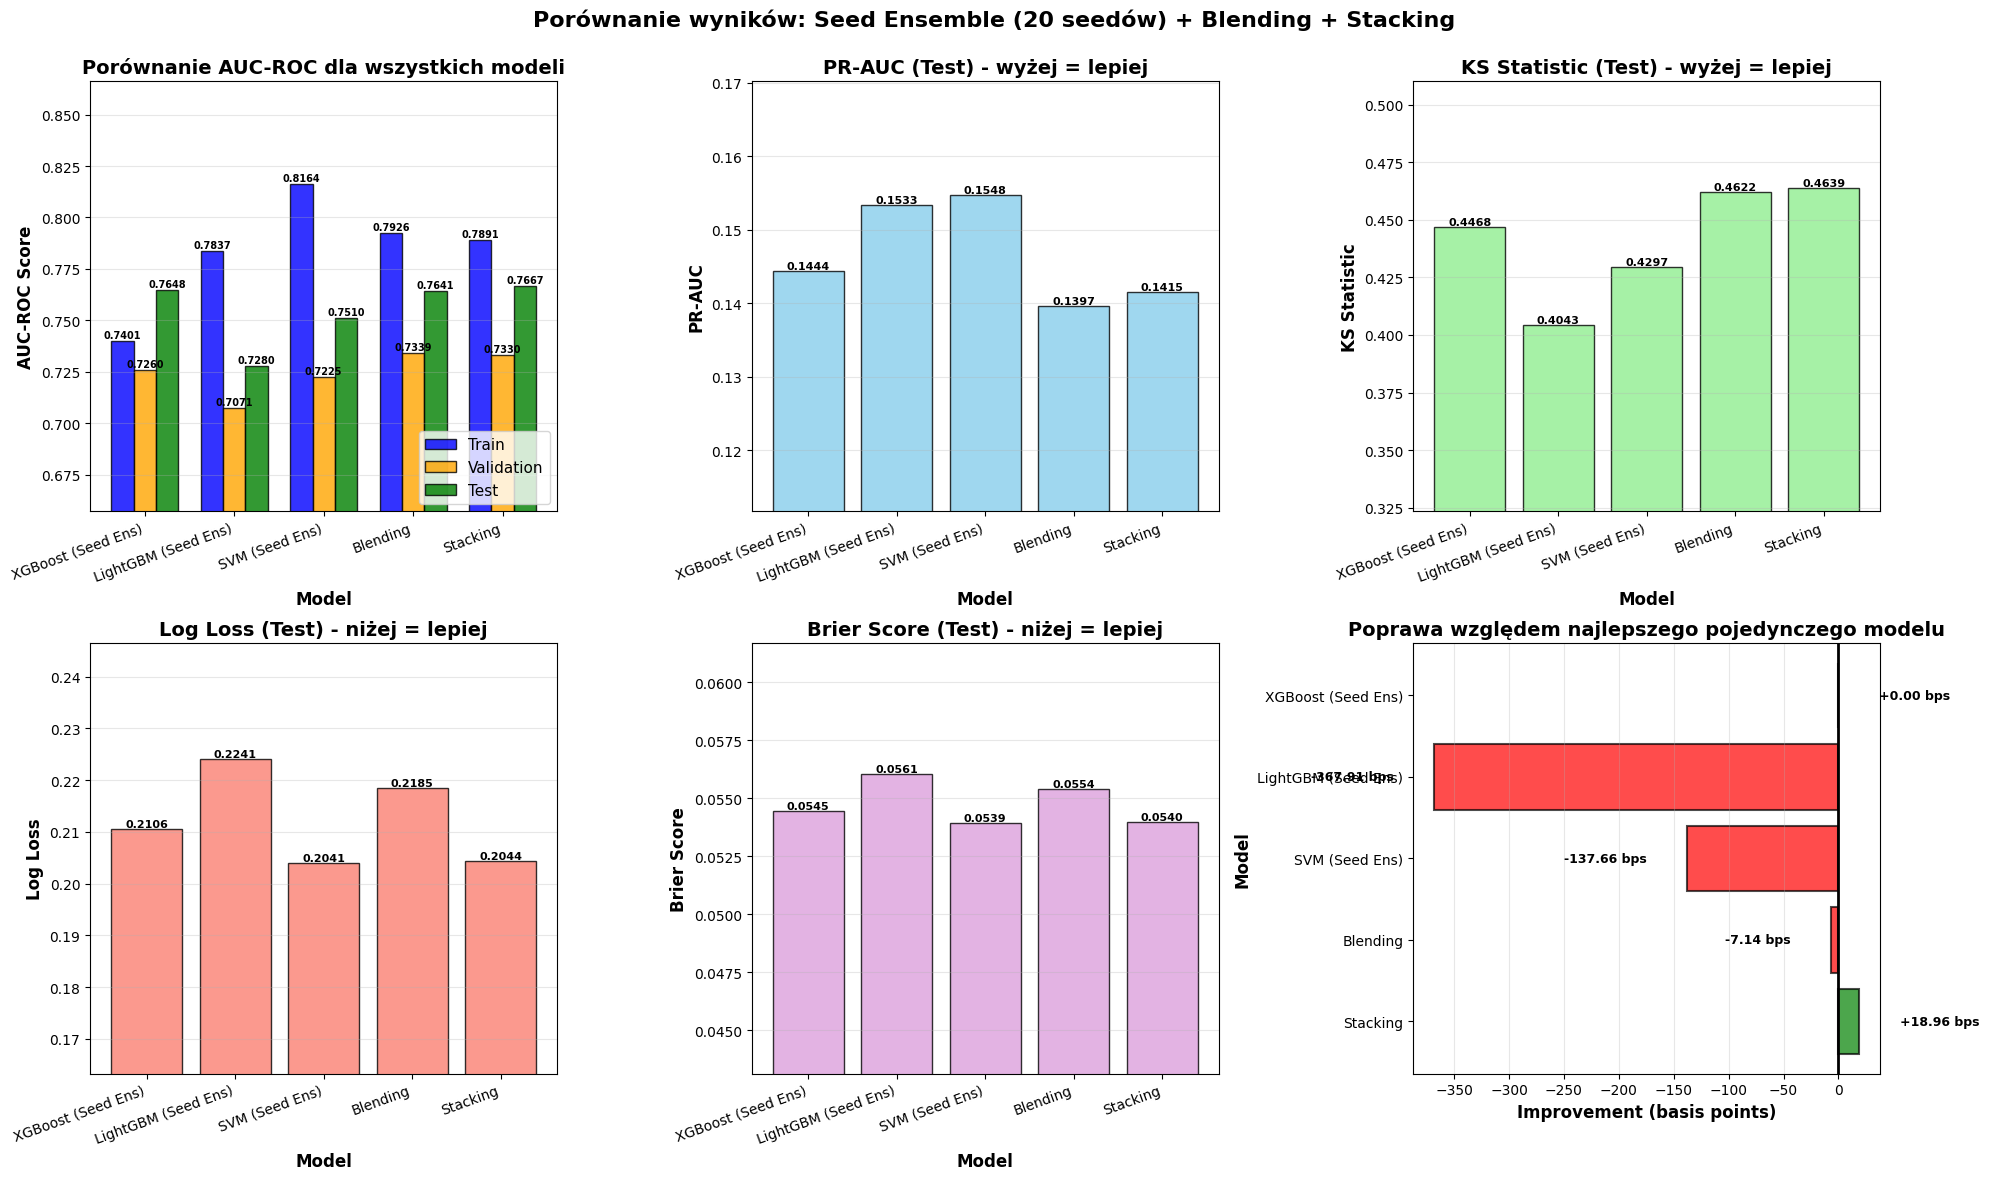

In [47]:

# Wyświetl szczegółową tabelę z wszystkimi metrykami TEST
print("\n📊 SZCZEGÓŁOWE METRYKI NA ZBIORZE TESTOWYM:")
print("="*100)
detailed_table = pd.DataFrame({
    'Model': results['model'],
    'AUC-ROC': results['auc_test'],
    'PR-AUC': results['pr_auc_test'],
    'KS Stat': results['ks_test'],
    'Log Loss': results['logloss_test'],
    'Brier': results['brier_test']
})
print(detailed_table.to_string(index=False))
print("="*100)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Wykres 1: Porównanie AUC dla wszystkich zbiorów
x_pos = np.arange(len(results))
width = 0.25

axes[0, 0].bar(x_pos - width, results['auc_train'], width, label='Train', alpha=0.8, color='blue', edgecolor='black')
axes[0, 0].bar(x_pos, results['auc_val'], width, label='Validation', alpha=0.8, color='orange', edgecolor='black')
axes[0, 0].bar(x_pos + width, results['auc_test'], width, label='Test', alpha=0.8, color='green', edgecolor='black')

axes[0, 0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('AUC-ROC Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Porównanie AUC-ROC dla wszystkich modeli', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(results['model'], rotation=20, ha='right', fontsize=10)
axes[0, 0].legend(fontsize=11, loc='lower right')
axes[0, 0].grid(alpha=0.3, axis='y')

# Automatyczne skalowanie osi Y
min_auc = min(results['auc_train'].min(), results['auc_val'].min(), results['auc_test'].min())
max_auc = max(results['auc_train'].max(), results['auc_val'].max(), results['auc_test'].max())
axes[0, 0].set_ylim([min_auc - 0.05, max_auc + 0.05])

# Dodaj wartości na słupkach
for i, (train, val, test) in enumerate(zip(results['auc_train'], results['auc_val'], results['auc_test'])):
    axes[0, 0].text(i - width, train + 0.0005, f'{train:.4f}', ha='center', va='bottom', fontsize=7, fontweight='bold')
    axes[0, 0].text(i, val + 0.0005, f'{val:.4f}', ha='center', va='bottom', fontsize=7, fontweight='bold')
    axes[0, 0].text(i + width, test + 0.0005, f'{test:.4f}', ha='center', va='bottom', fontsize=7, fontweight='bold')

# Wykres 2: PR-AUC (Test)
axes[0, 1].bar(results['model'], results['pr_auc_test'], alpha=0.8, color='skyblue', edgecolor='black')
axes[0, 1].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('PR-AUC', fontsize=12, fontweight='bold')
axes[0, 1].set_title('PR-AUC (Test) - wyżej = lepiej', fontsize=14, fontweight='bold')
axes[0, 1].set_xticklabels(results['model'], rotation=20, ha='right', fontsize=10)
axes[0, 1].grid(alpha=0.3, axis='y')
axes[0, 1].set_ylim([results['pr_auc_test'].min()*0.8, results['pr_auc_test'].max()*1.1])
for i, val in enumerate(results['pr_auc_test']):
    axes[0, 1].text(i, val, f'{val:.4f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Wykres 3: KS Statistic (Test)
axes[0, 2].bar(results['model'], results['ks_test'], alpha=0.8, color='lightgreen', edgecolor='black')
axes[0, 2].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('KS Statistic', fontsize=12, fontweight='bold')
axes[0, 2].set_title('KS Statistic (Test) - wyżej = lepiej', fontsize=14, fontweight='bold')
axes[0, 2].set_xticklabels(results['model'], rotation=20, ha='right', fontsize=10)
axes[0, 2].grid(alpha=0.3, axis='y')
axes[0, 2].set_ylim([results['ks_test'].min()*0.8, results['ks_test'].max()*1.1])
for i, val in enumerate(results['ks_test']):
    axes[0, 2].text(i, val, f'{val:.4f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Wykres 4: Log Loss (Test)
axes[1, 0].bar(results['model'], results['logloss_test'], alpha=0.8, color='salmon', edgecolor='black')
axes[1, 0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Log Loss', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Log Loss (Test) - niżej = lepiej', fontsize=14, fontweight='bold')
axes[1, 0].set_xticklabels(results['model'], rotation=20, ha='right', fontsize=10)
axes[1, 0].grid(alpha=0.3, axis='y')
axes[1, 0].set_ylim([results['logloss_test'].min()*0.8, results['logloss_test'].max()*1.1])
for i, val in enumerate(results['logloss_test']):
    axes[1, 0].text(i, val, f'{val:.4f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Wykres 5: Brier Score (Test)
axes[1, 1].bar(results['model'], results['brier_test'], alpha=0.8, color='plum', edgecolor='black')
axes[1, 1].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Brier Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Brier Score (Test) - niżej = lepiej', fontsize=14, fontweight='bold')
axes[1, 1].set_xticklabels(results['model'], rotation=20, ha='right', fontsize=10)
axes[1, 1].grid(alpha=0.3, axis='y')
axes[1, 1].set_ylim([results['brier_test'].min()*0.8, results['brier_test'].max()*1.1])
for i, val in enumerate(results['brier_test']):
    axes[1, 1].text(i, val, f'{val:.4f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Wykres 6: Różnice w AUC test względem najlepszego pojedynczego modelu
best_single_auc = results.iloc[:3]['auc_test'].max()
auc_improvements = (results['auc_test'] - best_single_auc) * 10000  # w punktach bazowych

colors = ['green' if x >= 0 else 'red' for x in auc_improvements]
bars = axes[1, 2].barh(results['model'], auc_improvements, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 2].axvline(0, color='black', linestyle='-', linewidth=2)
axes[1, 2].set_xlabel('Improvement (basis points)', fontsize=12, fontweight='bold')
axes[1, 2].set_ylabel('Model', fontsize=12, fontweight='bold')
axes[1, 2].set_title('Poprawa względem najlepszego pojedynczego modelu', fontsize=14, fontweight='bold')
axes[1, 2].invert_yaxis()
axes[1, 2].grid(alpha=0.3, axis='x')

# Dodaj wartości na słupkach
for i, (model, imp) in enumerate(zip(results['model'], auc_improvements)):
    offset = max(abs(auc_improvements)) * 0.1 
    x_pos_text = imp + offset if imp >= 0 else imp - offset
    ha_align = 'left' if imp >= 0 else 'right'
    axes[1, 2].text(x_pos_text, i, f'{imp:+.2f} bps', 
                va='center', ha=ha_align, fontsize=9, fontweight='bold')

plt.suptitle('Porównanie wyników: Seed Ensemble (20 seedów) + Blending + Stacking', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.92)

# Część 3

In [34]:
xgb_best_params ={'n_estimators': 117,
 'learning_rate': 0.03797788161249129,
 'max_depth': 4,
 'min_child_weight': 18,
 'subsample': 0.5160593594275805,
 'colsample_bytree': 0.7970575476702365,
 'reg_lambda': 1.4923198080600548,
 'reg_alpha': 5.688397256225556,
 'gamma': 3.3431623430230695}

In [35]:
X_train_final = pd.read_csv('data/X_train_final.csv')
X_val_final = pd.read_csv('data/X_val_final.csv')
X_test_final = pd.read_csv('data/X_test_final.csv')
y_train = pd.read_csv('data/y_train.csv').iloc[:, 0]
y_val = pd.read_csv('data/y_val.csv').iloc[:, 0]
y_test = pd.read_csv('data/y_test.csv').iloc[:, 0]

In [36]:
selected_cols = ['wsk_liczba_dni_istnienia',
 'Srodki_trwale',
 'Srodki_pieniezne',
 'Kapital_wlasny',
 'Zobowiazania_rezerwy',
 'Zobowiazania_dostaw_uslug_12m',
 'przychody_sprzedazy',
 'pozostale_przychody_oper',
 'koszty_operacyjne_pozostale',
 'koszty_operacyjne',
 'RP_przeplywy_operacyjne',
 'RP_amortyzacja',
 'wsk_marza_ebitda_2',
 'wsk_ogolnego_zadluzenia_1',
 'wsk_ROE_brutto',
 'wsk_rotacja_zobowiazan_dostaw_uslug',
 'wsk_poziom_kapitalu_obrotowego_netto',
 'wsk_udzial_zob_biez_sprzedaz_2',
 'wsk_zast_kapitalu_obcego',
 'New_Debt_Ratio',
 'New_Equity_Multiplier',
 'Cycle_Gap',
 'Rule_Golden',
 'Altman_T1_WorkingCapital',
 'PKD_Dzial']

X_train_final = X_train_final[selected_cols]
X_test_final = X_test_final[selected_cols]
X_val_final = X_val_final[selected_cols]

In [37]:
X_val_selected = X_val_final
X_train_selected = X_train_final
X_test_selected = X_test_final

In [38]:
xgb_final = XGBClassifier(
    n_estimators=int(xgb_best_params['n_estimators']),
    learning_rate=xgb_best_params['learning_rate'],
    max_depth=int(xgb_best_params['max_depth']),
    min_child_weight=int(xgb_best_params['min_child_weight']),
    subsample=xgb_best_params['subsample'],
    colsample_bytree=xgb_best_params['colsample_bytree'],
    reg_lambda=xgb_best_params['reg_lambda'],
    reg_alpha=xgb_best_params['reg_alpha'],
    gamma=xgb_best_params['gamma'],
    enable_categorical=True,
    eval_metric='auc',
    random_state=42
)
xgb_final.fit(X_train_final, y_train)
y_pred_proba_test = xgb_final.predict_proba(X_test_final)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
j_scores = tpr - fpr
best_threshold = thresholds[j_scores.argmax()]
print(best_threshold)

0.060374606400728226


In [39]:
print("="*80)
print("SELEKCJA 6 SKRAJNYCH PRZYPADKÓW ZE ZBIORU TESTOWEGO")
print("="*80)


y_pred_proba_test = xgb_final.predict_proba(X_test_final)[:, 1]
y_pred_test = (y_pred_proba_test >= best_threshold).astype(int)

idx_highest = np.argmax(y_pred_proba_test)
print(f"\n1. HIGHEST PREDICTED DEFAULT:")
print(f"   Index: {idx_highest}, Prob: {y_pred_proba_test[idx_highest]:.4f}, True: {y_test.iloc[idx_highest]}")

idx_lowest = np.argmin(y_pred_proba_test)
print(f"\n2. LOWEST PREDICTED DEFAULT:")
print(f"   Index: {idx_lowest}, Prob: {y_pred_proba_test[idx_lowest]:.4f}, True: {y_test.iloc[idx_lowest]}")

tp_mask = (y_pred_test == 1) & (y_test.values == 1)
if tp_mask.sum() > 0:
    tp_probs = y_pred_proba_test[tp_mask]
    tp_indices = np.where(tp_mask)[0]
    idx_tp = tp_indices[np.argmax(tp_probs)]
else:
    mask_default = y_test.values == 1
    idx_tp = np.where(mask_default)[0][np.argmax(y_pred_proba_test[mask_default])]
print(f"\n3. TRUE POSITIVE (HIGH CONFIDENCE):")
print(f"   Index: {idx_tp}, Prob: {y_pred_proba_test[idx_tp]:.4f}, True: {y_test.iloc[idx_tp]}")

fp_mask = (y_pred_test == 1) & (y_test.values == 0)
if fp_mask.sum() > 0:
    fp_probs = y_pred_proba_test[fp_mask]
    fp_indices = np.where(fp_mask)[0]
    idx_fp = fp_indices[np.argmax(fp_probs)]
else:
    mask_no_default = y_test.values == 0
    idx_fp = np.where(mask_no_default)[0][np.argmax(y_pred_proba_test[mask_no_default])]
print(f"\n4. FALSE POSITIVE (HIGH CONFIDENCE):")
print(f"   Index: {idx_fp}, Prob: {y_pred_proba_test[idx_fp]:.4f}, True: {y_test.iloc[idx_fp]}")

fn_mask = (y_pred_test == 0) & (y_test.values == 1)
if fn_mask.sum() > 0:
    fn_probs = y_pred_proba_test[fn_mask]
    fn_indices = np.where(fn_mask)[0]
    idx_fn = fn_indices[np.argmin(fn_probs)]
else:
    mask_default = y_test.values == 1
    idx_fn = np.where(mask_default)[0][np.argmin(y_pred_proba_test[mask_default])]
print(f"\n5. FALSE NEGATIVE (HIGH CONFIDENCE):")
print(f"   Index: {idx_fn}, Prob: {y_pred_proba_test[idx_fn]:.4f}, True: {y_test.iloc[idx_fn]}")

boundary_distances = np.abs(y_pred_proba_test - 0.5)
idx_boundary = np.argmin(boundary_distances)
print(f"\n6. CLOSEST TO DECISION BOUNDARY:")
print(f"   Index: {idx_boundary}, Prob: {y_pred_proba_test[idx_boundary]:.4f}, True: {y_test.iloc[idx_boundary]}")

extreme_indices = [idx_highest, idx_lowest, idx_tp, idx_fp, idx_fn, idx_boundary]
extreme_labels = [
    "Highest Prob", 
    "Lowest Prob",
    "True Positive" if tp_mask.sum() > 0 else "High Prob (y=1)",
    "False Positive" if fp_mask.sum() > 0 else "High Prob (y=0)",
    "False Negative" if fn_mask.sum() > 0 else "Low Prob (y=1)",
    "Boundary Case"
]


SELEKCJA 6 SKRAJNYCH PRZYPADKÓW ZE ZBIORU TESTOWEGO

1. HIGHEST PREDICTED DEFAULT:
   Index: 114, Prob: 0.1261, True: 0

2. LOWEST PREDICTED DEFAULT:
   Index: 3, Prob: 0.0333, True: 0

3. TRUE POSITIVE (HIGH CONFIDENCE):
   Index: 449, Prob: 0.1261, True: 1

4. FALSE POSITIVE (HIGH CONFIDENCE):
   Index: 114, Prob: 0.1261, True: 0

5. FALSE NEGATIVE (HIGH CONFIDENCE):
   Index: 42, Prob: 0.0445, True: 1

6. CLOSEST TO DECISION BOUNDARY:
   Index: 114, Prob: 0.1261, True: 0


In [40]:
explainer = shap.TreeExplainer(xgb_final)
X_extreme_cases = X_test_selected.iloc[extreme_indices]
shap_values_extreme = explainer.shap_values(X_extreme_cases)
print("SHAP values calculated successfully.")

SHAP values calculated successfully.


### Analiza najlepszego modelu black box

#### Selekcja skrajnych przypadków ze zbioru walidacyjnego



#### Lokalna analiza Shap


1. Highest Prob (Index: 114)
   Prawdopodobieństwo: 0.1261
   Prawdziwa wartość: 0
   Predykcja: 1


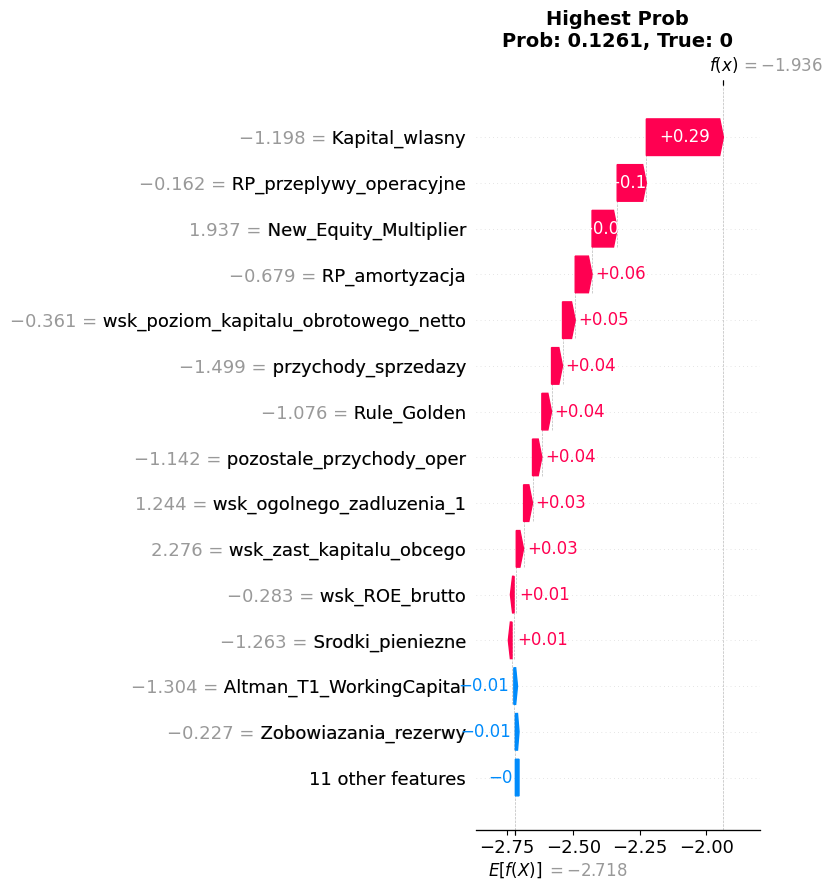


2. Lowest Prob (Index: 3)
   Prawdopodobieństwo: 0.0333
   Prawdziwa wartość: 0
   Predykcja: 0


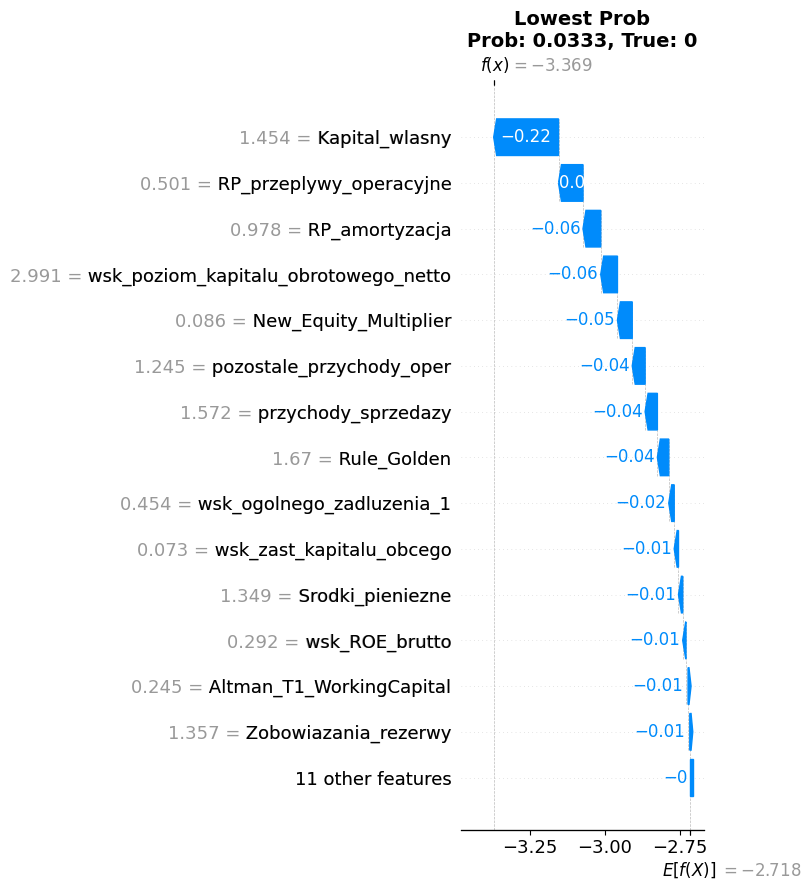


3. True Positive (Index: 449)
   Prawdopodobieństwo: 0.1261
   Prawdziwa wartość: 1
   Predykcja: 1


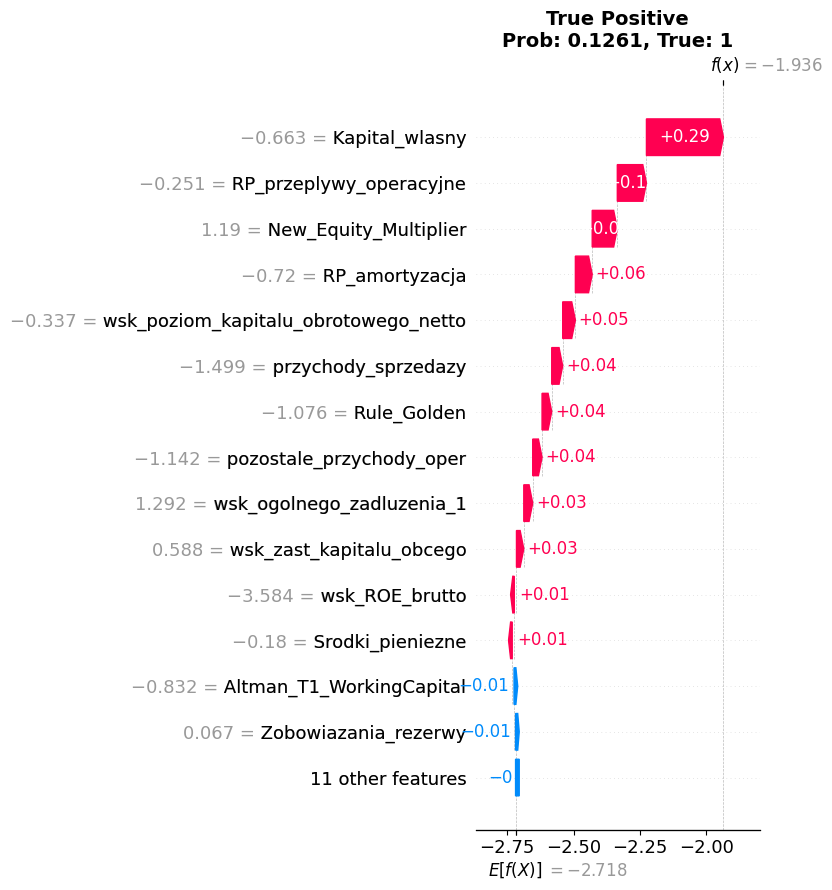


4. False Positive (Index: 114)
   Prawdopodobieństwo: 0.1261
   Prawdziwa wartość: 0
   Predykcja: 1


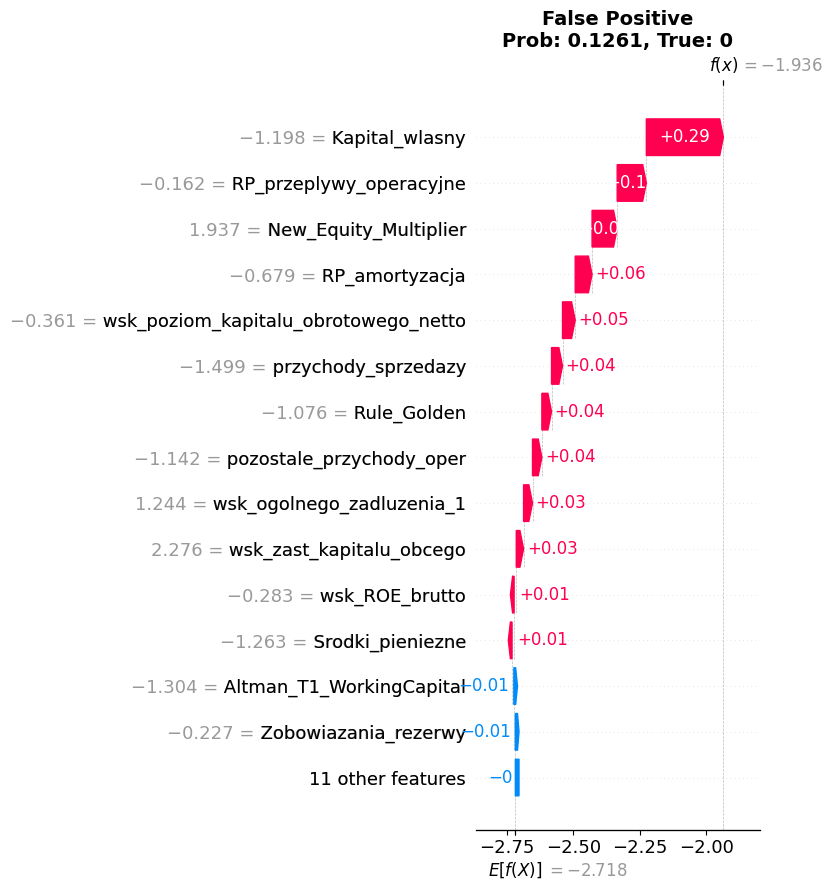


5. False Negative (Index: 42)
   Prawdopodobieństwo: 0.0445
   Prawdziwa wartość: 1
   Predykcja: 0


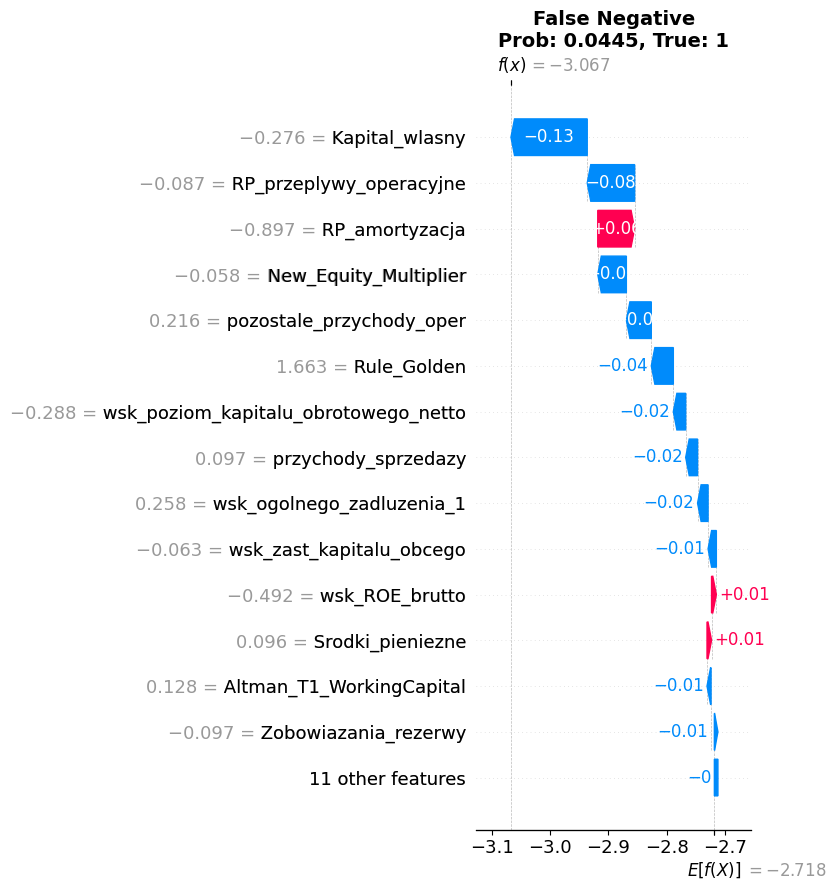


6. Boundary Case (Index: 114)
   Prawdopodobieństwo: 0.1261
   Prawdziwa wartość: 0
   Predykcja: 1


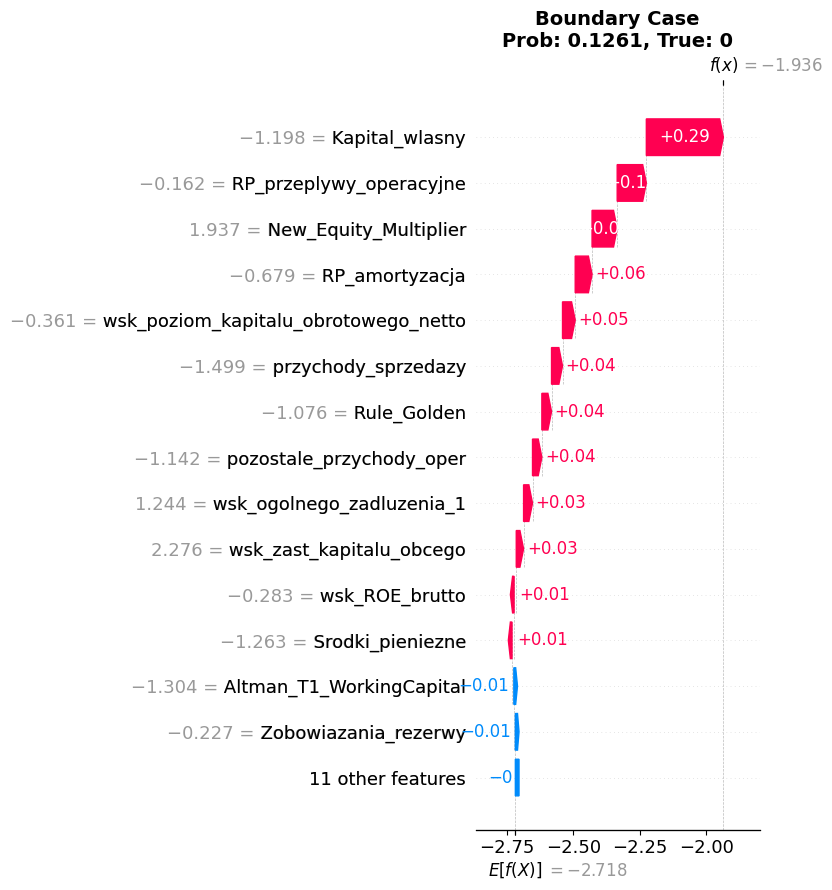

In [57]:
for i, (idx, label) in enumerate(zip(extreme_indices, extreme_labels)):
    print(f"\n{i+1}. {label} (Index: {idx})")
    print(f"   Prawdopodobieństwo: {y_pred_proba_test[idx]:.4f}")
    print(f"   Prawdziwa wartość: {y_test.iloc[idx]}")
    print(f"   Predykcja: {y_pred_test[idx]}")
    
    # Waterfall plot dla pojedynczego przypadku
    fig, ax = plt.subplots(figsize=(12, 8))
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_extreme[i],
            base_values=explainer.expected_value,
            data=X_extreme_cases.iloc[i].values,
            feature_names=X_extreme_cases.columns.tolist()
        ),
        max_display=15,
        show=False
    )
    plt.title(f"{label}\nProb: {y_pred_proba_test[idx]:.4f}, True: {y_test.iloc[idx]}", 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


1. Highest Prob


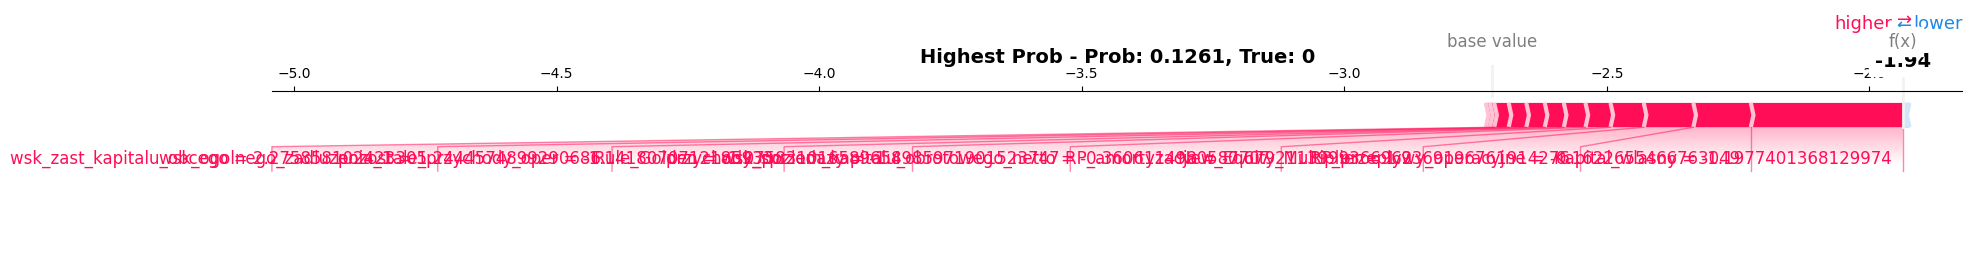


2. Lowest Prob


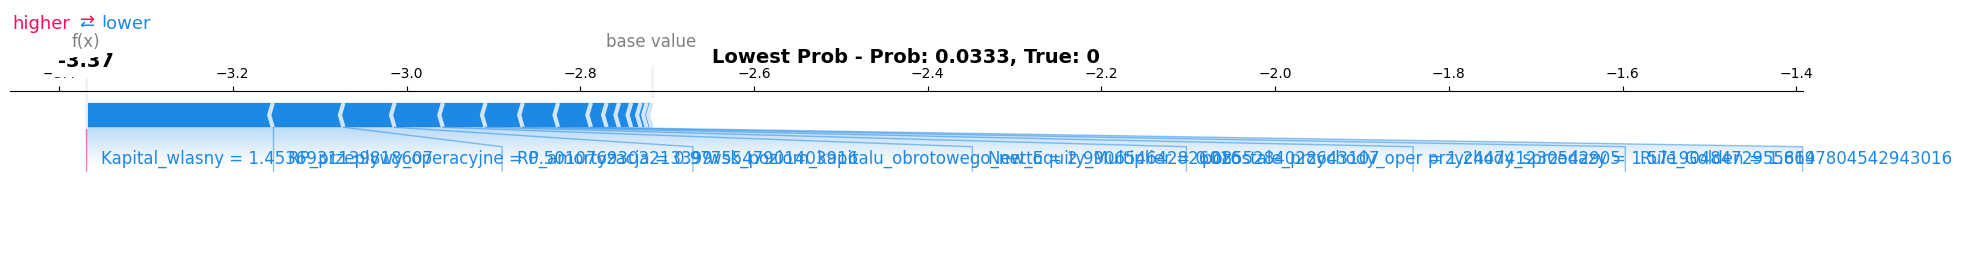


3. True Positive



4. False Positive


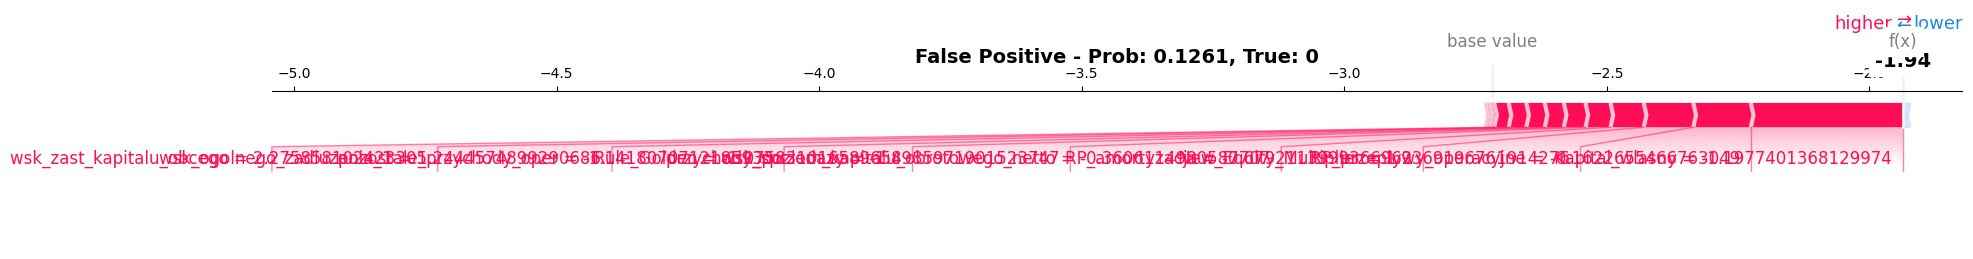


5. False Negative


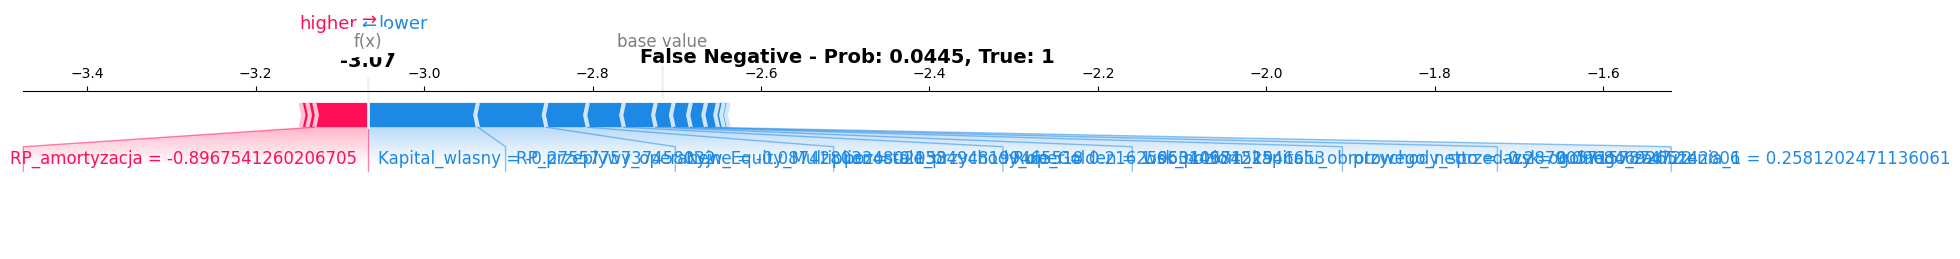


6. Boundary Case


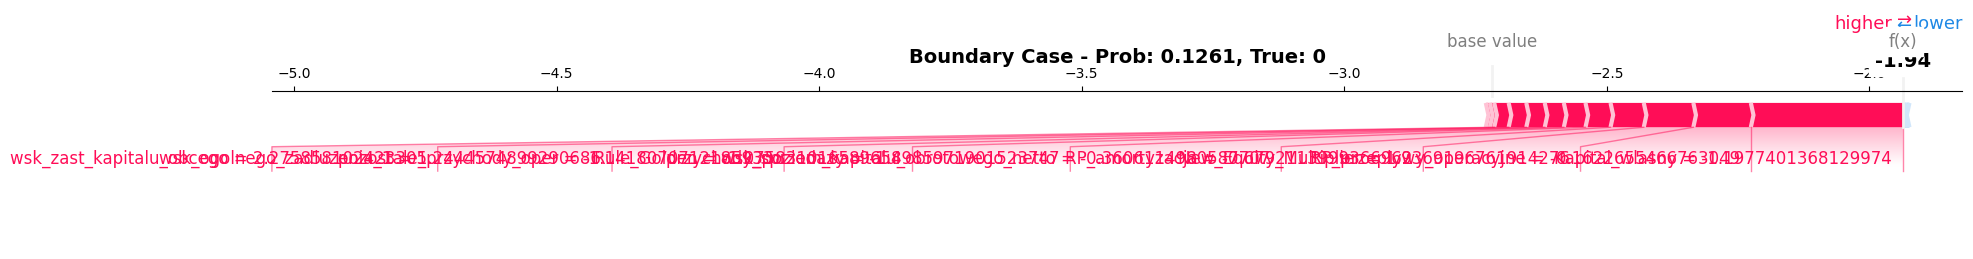

In [42]:
for i, (idx, label) in enumerate(zip(extreme_indices, extreme_labels)):
    print(f"\n{i+1}. {label}")
    shap.force_plot(
        explainer.expected_value,
        shap_values_extreme[i],
        X_extreme_cases.iloc[i],
        matplotlib=True,
        show=False,
        figsize=(20, 3)
    )
    plt.title(f"{label} - Prob: {y_pred_proba_test[idx]:.4f}, True: {y_test.iloc[idx]}", 
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()


1. Highest Prob (Index: 114)


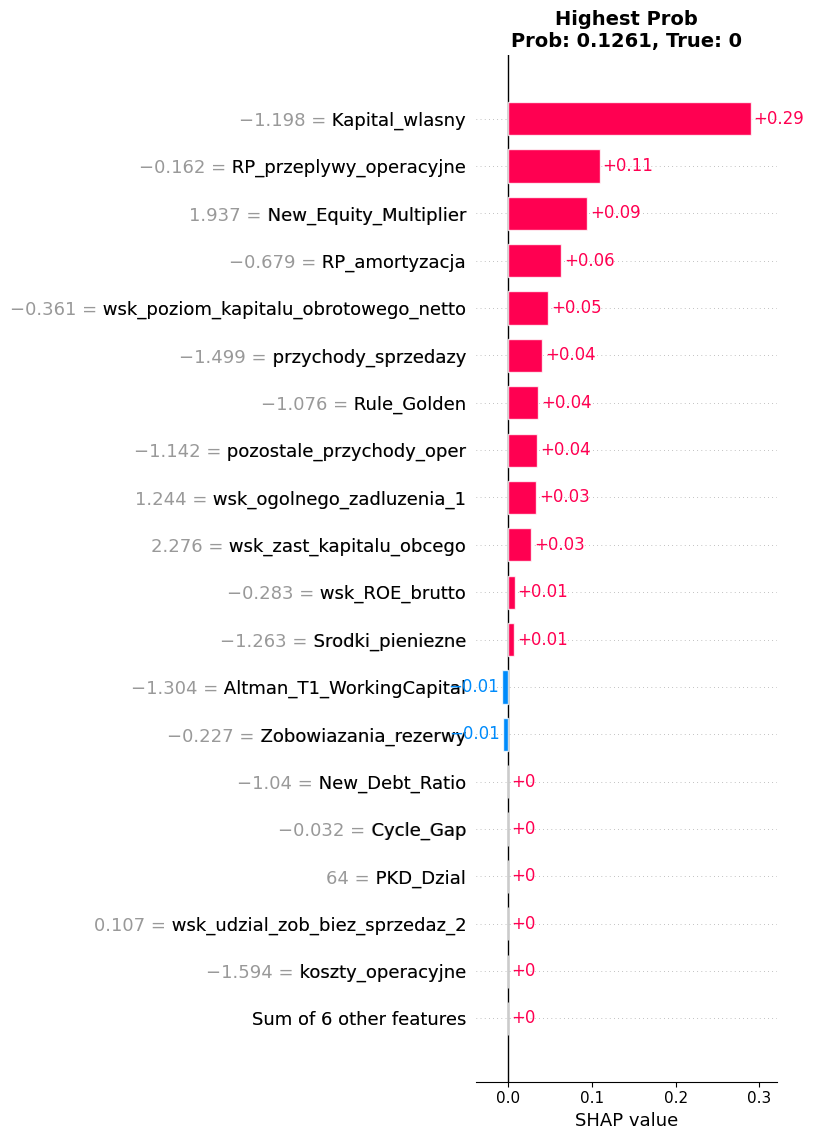


2. Lowest Prob (Index: 3)


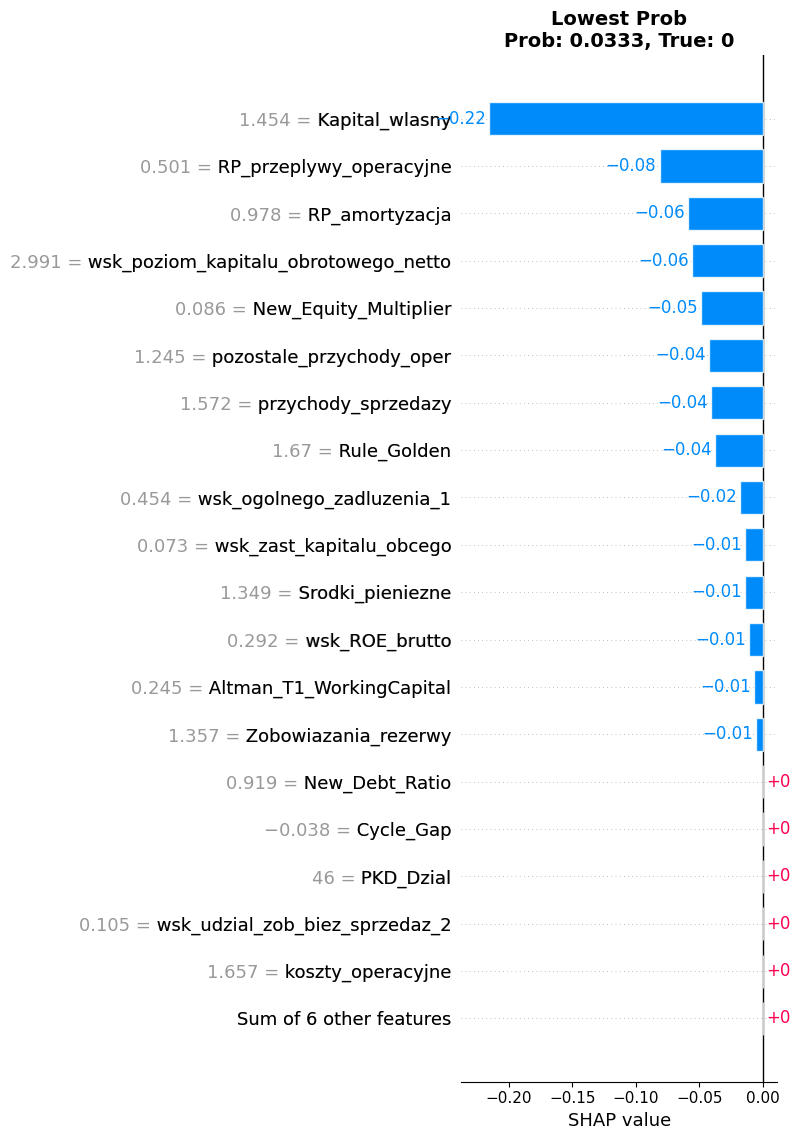


3. True Positive (Index: 449)


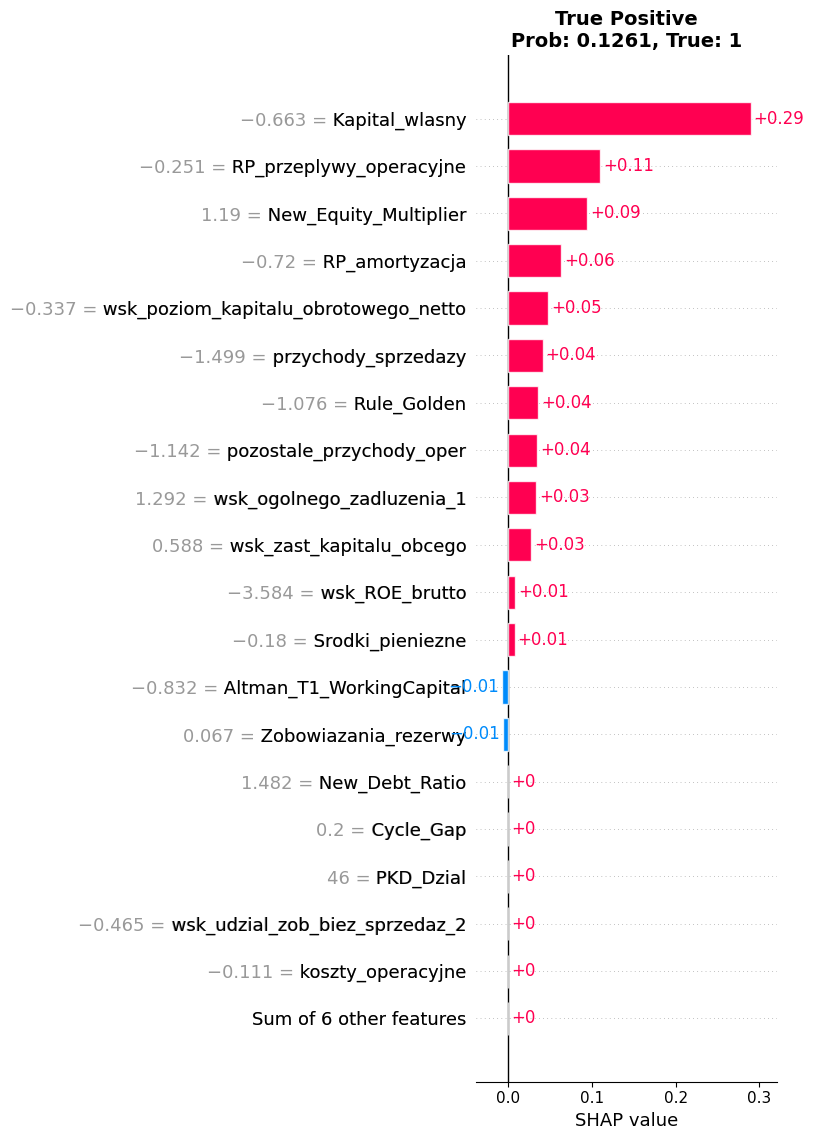


4. False Positive (Index: 114)


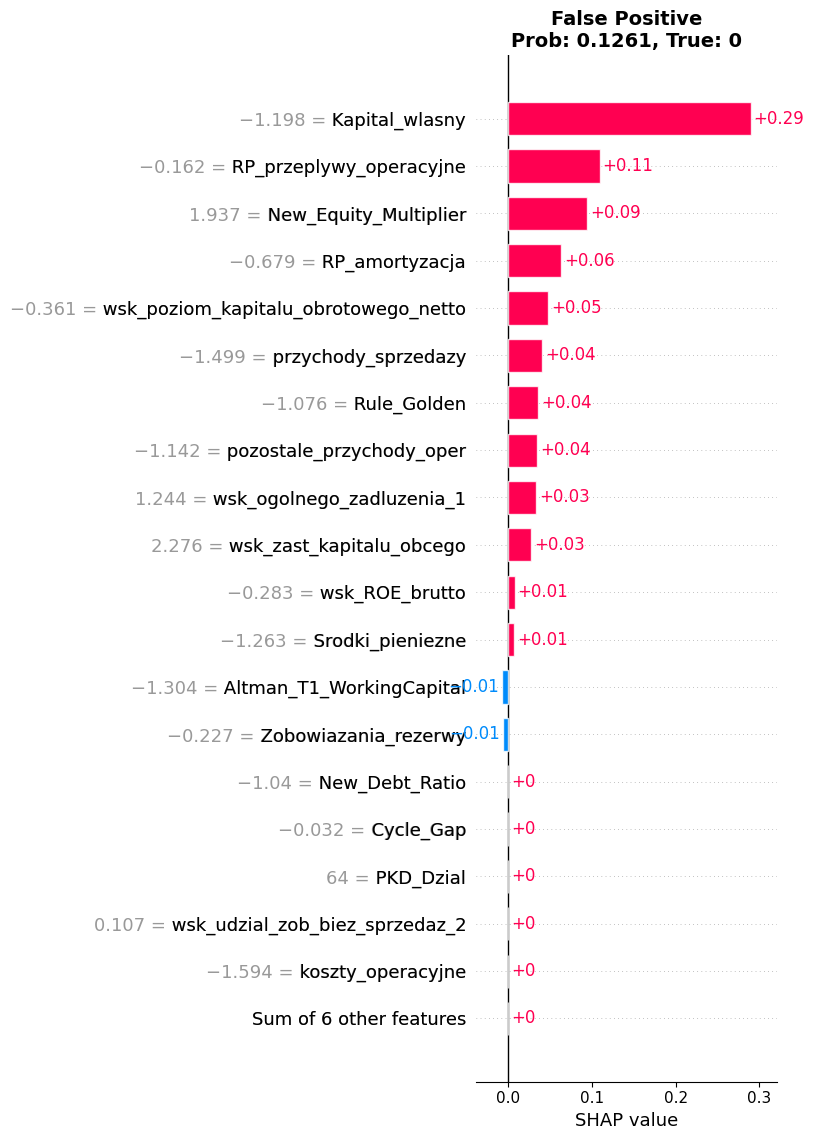


5. False Negative (Index: 42)


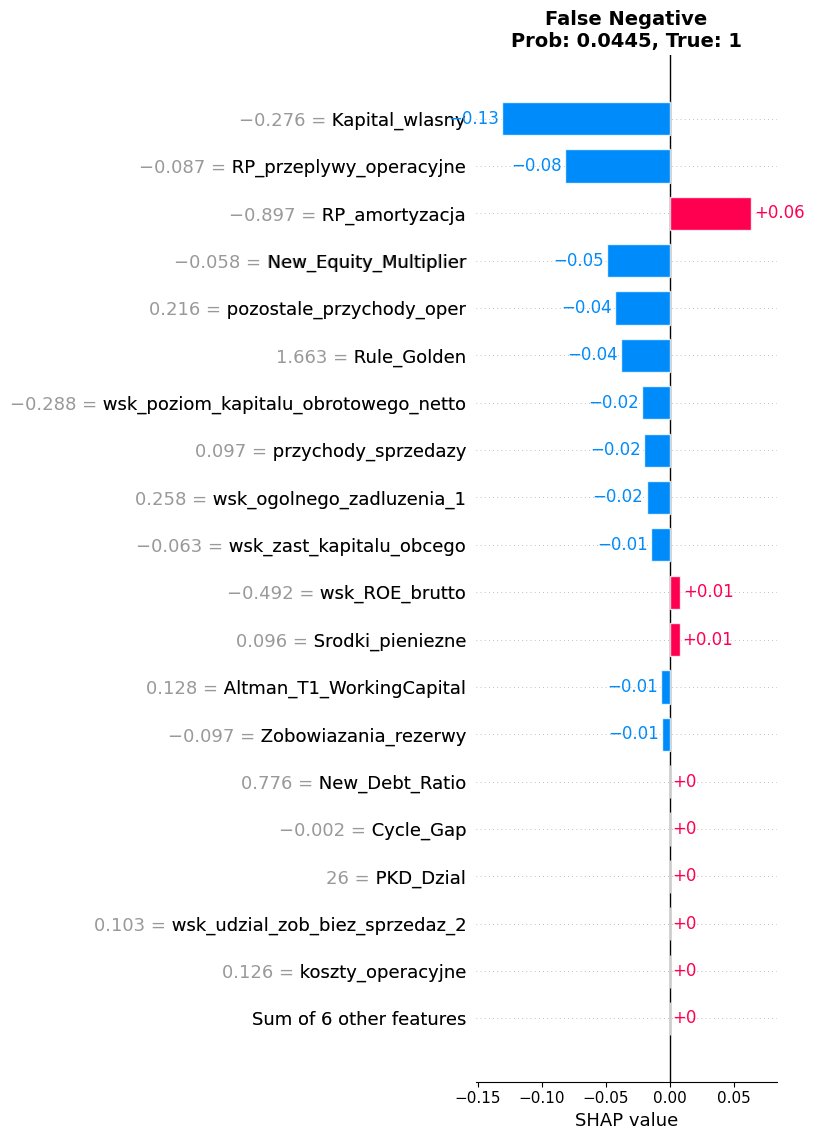


6. Boundary Case (Index: 114)


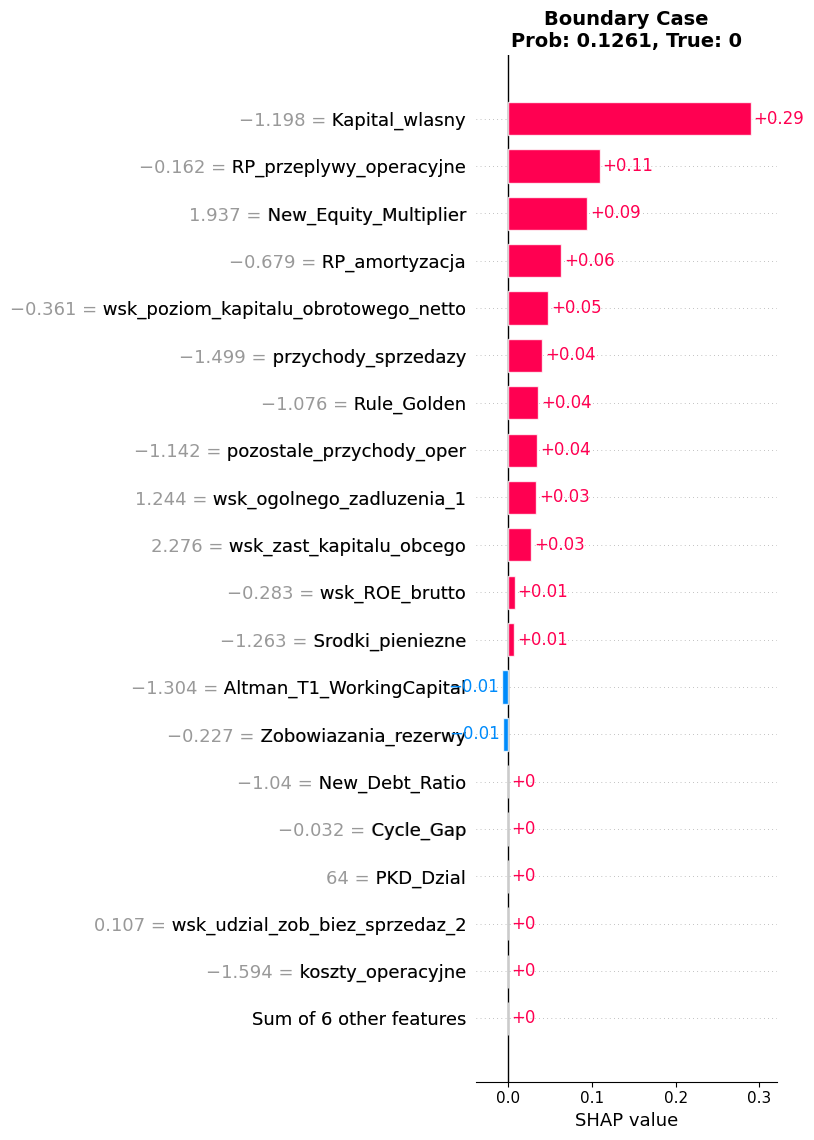

In [43]:
for i, (idx, label) in enumerate(zip(extreme_indices, extreme_labels)):
    print(f"\n{i+1}. {label} (Index: {idx})")
    
    fig, ax = plt.subplots(figsize=(12, 8))
    shap_exp = shap.Explanation(
        values=shap_values_extreme[i],
        base_values=explainer.expected_value,
        data=X_extreme_cases.iloc[i].values,
        feature_names=X_extreme_cases.columns.tolist()
    )
    
    shap.plots.bar(shap_exp, max_display=20, show=False)
    plt.title(f"{label}\nProb: {y_pred_proba_test[idx]:.4f}, True: {y_test.iloc[idx]}", 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

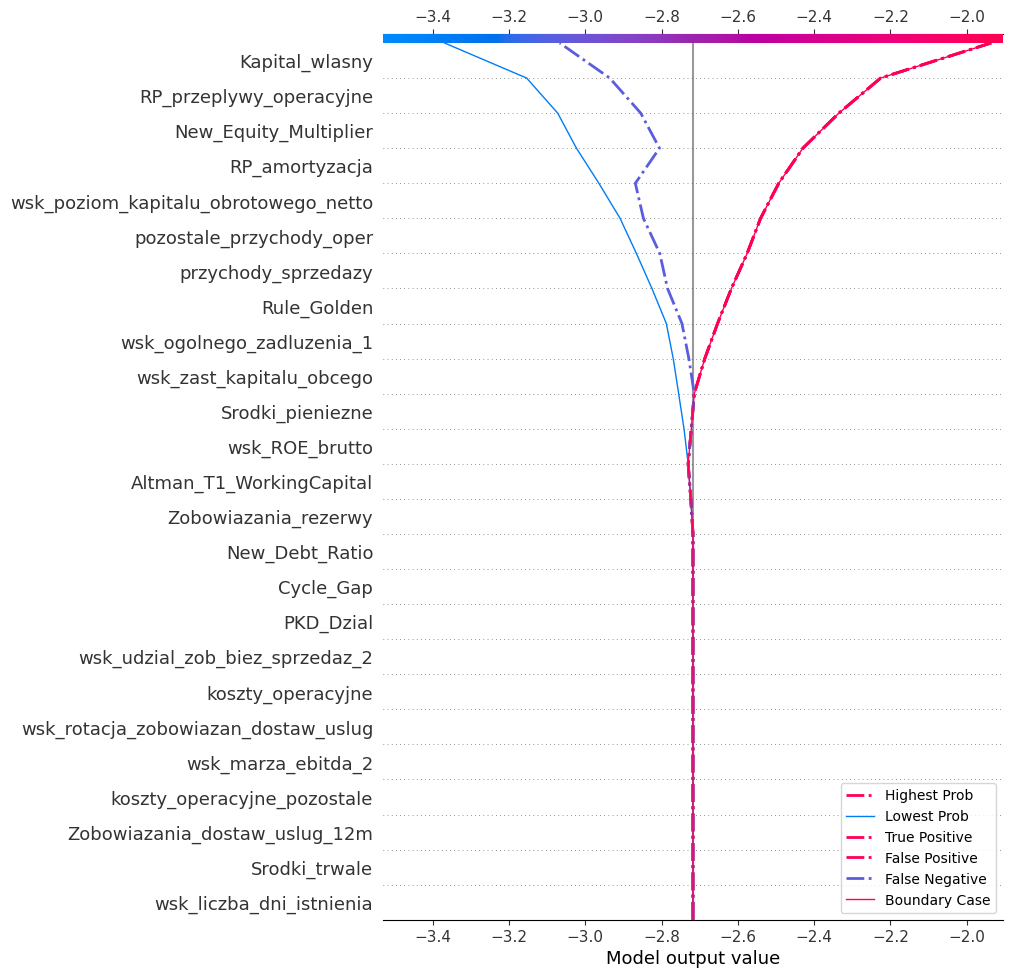

In [44]:

fig = plt.figure(figsize=(18, 12))
shap.decision_plot(
    explainer.expected_value,
    shap_values_extreme,
    X_extreme_cases,
    feature_names=X_extreme_cases.columns.tolist(),
    legend_labels=extreme_labels,
    legend_location='lower right',
    highlight=[0, 2, 3, 4],
    feature_display_range=slice(-1, -31, -1) 
)

plt.show()


#### Globalna analiza modelu

In [45]:
print(f"\nObliczanie wartości SHAP dla {len(X_test_selected)} obserwacji...")
shap_values_raw = explainer.shap_values(X_test_selected)

# Dla klasyfikacji binarnej, wybierz wartości dla klasy pozytywnej (default=1)
if isinstance(shap_values_raw, list):
    shap_values = shap_values_raw[1]  # Klasa pozytywna
    print(f"✓ Wybrano wartości SHAP dla klasy pozytywnej (default=1)")
else:
    shap_values = shap_values_raw

# Sprawdź i ustaw expected_value
if isinstance(explainer.expected_value, list):
    expected_value = explainer.expected_value[1]  # Dla klasy pozytywnej
else:
    expected_value = explainer.expected_value

print(f"✓ Obliczono wartości SHAP dla {len(X_test_selected)} obserwacji")
print(f"  Kształt shap_values: {shap_values.shape}")
print(f"  Expected value: {expected_value:.4f}")



Obliczanie wartości SHAP dla 600 obserwacji...
✓ Obliczono wartości SHAP dla 600 obserwacji
  Kształt shap_values: (600, 25)
  Expected value: -2.7178


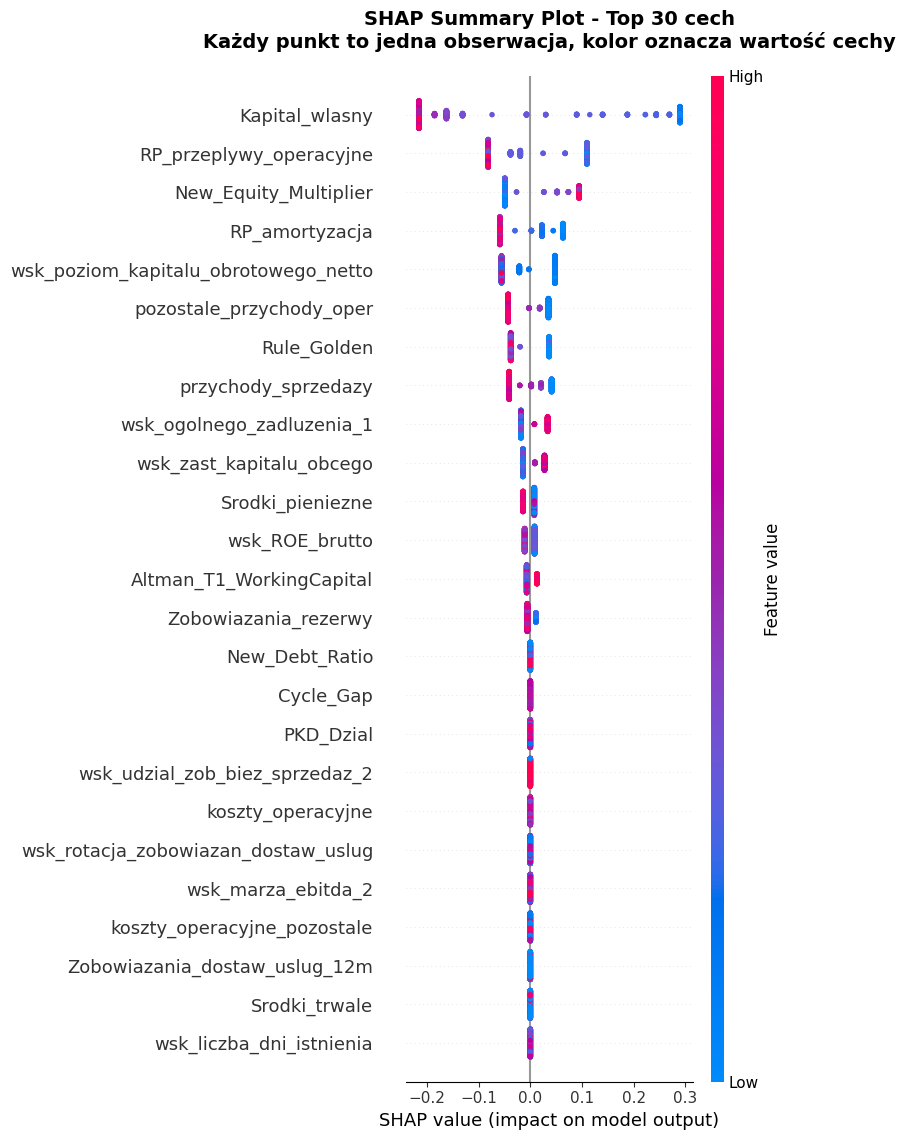

In [58]:
plt.figure(figsize=(14, 10))
shap.summary_plot(shap_values, X_test_selected, show=False, max_display=30)
plt.title("SHAP Summary Plot - Top 30 cech\nKażdy punkt to jedna obserwacja, kolor oznacza wartość cechy", 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [47]:
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_selected, plot_type="bar", show=False, max_display=30)
plt.title("SHAP Bar Plot - Top 30 najważniejszych cech globalnie\nŚrednia wartość bezwzględna SHAP", 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


In [48]:
exp_val = explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value

plt.figure(figsize=(14, 10))
shap.plots.beeswarm(shap.Explanation(values=shap_values,
                                     base_values=exp_val,
                                     data=X_test_selected.values,
                                     feature_names=X_test_selected.columns.tolist()),
                    max_display=30,
                    show=False)
plt.title("SHAP Beeswarm Plot - Top 30 cech z rozkładem gęstości\nGęstość punktów pokazuje częstość występowania wartości", 

          fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()



plt.show()


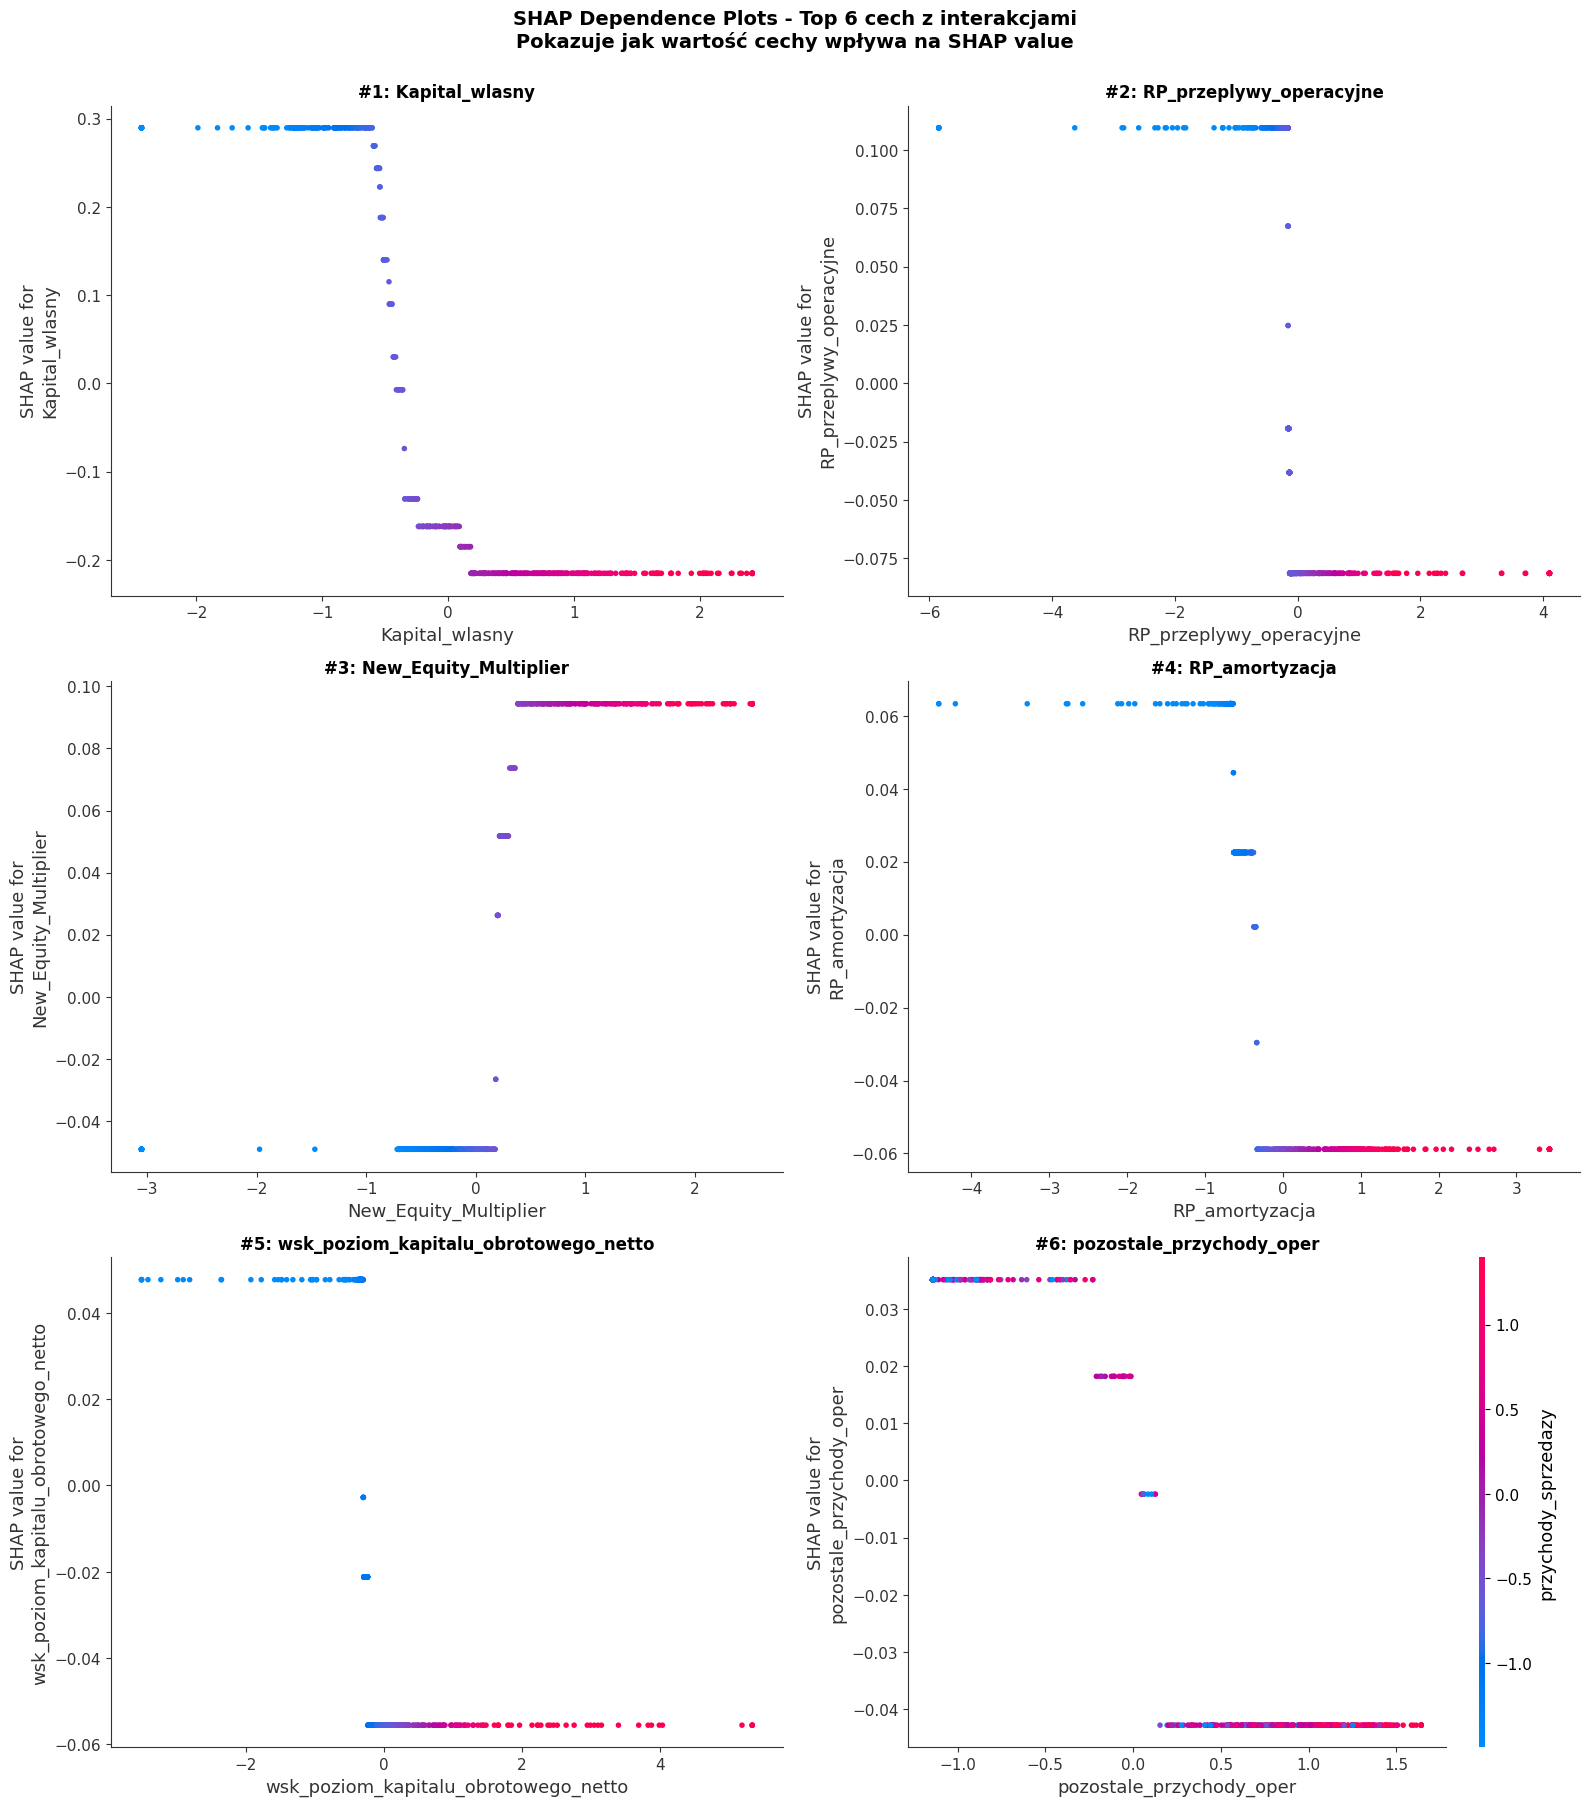

In [49]:


mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_6_features_idx = np.argsort(mean_abs_shap)[-6:][::-1]
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

for i, feat_idx in enumerate(top_6_features_idx):
    ax = axes[i]
    feature_name = X_test_selected.columns[feat_idx]
    shap.dependence_plot(
        feat_idx,
        shap_values,
        X_test_selected,
        interaction_index="auto",
        ax=ax,
        show=False
    )
    ax.set_title(f"#{i+1}: {feature_name}", fontsize=12, fontweight='bold')

plt.suptitle("SHAP Dependence Plots - Top 6 cech z interakcjami\nPokazuje jak wartość cechy wpływa na SHAP value", 
            fontsize=14, fontweight='bold', y=1.001)
plt.tight_layout()
plt.show()

In [50]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': X_test_selected.columns,
    'Mean_|SHAP|': mean_abs_shap
}).sort_values('Mean_|SHAP|', ascending=False)



# Wizualizacja jako heatmap
fig, ax = plt.subplots(figsize=(12, 14))
top_30 = feature_importance_df.head(30)
colors_map = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(top_30)))

bars = ax.barh(range(len(top_30)), top_30['Mean_|SHAP|'].values, color=colors_map)
ax.set_yticks(range(len(top_30)))
ax.set_yticklabels(top_30['Feature'].values, fontsize=10)
ax.set_xlabel('Mean |SHAP value|', fontsize=12, fontweight='bold')
ax.set_title('Top 30 Cech według średniego wpływu SHAP\nWyższa wartość = większy wpływ na predykcje modelu', 
            fontsize=14, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Dodaj wartości na końcach słupków
for i, (idx, row) in enumerate(top_30.iterrows()):
    ax.text(row['Mean_|SHAP|'], i, f"  {row['Mean_|SHAP|']:.4f}", 
            va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()




SHAP VIOLIN PLOT - Rozkład wartości SHAP


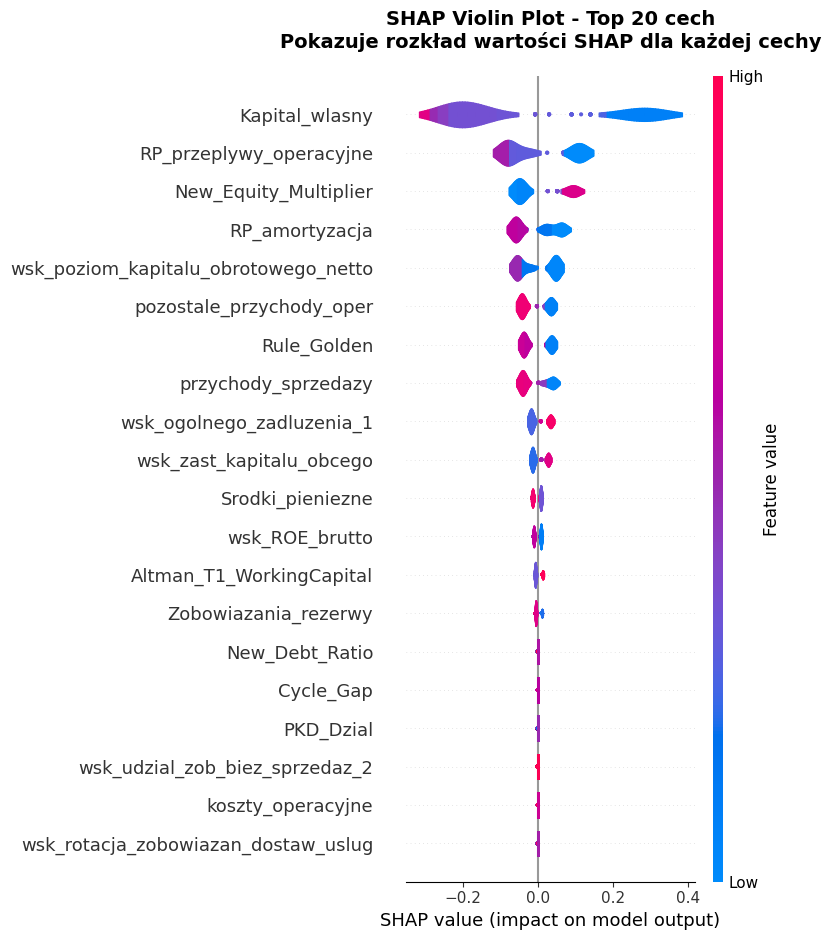

In [51]:
print("\n" + "="*80)
print("SHAP VIOLIN PLOT - Rozkład wartości SHAP")
print("="*80)

plt.figure(figsize=(14, 10))
shap.summary_plot(shap_values, X_test_selected, plot_type="violin", show=False, max_display=20)
plt.title("SHAP Violin Plot - Top 20 cech\nPokazuje rozkład wartości SHAP dla każdej cechy", 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


#### Krzywe PDP oraz ICE

In [52]:
top_features_for_pdp = feature_importance_df.head(6)['Feature'].tolist()
print(f"\nAnaliza PDP/ICE dla top 6 cech:")
for i, feat in enumerate(top_features_for_pdp, 1):
    print(f"  {i}. {feat}")


Analiza PDP/ICE dla top 6 cech:
  1. Kapital_wlasny
  2. RP_przeplywy_operacyjne
  3. New_Equity_Multiplier
  4. RP_amortyzacja
  5. wsk_poziom_kapitalu_obrotowego_netto
  6. pozostale_przychody_oper


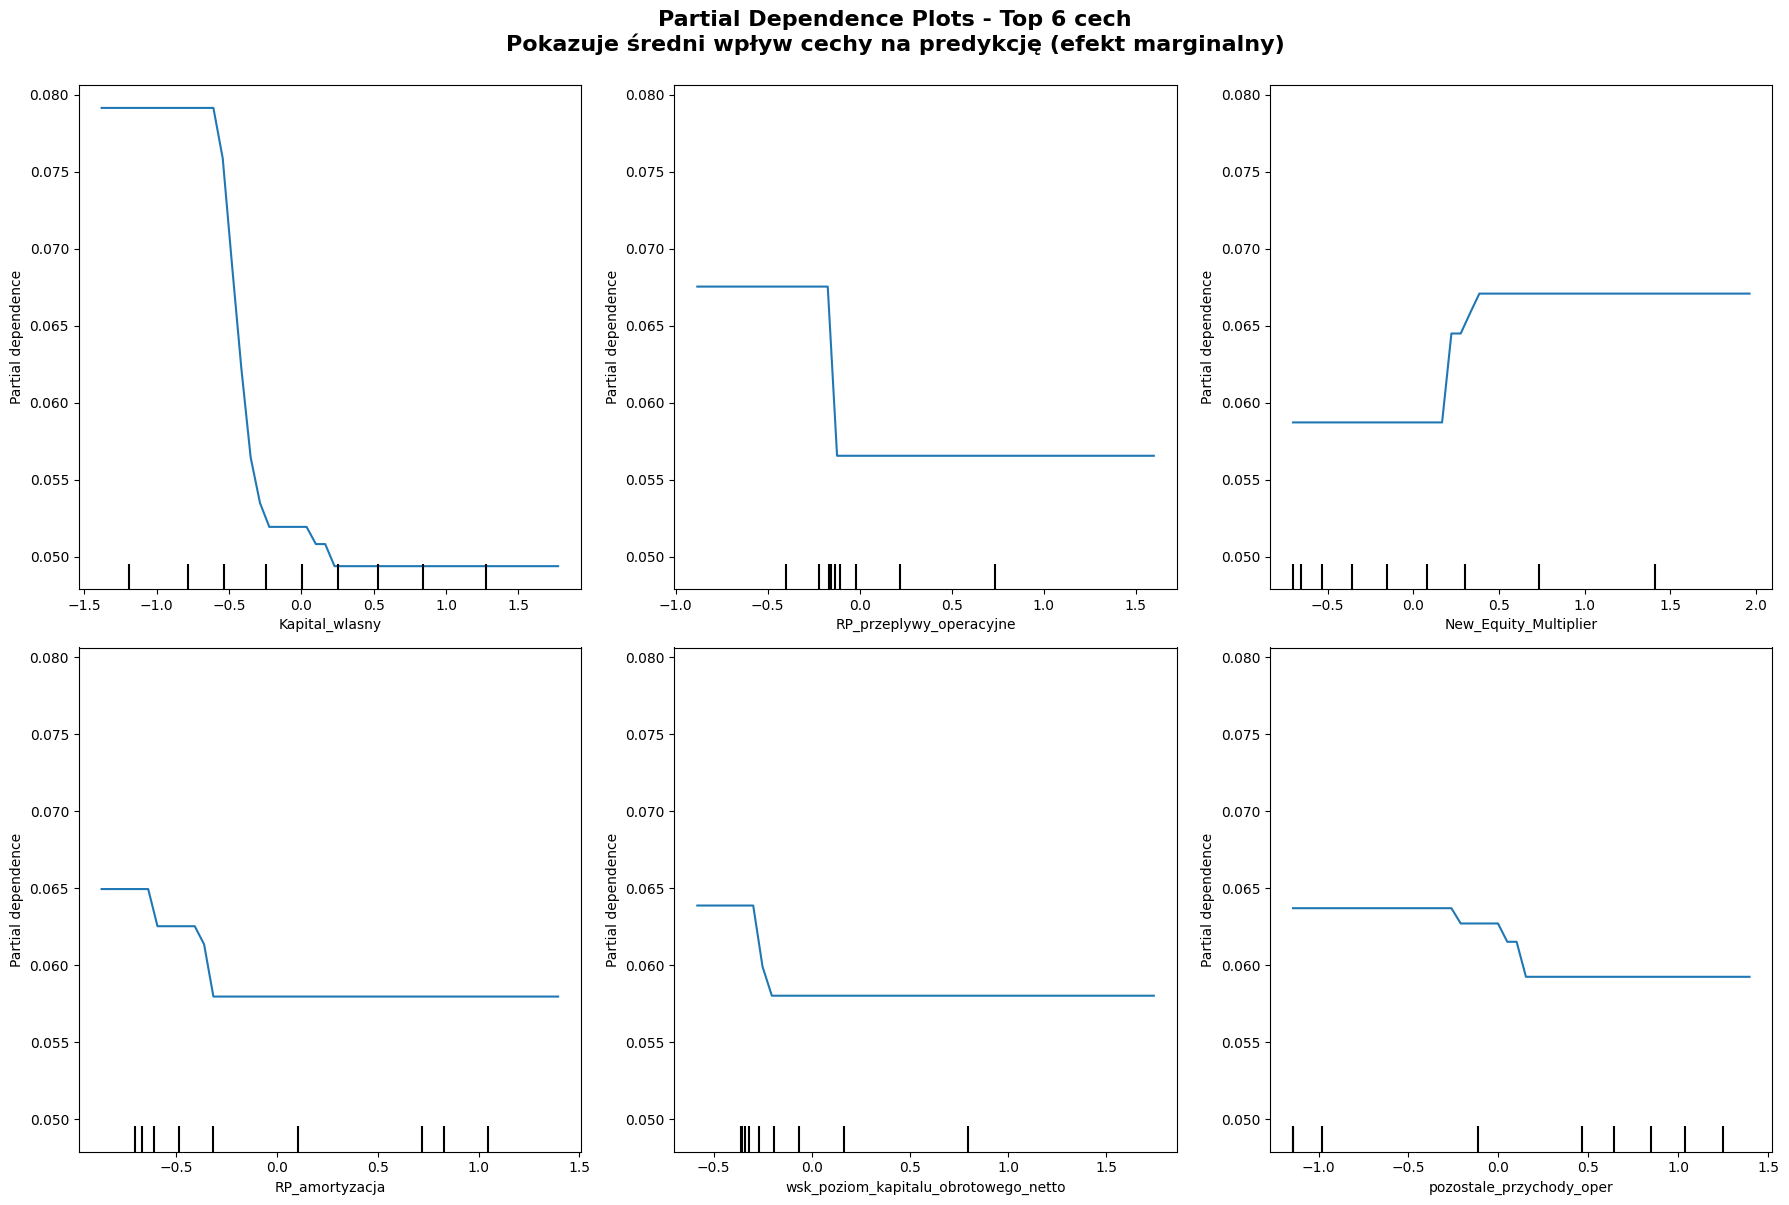

In [53]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

display = PartialDependenceDisplay.from_estimator(
    xgb_final,
    X_test_selected,
    features=top_features_for_pdp,
    kind='average',
    grid_resolution=50,
    ax=axes,
    n_jobs=-1
)

plt.suptitle("Partial Dependence Plots - Top 6 cech\nPokazuje średni wpływ cechy na predykcję (efekt marginalny)", 
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()



In [54]:

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Wybierz losową próbkę obserwacji dla ICE (100 linii dla czytelności)
n_ice_samples = min(100, len(X_test_selected))
ice_sample_indices = np.random.choice(len(X_test_selected), n_ice_samples, replace=False)

display = PartialDependenceDisplay.from_estimator(
    xgb_final,
    X_test_selected.iloc[ice_sample_indices],
    features=top_features_for_pdp,
    kind='individual',
    grid_resolution=50,
    ax=axes,
    n_jobs=-1
)

plt.suptitle(f"ICE Plots - Top 6 cech ({n_ice_samples} losowych obserwacji)\nKażda linia pokazuje jak predykcja dla danej obserwacji zmienia się z wartością cechy", 
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


In [55]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

display = PartialDependenceDisplay.from_estimator(
    xgb_final,
    X_test_selected.iloc[ice_sample_indices],
    features=top_features_for_pdp,
    kind='both',  # Pokazuje zarówno PDP (pogrubiona linia) jak i ICE (cienkie linie)
    grid_resolution=50,
    ax=axes,
    n_jobs=-1,
    ice_lines_kw={'alpha': 0.3, 'linewidth': 0.5},  # Przezroczyste linie ICE
    pd_line_kw={'color': 'red', 'linewidth': 3}  # Gruba czerwona linia PDP
)

plt.suptitle(f"PDP (czerwona linia) + ICE (szare linie) - Top 6 cech\nCzerwona linia = średni efekt | Szare linie = efekty indywidualne ({n_ice_samples} obs.)", 
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()



2D PDP - Interakcje między parami najważniejszych cech
  1. Kapital_wlasny × RP_przeplywy_operacyjne
  2. Kapital_wlasny × New_Equity_Multiplier
  3. RP_przeplywy_operacyjne × New_Equity_Multiplier
  4. Kapital_wlasny × RP_amortyzacja


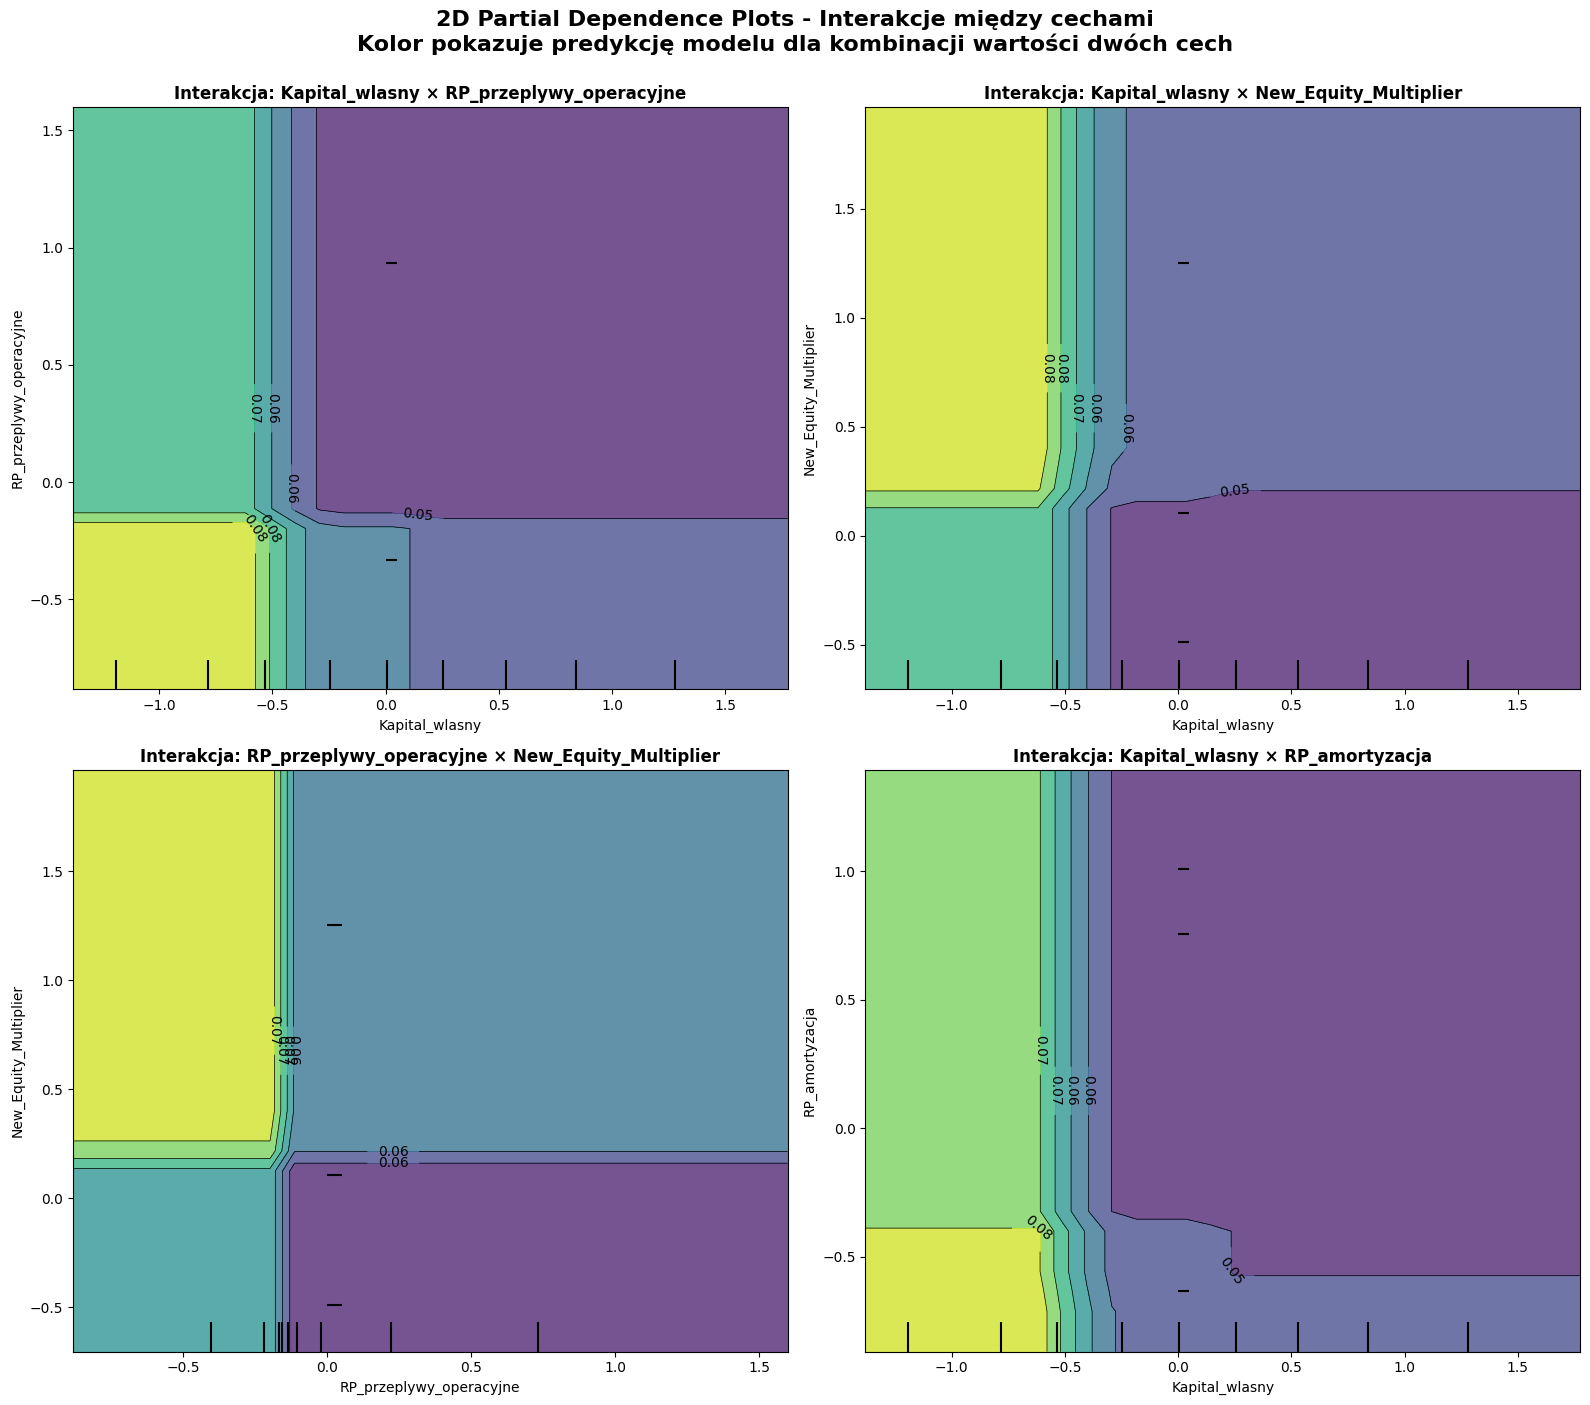

In [56]:
print("\n" + "="*80)
print("2D PDP - Interakcje między parami najważniejszych cech")
print("="*80)

top_4_features = feature_importance_df.head(4)['Feature'].tolist()
feature_pairs = [
    (top_4_features[0], top_4_features[1]),  # Para 1-2
    (top_4_features[0], top_4_features[2]),  # Para 1-3
    (top_4_features[1], top_4_features[2]),  # Para 2-3
    (top_4_features[0], top_4_features[3]),  # Para 1-4
]

for i, (feat1, feat2) in enumerate(feature_pairs, 1):
    print(f"  {i}. {feat1} × {feat2}")

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (feat1, feat2) in enumerate(feature_pairs):
    ax = axes[idx]
    
    display = PartialDependenceDisplay.from_estimator(
        xgb_final,
        X_test_selected,
        features=[(feat1, feat2)],
        grid_resolution=30,
        ax=[ax],
        n_jobs=-1
    )
    
    ax.set_title(f"Interakcja: {feat1} × {feat2}", fontsize=12, fontweight='bold')

plt.suptitle("2D Partial Dependence Plots - Interakcje między cechami\nKolor pokazuje predykcję modelu dla kombinacji wartości dwóch cech", 
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


# Część 4

In [71]:
# KALIBRACJA PROBABILISTYCZNA - przygotowanie danych
print("="*80)
print("KALIBRACJA PROBABILISTYCZNA")
print("="*80)
print("\nCel: Dostrojenie prawdopodobieństw predykcji do rzeczywistej częstości zdarzeń")
print("Target: Średnia przewidywanych PD ≈ 4% (zgodnie z rzeczywistym Default Rate)")
print("="*80)

# Pobierz predykcje prawdopodobieństwa z modelu (UNCALIBRATED)
y_pred_proba_uncal = xgb_final.predict_proba(X_val_selected)[:, 1]

# y_true to rzeczywiste etykiety z validation set
y_true = y_val.values

print(f"\n📊 Statystyki przed kalibracją:")
print(f"  • Rzeczywisty Default Rate: {y_true.mean():.4f} ({y_true.mean()*100:.2f}%)")
print(f"  • Średnie przewidywane PD: {y_pred_proba_uncal.mean():.4f} ({y_pred_proba_uncal.mean()*100:.2f}%)")
print(f"  • Różnica: {(y_pred_proba_uncal.mean() - y_true.mean())*100:.2f} pp")
print(f"  • Min PD: {y_pred_proba_uncal.min():.4f}, Max PD: {y_pred_proba_uncal.max():.4f}")
print(f"\n💡 y_true = rzeczywiste etykiety defaultu (0 lub 1) ze zbioru walidacyjnego")
print(f"💡 y_pred_proba_uncal = nieskalibowane prawdopodobieństwa z modelu XGBoost")
print("="*80)

KALIBRACJA PROBABILISTYCZNA

Cel: Dostrojenie prawdopodobieństw predykcji do rzeczywistej częstości zdarzeń
Target: Średnia przewidywanych PD ≈ 4% (zgodnie z rzeczywistym Default Rate)

📊 Statystyki przed kalibracją:
  • Rzeczywisty Default Rate: 0.0617 (6.17%)
  • Średnie przewidywane PD: 0.0617 (6.17%)
  • Różnica: 0.01 pp
  • Min PD: 0.0333, Max PD: 0.1260

💡 y_true = rzeczywiste etykiety defaultu (0 lub 1) ze zbioru walidacyjnego
💡 y_pred_proba_uncal = nieskalibowane prawdopodobieństwa z modelu XGBoost


### 1. Diagnostyka PRE-CALIBRATION

In [72]:
# Funkcje pomocnicze dla metryk kalibracji

def expected_calibration_error(y_true, y_pred, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_pred > bin_lower) & (y_pred <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_pred[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

def adaptive_calibration_error(y_true, y_pred, n_bins=10):
    sorted_indices = np.argsort(y_pred)
    y_pred_sorted = y_pred[sorted_indices]
    y_true_sorted = y_true[sorted_indices]
    
    bin_size = len(y_pred) // n_bins
    ace = 0.0
    
    for i in range(n_bins):
        start_idx = i * bin_size
        end_idx = start_idx + bin_size if i < n_bins - 1 else len(y_pred)
        
        bin_pred = y_pred_sorted[start_idx:end_idx]
        bin_true = y_true_sorted[start_idx:end_idx]
        
        if len(bin_pred) > 0:
            ace += np.abs(bin_pred.mean() - bin_true.mean()) * len(bin_pred) / len(y_pred)
    
    return ace

def brier_score_decomposition(y_true, y_pred):
    """Dekompozycja Brier Score na kalibrację i rozdzielczość"""
    brier = np.mean((y_pred - y_true) ** 2)
    
    uncertainty = np.mean(y_true) * (1 - np.mean(y_true))
    
    n_bins = 10
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_pred, bins[:-1]) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    reliability = 0.0
    resolution = 0.0
    
    for i in range(n_bins):
        in_bin = bin_indices == i
        if in_bin.sum() > 0:
            bin_mean_pred = y_pred[in_bin].mean()
            bin_mean_true = y_true[in_bin].mean()
            bin_count = in_bin.sum()
            
            reliability += (bin_count / len(y_pred)) * (bin_mean_pred - bin_mean_true) ** 2
            resolution += (bin_count / len(y_pred)) * (bin_mean_true - y_true.mean()) ** 2
    
    return {
        'brier_score': brier,
        'uncertainty': uncertainty,
        'reliability': reliability,
        'resolution': resolution,
        'brier_decomp': uncertainty + reliability - resolution
    }

print("\n" + "="*80)
print("METRYKI KALIBRACJI - PRZED KALIBRACJĄ")
print("="*80)

ece_uncal = expected_calibration_error(y_true, y_pred_proba_uncal)
ace_uncal = adaptive_calibration_error(y_true, y_pred_proba_uncal)
brier_decomp_uncal = brier_score_decomposition(y_true, y_pred_proba_uncal)

print(f"\n📈 Expected Calibration Error (ECE): {ece_uncal:.4f}")
print(f"📈 Adaptive Calibration Error (ACE): {ace_uncal:.4f}")
print(f"\n📊 Brier Score Decomposition:")
print(f"  • Brier Score: {brier_decomp_uncal['brier_score']:.4f}")
print(f"  • Uncertainty: {brier_decomp_uncal['uncertainty']:.4f}")
print(f"  • Reliability (kalibracja): {brier_decomp_uncal['reliability']:.4f}")
print(f"  • Resolution (rozdzielczość): {brier_decomp_uncal['resolution']:.4f}")
print(f"  • Weryfikacja: {brier_decomp_uncal['brier_decomp']:.4f}")
print("\n💡 Niższe wartości ECE/ACE = lepsza kalibracja")
print("💡 Niższy Reliability = lepiej skalibrowane prawdopodobieństwa")
print("="*80)


METRYKI KALIBRACJI - PRZED KALIBRACJĄ

📈 Expected Calibration Error (ECE): 0.0185
📈 Adaptive Calibration Error (ACE): 0.0235

📊 Brier Score Decomposition:
  • Brier Score: 0.0559
  • Uncertainty: 0.0579
  • Reliability (kalibracja): 0.0011
  • Resolution (rozdzielczość): 0.0023
  • Weryfikacja: 0.0567

💡 Niższe wartości ECE/ACE = lepsza kalibracja
💡 Niższy Reliability = lepiej skalibrowane prawdopodobieństwa



RELIABILITY CURVE - Krzywa kalibracji


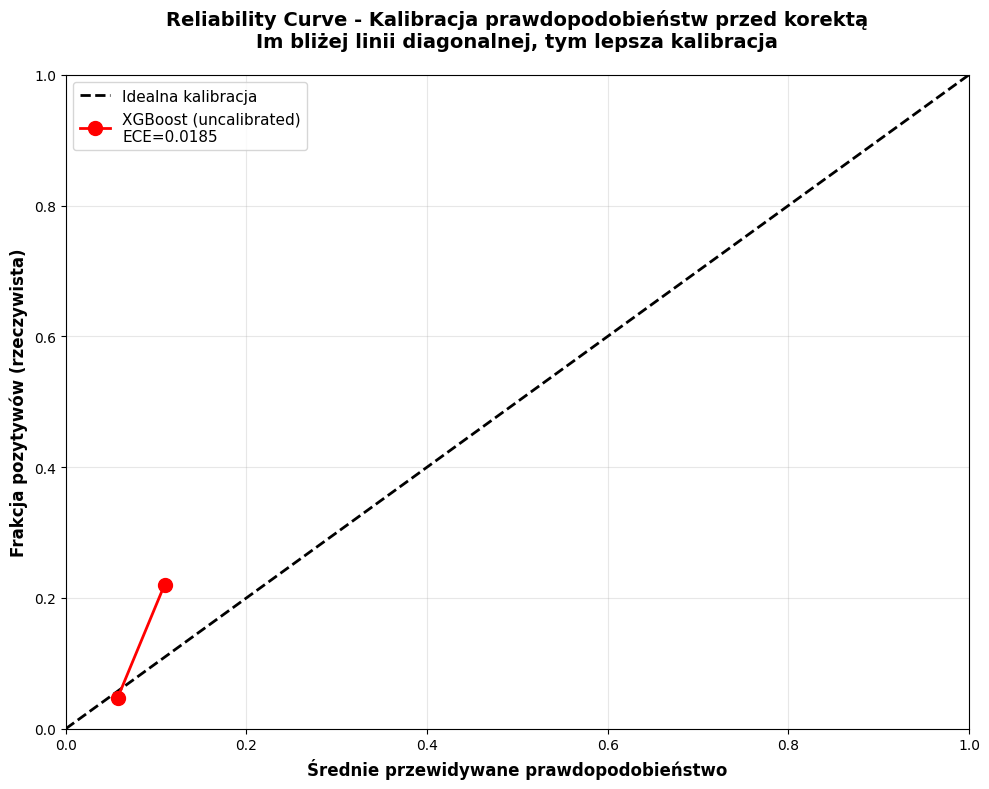


✓ Krzywa pokazuje odchylenia od idealnej kalibracji


In [ ]:
# 1. Reliability Curve (Calibration Plot)
print("\n" + "="*80)
print("RELIABILITY CURVE - Krzywa kalibracji")
print("="*80)

fig, ax = plt.subplots(figsize=(10, 8))

# Oblicz krzywą kalibracji
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_true, y_pred_proba_uncal, n_bins=10, strategy='uniform'
)

# Wykres
ax.plot([0, 1], [0, 1], 'k--', label='Idealna kalibracja', linewidth=2)
ax.plot(mean_predicted_value, fraction_of_positives, 'o-', 
        label=f'XGBoost (uncalibrated)\nECE={ece_uncal:.4f}', 
        linewidth=2, markersize=10, color='red')

ax.set_xlabel('Średnie przewidywane prawdopodobieństwo', fontsize=12, fontweight='bold')
ax.set_ylabel('Frakcja pozytywów (rzeczywista)', fontsize=12, fontweight='bold')
ax.set_title('Reliability Curve - Kalibracja prawdopodobieństw przed korektą\n' + 
            'Im bliżej linii diagonalnej, tym lepsza kalibracja',
            fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper left')
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\n✓ Krzywa pokazuje odchylenia od idealnej kalibracji")
print("="*80)


HISTOGRAM PREDYKCJI - Rozkład prawdopodobieństw


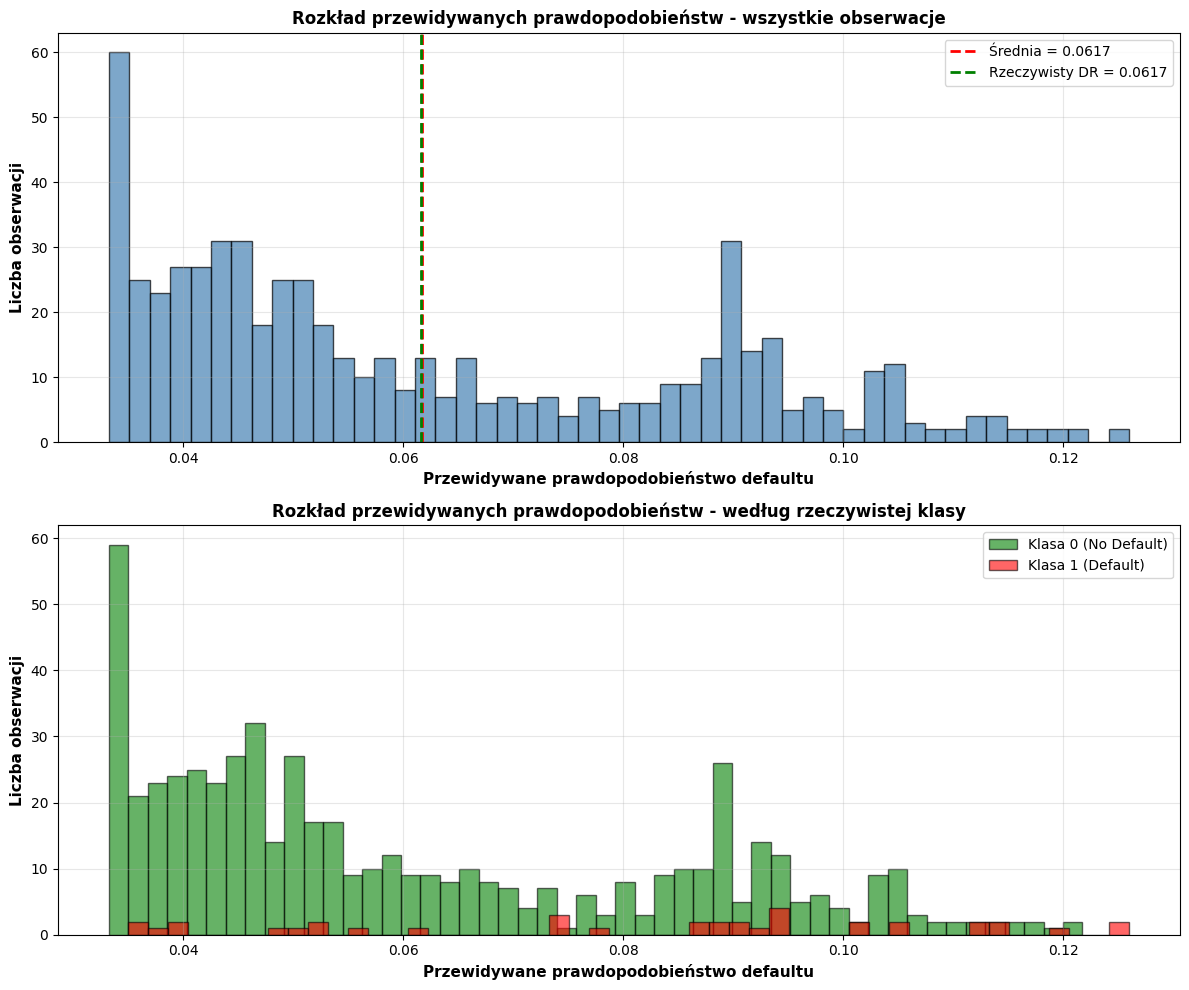


✓ Histogram pokazuje separację klas i koncentrację prawdopodobieństw


In [ ]:
# 2. Histogram predykcji
print("\n" + "="*80)
print("HISTOGRAM PREDYKCJI - Rozkład prawdopodobieństw")
print("="*80)

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Histogram ogólny
axes[0].hist(y_pred_proba_uncal, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(y_pred_proba_uncal.mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Średnia = {y_pred_proba_uncal.mean():.4f}')
axes[0].axvline(y_true.mean(), color='green', linestyle='--', 
                linewidth=2, label=f'Rzeczywisty DR = {y_true.mean():.4f}')
axes[0].set_xlabel('Przewidywane prawdopodobieństwo defaultu', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Liczba obserwacji', fontsize=11, fontweight='bold')
axes[0].set_title('Rozkład przewidywanych prawdopodobieństw - wszystkie obserwacje', 
                 fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Histogram rozdzielony na klasy
axes[1].hist(y_pred_proba_uncal[y_true == 0], bins=50, alpha=0.6, 
            color='green', label='Klasa 0 (No Default)', edgecolor='black')
axes[1].hist(y_pred_proba_uncal[y_true == 1], bins=50, alpha=0.6, 
            color='red', label='Klasa 1 (Default)', edgecolor='black')
axes[1].set_xlabel('Przewidywane prawdopodobieństwo defaultu', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Liczba obserwacji', fontsize=11, fontweight='bold')
axes[1].set_title('Rozkład przewidywanych prawdopodobieństw - według rzeczywistej klasy', 
                 fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Histogram pokazuje separację klas i koncentrację prawdopodobieństw")
print("="*80)

### 2. Metody kalibracji

In [75]:
# Metoda 1: Platt Scaling (Logistic Regression)
print("\n" + "="*80)
print("METODA 1: PLATT SCALING (Logistic Calibration)")
print("="*80)

# Przekształć prawdopodobieństwa do logitów (unikaj -inf/inf)
epsilon = 1e-10
y_pred_logit = np.log((y_pred_proba_uncal + epsilon) / (1 - y_pred_proba_uncal + epsilon))

# Dopasuj regresję logistyczną
platt_lr = LogisticRegression(penalty=None, solver='lbfgs')
platt_lr.fit(y_pred_logit.reshape(-1, 1), y_true)

# Kalibrowane prawdopodobieństwa
y_pred_platt = platt_lr.predict_proba(y_pred_logit.reshape(-1, 1))[:, 1]

print(f"\n✓ Parametry Platt Scaling:")
print(f"  • Slope (a): {platt_lr.coef_[0][0]:.4f}")
print(f"  • Intercept (b): {platt_lr.intercept_[0]:.4f}")
print(f"\n📊 Statystyki po kalibracji Platt:")
print(f"  • Średnie PD: {y_pred_platt.mean():.4f} ({y_pred_platt.mean()*100:.2f}%)")
print(f"  • Różnica od target 4%: {(y_pred_platt.mean() - 0.04)*100:.2f} pp")
print(f"  • ECE: {expected_calibration_error(y_true, y_pred_platt):.4f}")
print("="*80)


METODA 1: PLATT SCALING (Logistic Calibration)

✓ Parametry Platt Scaling:
  • Slope (a): 2.1484
  • Intercept (b): 2.9498

📊 Statystyki po kalibracji Platt:
  • Średnie PD: 0.0617 (6.17%)
  • Różnica od target 4%: 2.17 pp
  • ECE: 0.0043


In [76]:
# Metoda 2: Isotonic Regression
print("\n" + "="*80)
print("METODA 2: ISOTONIC REGRESSION")
print("="*80)

isotonic = IsotonicRegression(out_of_bounds='clip')
y_pred_isotonic = isotonic.fit_transform(y_pred_proba_uncal, y_true)

print(f"\n✓ Isotonic Regression - nieliniowa transformacja monotoniczna")
print(f"\n📊 Statystyki po kalibracji Isotonic:")
print(f"  • Średnie PD: {y_pred_isotonic.mean():.4f} ({y_pred_isotonic.mean()*100:.2f}%)")
print(f"  • Różnica od target 4%: {(y_pred_isotonic.mean() - 0.04)*100:.2f} pp")
print(f"  • ECE: {expected_calibration_error(y_true, y_pred_isotonic):.4f}")
print("="*80)


METODA 2: ISOTONIC REGRESSION

✓ Isotonic Regression - nieliniowa transformacja monotoniczna

📊 Statystyki po kalibracji Isotonic:
  • Średnie PD: 0.0617 (6.17%)
  • Różnica od target 4%: 2.17 pp
  • ECE: 0.0000


In [77]:
# Metoda 3: Beta Calibration
print("\n" + "="*80)
print("METODA 3: BETA CALIBRATION")
print("="*80)

def beta_calibration(y_true, y_pred):
    """
    Beta calibration - dopasowuje parametry rozkładu Beta
    """
    from scipy.stats import beta as beta_dist
    from scipy.optimize import minimize
    
    def neg_log_likelihood(params):
        a, b, c = params
        # Transformacja: y_cal = c + (1-c) * beta_cdf(y_pred; a, b)
        epsilon = 1e-10
        y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
        
        # Beta CDF
        y_cal = c + (1 - c) * beta_dist.cdf(y_pred_clipped, a, b)
        y_cal = np.clip(y_cal, epsilon, 1 - epsilon)
        
        # Negative log-likelihood
        nll = -np.sum(y_true * np.log(y_cal) + (1 - y_true) * np.log(1 - y_cal))
        return nll
    
    # Optymalizacja
    result = minimize(neg_log_likelihood, x0=[1.0, 1.0, 0.0], 
                     bounds=[(0.1, 10), (0.1, 10), (0, 0.5)],
                     method='L-BFGS-B')
    
    a_opt, b_opt, c_opt = result.x
    
    # Kalibrowane prawdopodobieństwa
    epsilon = 1e-10
    y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
    y_cal = c_opt + (1 - c_opt) * beta_dist.cdf(y_pred_clipped, a_opt, b_opt)
    
    return y_cal, a_opt, b_opt, c_opt

y_pred_beta, beta_a, beta_b, beta_c = beta_calibration(y_true, y_pred_proba_uncal)

print(f"\n✓ Parametry Beta Calibration:")
print(f"  • Alpha (a): {beta_a:.4f}")
print(f"  • Beta (b): {beta_b:.4f}")
print(f"  • Offset (c): {beta_c:.4f}")
print(f"\n📊 Statystyki po kalibracji Beta:")
print(f"  • Średnie PD: {y_pred_beta.mean():.4f} ({y_pred_beta.mean()*100:.2f}%)")
print(f"  • Różnica od target 4%: {(y_pred_beta.mean() - 0.04)*100:.2f} pp")
print(f"  • ECE: {expected_calibration_error(y_true, y_pred_beta):.4f}")
print("="*80)


METODA 3: BETA CALIBRATION

✓ Parametry Beta Calibration:
  • Alpha (a): 2.8608
  • Beta (b): 10.0000
  • Offset (c): 0.0098

📊 Statystyki po kalibracji Beta:
  • Średnie PD: 0.0609 (6.09%)
  • Różnica od target 4%: 2.09 pp
  • ECE: 0.0077


### 3. Calibration-in-the-Large

In [78]:
# Calibration-in-the-Large - dostrojenie do dokładnie 4%
print("\n" + "="*80)
print("CALIBRATION-IN-THE-LARGE - Dostrojenie do 4% Default Rate")
print("="*80)

target_dr = 0.04

def calibrate_to_target(y_pred, target_mean):
    """
    Dostosuj intercept i slope, aby średnie PD = target
    Metoda: a * logit(p) + b
    """
    epsilon = 1e-10
    y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
    
    # Logit transform
    logit_pred = np.log(y_pred_clipped / (1 - y_pred_clipped))
    
    # Znajdujemy intercept, który daje średnią = target (przy slope=1)
    def objective(b):
        y_cal = expit(logit_pred + b)
        return (y_cal.mean() - target_mean) ** 2
    
    result = minimize(objective, x0=[0], method='Nelder-Mead')
    b_opt = result.x[0]
    
    # Kalibrowane prawdopodobieństwa
    y_cal = expit(logit_pred + b_opt)
    
    return y_cal, 1.0, b_opt

# Zastosuj dla każdej metody
y_pred_uncal_large, slope_uncal, intercept_uncal = calibrate_to_target(y_pred_proba_uncal, target_dr)
y_pred_platt_large, slope_platt, intercept_platt = calibrate_to_target(y_pred_platt, target_dr)
y_pred_isotonic_large, slope_iso, intercept_iso = calibrate_to_target(y_pred_isotonic, target_dr)
y_pred_beta_large, slope_beta, intercept_beta = calibrate_to_target(y_pred_beta, target_dr)

print(f"\n✓ Calibration-in-the-Large stosuje shift do osiągnięcia target DR = {target_dr*100:.1f}%")
print(f"\n📊 Rezultaty po Calibration-in-the-Large:")
print(f"\n  Uncalibrated + Large:")
print(f"    • Średnie PD: {y_pred_uncal_large.mean():.4f} ({y_pred_uncal_large.mean()*100:.2f}%)")
print(f"    • Intercept correction: {intercept_uncal:.4f}")
print(f"    • ECE: {expected_calibration_error(y_true, y_pred_uncal_large):.4f}")

print(f"\n  Platt + Large:")
print(f"    • Średnie PD: {y_pred_platt_large.mean():.4f} ({y_pred_platt_large.mean()*100:.2f}%)")
print(f"    • Intercept correction: {intercept_platt:.4f}")
print(f"    • ECE: {expected_calibration_error(y_true, y_pred_platt_large):.4f}")

print(f"\n  Isotonic + Large:")
print(f"    • Średnie PD: {y_pred_isotonic_large.mean():.4f} ({y_pred_isotonic_large.mean()*100:.2f}%)")
print(f"    • Intercept correction: {intercept_iso:.4f}")
print(f"    • ECE: {expected_calibration_error(y_true, y_pred_isotonic_large):.4f}")

print(f"\n  Beta + Large:")
print(f"    • Średnie PD: {y_pred_beta_large.mean():.4f} ({y_pred_beta_large.mean()*100:.2f}%)")
print(f"    • Intercept correction: {intercept_beta:.4f}")
print(f"    • ECE: {expected_calibration_error(y_true, y_pred_beta_large):.4f}")

print("="*80)


CALIBRATION-IN-THE-LARGE - Dostrojenie do 4% Default Rate

✓ Calibration-in-the-Large stosuje shift do osiągnięcia target DR = 4.0%

📊 Rezultaty po Calibration-in-the-Large:

  Uncalibrated + Large:
    • Średnie PD: 0.0400 (4.00%)
    • Intercept correction: -0.4608
    • ECE: 0.0217

  Platt + Large:
    • Średnie PD: 0.0400 (4.00%)
    • Intercept correction: -0.4732
    • ECE: 0.0217

  Isotonic + Large:
    • Średnie PD: 0.0400 (4.00%)
    • Intercept correction: -0.5148
    • ECE: 0.0217

  Beta + Large:
    • Średnie PD: 0.0400 (4.00%)
    • Intercept correction: -0.4571
    • ECE: 0.0217


### 4. Walidacja POST-CALIBRATION

In [79]:
# Porównanie wszystkich metod - metryki
print("\n" + "="*80)
print("PORÓWNANIE METOD KALIBRACJI - Wszystkie metryki")
print("="*80)

calibration_methods = {
    'Uncalibrated': y_pred_proba_uncal,
    'Platt Scaling': y_pred_platt,
    'Isotonic Regression': y_pred_isotonic,
    'Beta Calibration': y_pred_beta,
    'Uncal + Large': y_pred_uncal_large,
    'Platt + Large': y_pred_platt_large,
    'Isotonic + Large': y_pred_isotonic_large,
    'Beta + Large': y_pred_beta_large
}

results = []
for method_name, y_pred in calibration_methods.items():
    ece = expected_calibration_error(y_true, y_pred)
    ace = adaptive_calibration_error(y_true, y_pred)
    brier_decomp = brier_score_decomposition(y_true, y_pred)
    mean_pd = y_pred.mean()
    diff_from_target = abs(mean_pd - target_dr)
    
    results.append({
        'Method': method_name,
        'Mean PD': mean_pd,
        'Diff from 4%': diff_from_target,
        'ECE': ece,
        'ACE': ace,
        'Brier': brier_decomp['brier_score'],
        'Reliability': brier_decomp['reliability'],
        'Resolution': brier_decomp['resolution']
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('ECE')

print("\n" + results_df.to_string(index=False))
print("\n💡 Najlepsza metoda według ECE:", results_df.iloc[0]['Method'])
print("="*80)


PORÓWNANIE METOD KALIBRACJI - Wszystkie metryki

             Method  Mean PD  Diff from 4%          ECE      ACE    Brier  Reliability  Resolution
Isotonic Regression 0.061667  2.166667e-02 2.135833e-09 0.020321 0.051407 2.610725e-17    0.005955
      Platt Scaling 0.061674  2.167355e-02 4.326600e-03 0.014662 0.054737 3.595354e-04    0.002932
   Beta Calibration 0.060933  2.093257e-02 7.687009e-03 0.015266 0.054778 5.998036e-04    0.003323
       Uncalibrated 0.061739  2.173885e-02 1.852163e-02 0.023516 0.055903 1.115435e-03    0.002279
      Uncal + Large 0.040001  1.145930e-06 2.166552e-02 0.029145 0.056892 4.693948e-04    0.000000
   Isotonic + Large 0.040001  8.618432e-07 2.166580e-02 0.025284 0.052273 6.338512e-04    0.004712
      Platt + Large 0.040001  8.219709e-07 2.166584e-02 0.025065 0.055641 1.178957e-03    0.002440
       Beta + Large 0.040000  2.569719e-07 2.166692e-02 0.025417 0.055752 1.203818e-03    0.002167

💡 Najlepsza metoda według ECE: Isotonic Regression


In [ ]:
# Reliability curves - porównanie wszystkich metod
print("\n" + "="*80)
print("RELIABILITY CURVES - Porównanie metod kalibracji")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

methods_to_plot = [
    ('Uncalibrated', y_pred_proba_uncal, 'red'),
    ('Platt Scaling', y_pred_platt, 'blue'),
    ('Isotonic Regression', y_pred_isotonic, 'green'),
    ('Beta Calibration', y_pred_beta, 'purple')
]

for idx, (ax, (method_name, y_pred, color)) in enumerate(zip(axes, methods_to_plot)):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_pred, n_bins=10, strategy='uniform'
    )
    
    ece = expected_calibration_error(y_true, y_pred)
    
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect calibration', linewidth=2, alpha=0.7)
    ax.plot(mean_predicted_value, fraction_of_positives, 'o-', 
            label=f'{method_name}\nECE={ece:.4f}', 
            linewidth=2.5, markersize=8, color=color)
    
    ax.set_xlabel('Mean predicted probability', fontsize=11, fontweight='bold')
    ax.set_ylabel('Fraction of positives', fontsize=11, fontweight='bold')
    ax.set_title(f'{method_name}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10, loc='upper left')
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.suptitle('Reliability Curves - Porównanie metod kalibracji\nIm bliżej diagonali, tym lepsza kalibracja', 
            fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✓ Reliability curves pokazują jak każda metoda wpływa na kalibrację")
print("="*80)


RELIABILITY CURVES - Porównanie metod kalibracji



✓ Reliability curves pokazują jak każda metoda wpływa na kalibrację


In [ ]:
# Histogram porównawczy
print("\n" + "="*80)
print("HISTOGRAMY - Porównanie rozkładów po kalibracji")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (ax, (method_name, y_pred, color)) in enumerate(zip(axes, methods_to_plot)):
    ax.hist(y_pred[y_true == 0], bins=50, alpha=0.5, color='green', 
           label='No Default', edgecolor='black', density=True)
    ax.hist(y_pred[y_true == 1], bins=50, alpha=0.5, color='red', 
           label='Default', edgecolor='black', density=True)
    ax.axvline(y_pred.mean(), color='blue', linestyle='--', linewidth=2, 
              label=f'Mean PD={y_pred.mean():.4f}')
    ax.axvline(target_dr, color='orange', linestyle='--', linewidth=2, 
              label=f'Target={target_dr:.2f}')
    
    ax.set_xlabel('Predicted Probability', fontsize=11, fontweight='bold')
    ax.set_ylabel('Density', fontsize=11, fontweight='bold')
    ax.set_title(f'{method_name}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Rozkład przewidywanych prawdopodobieństw - Porównanie metod', 
            fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✓ Histogramy pokazują jak kalibracja wpływa na rozkład prawdopodobieństw")
print("="*80)


HISTOGRAMY - Porównanie rozkładów po kalibracji



✓ Histogramy pokazują jak kalibracja wpływa na rozkład prawdopodobieństw


In [82]:
# Stabilność per podgrupa - analiza według decyli predykcji
print("\n" + "="*80)
print("STABILNOŚĆ KALIBRACJI - Analiza według podgrup (decyle)")
print("="*80)

# Wybierz najlepszą metodę (według ECE)
best_method_name = results_df.iloc[0]['Method']
best_y_pred = calibration_methods[best_method_name]

print(f"\n✓ Analiza dla najlepszej metody: {best_method_name}")

# Podziel na decyle według predykcji
deciles = pd.qcut(best_y_pred, q=10, labels=False, duplicates='drop')

stability_results = []
for decile in range(deciles.max() + 1):
    mask = deciles == decile
    if mask.sum() > 0:
        decile_true = y_true[mask]
        decile_pred = best_y_pred[mask]
        
        actual_dr = decile_true.mean()
        predicted_dr = decile_pred.mean()
        n_obs = mask.sum()
        
        stability_results.append({
            'Decile': decile + 1,
            'N': n_obs,
            'Predicted DR': predicted_dr,
            'Actual DR': actual_dr,
            'Diff': predicted_dr - actual_dr,
            'Abs Diff': abs(predicted_dr - actual_dr)
        })

stability_df = pd.DataFrame(stability_results)

print("\n" + stability_df.to_string(index=False))
print(f"\n📊 Średnia bezwzględna różnica per decyl: {stability_df['Abs Diff'].mean():.4f}")
print(f"📊 Maksymalna bezwzględna różnica: {stability_df['Abs Diff'].max():.4f}")
print("="*80)


STABILNOŚĆ KALIBRACJI - Analiza według podgrup (decyle)

✓ Analiza dla najlepszej metody: Isotonic Regression

 Decile   N  Predicted DR  Actual DR          Diff     Abs Diff
      1  60      0.000873   0.016667 -1.579407e-02 1.579407e-02
      2 189      0.026178   0.021164  5.013985e-03 5.013985e-03
      3 164      0.036585   0.036585 -1.362911e-09 1.362911e-09
      4  81      0.086420   0.086420  6.438773e-10 6.438773e-10
      5  88      0.136364   0.136364  4.063953e-09 4.063953e-09
      6  18      0.388889   0.388889  3.642506e-08 3.642506e-08

📊 Średnia bezwzględna różnica per decyl: 0.0035
📊 Maksymalna bezwzględna różnica: 0.0158


In [ ]:
# Wizualizacja stabilności per decyl
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Wykres 1: Predicted vs Actual DR per decyl
axes[0].plot(stability_df['Decile'], stability_df['Predicted DR'], 'o-', 
            label='Predicted DR', linewidth=2, markersize=8, color='blue')
axes[0].plot(stability_df['Decile'], stability_df['Actual DR'], 's-', 
            label='Actual DR', linewidth=2, markersize=8, color='red')
axes[0].axhline(target_dr, color='green', linestyle='--', linewidth=2, 
               label=f'Target DR={target_dr:.2f}', alpha=0.7)
axes[0].set_xlabel('Decyl ryzyka', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Default Rate', fontsize=12, fontweight='bold')
axes[0].set_title(f'Kalibracja per decyl - {best_method_name}', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Wykres 2: Różnice
axes[1].bar(stability_df['Decile'], stability_df['Diff'], 
           color=['green' if x >= 0 else 'red' for x in stability_df['Diff']],
           alpha=0.7, edgecolor='black')
axes[1].axhline(0, color='black', linestyle='-', linewidth=1)
axes[1].set_xlabel('Decyl ryzyka', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Różnica (Predicted - Actual)', fontsize=12, fontweight='bold')
axes[1].set_title('Odchylenia kalibracji per decyl', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.suptitle(f'Stabilność kalibracji według podgrup - {best_method_name}', 
            fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✓ Analiza stabilności pokazuje jak dobrze model jest skalibrowany w różnych segmentach ryzyka")
print("="*80)


✓ Analiza stabilności pokazuje jak dobrze model jest skalibrowany w różnych segmentach ryzyka


# Część 5

## 5.1. Funkcja kosztu/korzyści i dobór progu operacyjnego

In [84]:
base_default_rate = 0.04
y_pred_cal = calibration_methods[best_method_name]


In [ ]:
LOAN_AMOUNT = 100
INTEREST_RATE = 0.10
LGD = 0.80
# 1. Koszt wpadki (Błędnie udzielony kredyt) -> Realna strata finansowa
COST_FN = LOAN_AMOUNT * LGD 
# 2. Koszt utraconej szansy (Błędnie odrzucony dobry klient)
COST_FP = LOAN_AMOUNT * INTEREST_RATE 
# 3. Zysk z sukcesu (Poprawnie udzielony kredyt)
BENEFIT_TN = LOAN_AMOUNT * INTEREST_RATE
# 4. Zysk z odrzucenia złego (Poprawnie odrzucony)
# Finansowo to 0 (brak transakcji). Uniknięta strata jest już "nagrodzona" brakiem COST_FN.
BENEFIT_TP = 0 

print("SKORYGOWANE Parametry:")
print(f"  Zysk na dobrym kliencie (TN): +{BENEFIT_TN:.2f}")
print(f"  Strata na złym kliencie (FN): -{COST_FN:.2f}")
print(f"  Utracony zysk przez odrzucenie dobrego (FP): -{COST_FP:.2f} (Koszt alternatywny)")
print(f"  Wynik odrzucenia złego (TP):   {BENEFIT_TP:.2f} (Neutralny - brak pożyczki)")

ratio = COST_FN / BENEFIT_TN
print(f"\nKluczowa relacja:")
print(f"Jeden niespłacony kredyt 'zjada' zysk z {ratio:.1f} spłaconych kredytów.")

SKORYGOWANE Parametry:
  Zysk na dobrym kliencie (TN): +10.00
  Strata na złym kliencie (FN): -80.00
  Utracony zysk przez odrzucenie dobrego (FP): -10.00 (Koszt alternatywny)
  Wynik odrzucenia złego (TP):   0.00 (Neutralny - brak pożyczki)

Kluczowa relacja:
Jeden niespłacony kredyt 'zjada' zysk z 8.0 spłaconych kredytów.


In [86]:
fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_cal)
precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred_cal)

def calculate_profit(y_true, y_pred_proba, threshold):
    y_pred_binary = (y_pred_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    profit = (tn * BENEFIT_TN - fp * COST_FP + tp * BENEFIT_TP - fn * COST_FN)
    return profit, tn, fp, fn, tp

test_thresholds = np.linspace(0.01, 0.99, 200)
profits = []
confusion_matrices = []

for thresh in test_thresholds:
    profit, tn, fp, fn, tp = calculate_profit(y_true, y_pred_cal, thresh)
    profits.append(profit)
    confusion_matrices.append({'threshold': thresh, 'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp, 'profit': profit})

profits = np.array(profits)
optimal_idx = np.argmax(profits)
optimal_threshold = test_thresholds[optimal_idx]
optimal_profit = profits[optimal_idx]

print("Optymalizacja progu decyzyjnego:")
print(f"  Prog maksymalizujący profit: {optimal_threshold:.4f}")
print(f"  Maksymalny profit: {optimal_profit:.2f}")
print(f"  Profit per aplikacja: {optimal_profit/len(y_true):.2f}")
print("="*80)

Optymalizacja progu decyzyjnego:
  Prog maksymalizujący profit: 0.1380
  Maksymalny profit: 3010.00
  Profit per aplikacja: 5.02


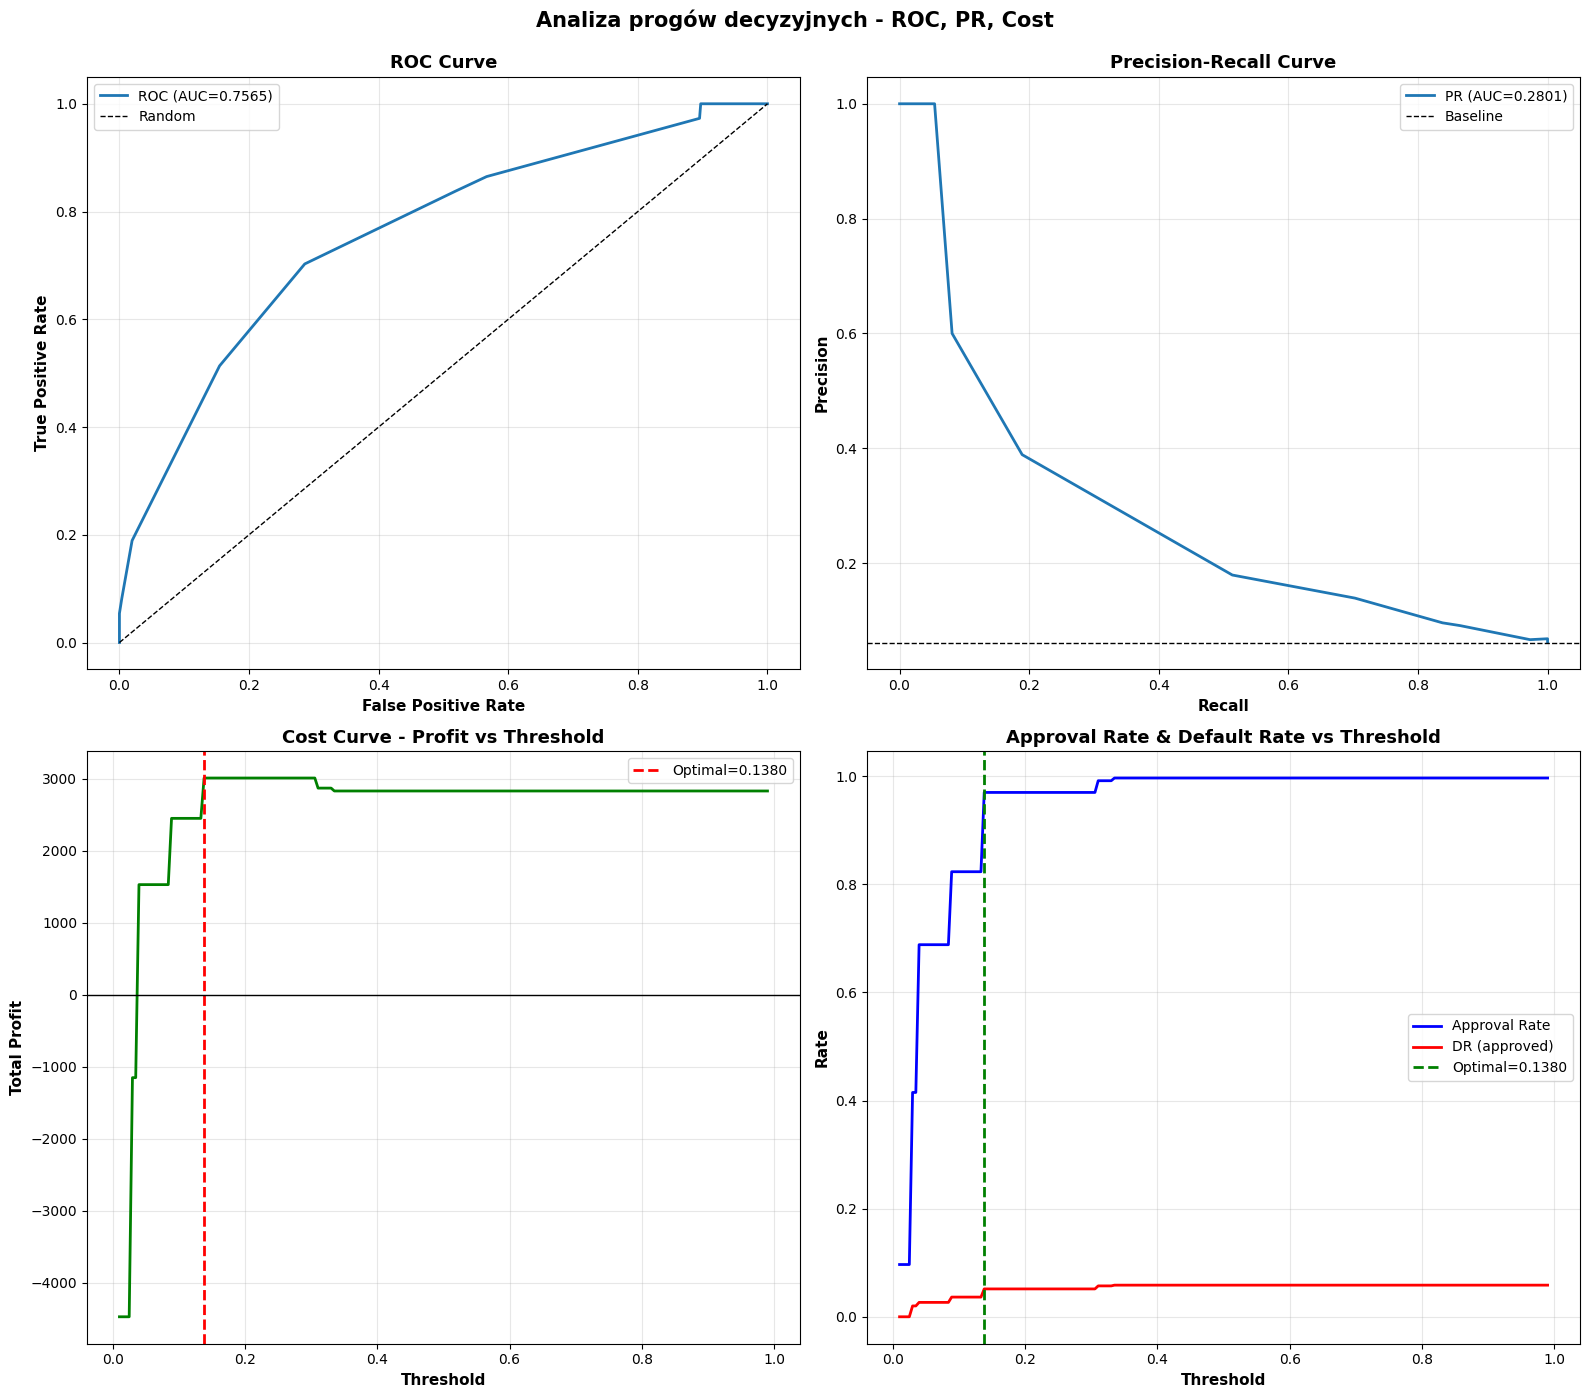

Wykresy zapisane: threshold_analysis_curves.png


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

roc_auc = auc(fpr, tpr)
axes[0, 0].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC={roc_auc:.4f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
axes[0, 0].set_title('ROC Curve', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

pr_auc = auc(recall, precision)
axes[0, 1].plot(recall, precision, linewidth=2, label=f'PR (AUC={pr_auc:.4f})')
axes[0, 1].axhline(y=y_true.mean(), color='k', linestyle='--', linewidth=1, label='Baseline')
axes[0, 1].set_xlabel('Recall', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Precision', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Precision-Recall Curve', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(test_thresholds, profits, linewidth=2, color='green')
axes[1, 0].axvline(optimal_threshold, color='red', linestyle='--', linewidth=2, 
                   label=f'Optimal={optimal_threshold:.4f}')
axes[1, 0].axhline(0, color='black', linestyle='-', linewidth=1)
axes[1, 0].set_xlabel('Threshold', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Total Profit', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Cost Curve - Profit vs Threshold', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3)

approval_rates = []
default_rates_approved = []
for thresh in test_thresholds:
    approved = y_pred_cal < thresh
    approval_rate = approved.mean()
    if approval_rate > 0:
        dr_approved = y_true[approved].mean()
    else:
        dr_approved = 0
    approval_rates.append(approval_rate)
    default_rates_approved.append(dr_approved)

axes[1, 1].plot(test_thresholds, approval_rates, linewidth=2, label='Approval Rate', color='blue')
axes[1, 1].plot(test_thresholds, default_rates_approved, linewidth=2, label='DR (approved)', color='red')
axes[1, 1].axvline(optimal_threshold, color='green', linestyle='--', linewidth=2, 
                   label=f'Optimal={optimal_threshold:.4f}')
axes[1, 1].set_xlabel('Threshold', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Rate', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Approval Rate & Default Rate vs Threshold', fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Analiza progów decyzyjnych - ROC, PR, Cost', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("Wykresy zapisane: threshold_analysis_curves.png")
print("="*80)

## 5.2. Mapowanie PD na klasy ratingowe

In [88]:
print("="*80)
print("MAPOWANIE PRAWDOPODOBIEŃSTW NA KLASY RATINGOWE")
print("="*80)

n_rating_classes = 7
rating_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

print(f"Liczba klas ratingowych: {n_rating_classes}")
print(f"Etykiety: {rating_labels}")
print(f"\nWymagania:")
print(f"  Klasa A (najlepsza): Default Rate < 0.1%")
print(f"  Klasa G (najgorsza): Default Rate > 95%")
print(f"  Monotoniczność: DR rosnący między klasami")
print(f"  Minimalna liczba obserwacji w klasie: 1% populacji ({int(len(y_true)*0.01)} obs.)")
print("="*80)

MAPOWANIE PRAWDOPODOBIEŃSTW NA KLASY RATINGOWE
Liczba klas ratingowych: 7
Etykiety: ['A', 'B', 'C', 'D', 'E', 'F', 'G']

Wymagania:
  Klasa A (najlepsza): Default Rate < 0.1%
  Klasa G (najgorsza): Default Rate > 95%
  Monotoniczność: DR rosnący między klasami
  Minimalna liczba obserwacji w klasie: 1% populacji (6 obs.)


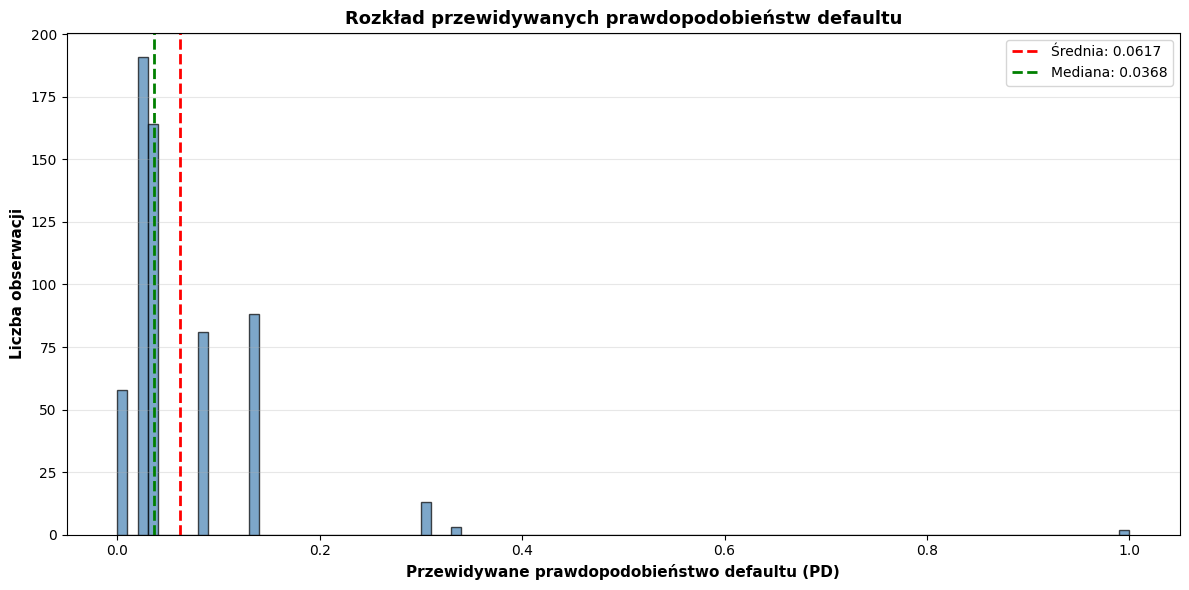


Statystyki rozkładu przewidywanych prawdopodobieństw:
  Liczba obserwacji: 600
  Średnia: 0.061667
  Mediana: 0.036765
  Odchylenie standardowe: 0.080355
  Min: 0.000000
  Max: 1.000000
  Q1 (25%): 0.026178
  Q3 (75%): 0.086420

Wykres zapisany: predicted_probabilities_histogram.png


In [ ]:
# Wizualizacja rozkładu przewidywanych prawdopodobieństw
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Histogram ze skalą liniową
ax.hist(y_pred_cal, bins=100, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_xlabel('Przewidywane prawdopodobieństwo defaultu (PD)', fontsize=11, fontweight='bold')
ax.set_ylabel('Liczba obserwacji', fontsize=11, fontweight='bold')
ax.set_title('Rozkład przewidywanych prawdopodobieństw defaultu', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3, axis='y')
ax.axvline(y_pred_cal.mean(), color='red', linestyle='--', linewidth=2, label=f'Średnia: {y_pred_cal.mean():.4f}')
ax.axvline(np.median(y_pred_cal), color='green', linestyle='--', linewidth=2, label=f'Mediana: {np.median(y_pred_cal):.4f}')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nStatystyki rozkładu przewidywanych prawdopodobieństw:")
print(f"  Liczba obserwacji: {len(y_pred_cal)}")
print(f"  Średnia: {y_pred_cal.mean():.6f}")
print(f"  Mediana: {np.median(y_pred_cal):.6f}")
print(f"  Odchylenie standardowe: {y_pred_cal.std():.6f}")
print(f"  Min: {y_pred_cal.min():.6f}")
print(f"  Max: {y_pred_cal.max():.6f}")
print(f"  Q1 (25%): {np.percentile(y_pred_cal, 25):.6f}")
print(f"  Q3 (75%): {np.percentile(y_pred_cal, 75):.6f}")
print(f"\nWykres zapisany: predicted_probabilities_histogram.png")
print("="*80)

In [90]:
def find_optimal_rating_boundaries(y_true, y_pred_proba, n_classes=7, 
                                   max_dr_best=0.001, min_dr_worst=0.95, 
                                   min_class_size=0.01):
    sorted_indices = np.argsort(y_pred_proba)
    y_true_sorted = y_true[sorted_indices]
    y_pred_sorted = y_pred_proba[sorted_indices]
    
    n_obs = len(y_true)
    min_obs_per_class = int(n_obs * min_class_size)
    
    boundaries = [0]
    
    # Klasa A: znajdź największą grupę gdzie DR < 0.1%
    idx = min_obs_per_class
    while idx < n_obs:
        class_dr = y_true_sorted[:idx].mean()
        if class_dr >= max_dr_best:
            idx = max(min_obs_per_class, idx - 1)
            break
        idx += 1
    boundaries.append(idx)
    
    # Podziel pozostałe obserwacje na równe klasy
    remaining_obs = n_obs - boundaries[-1]
    remaining_classes = n_classes - 1
    
    for i in range(1, remaining_classes):
        class_size = remaining_obs // remaining_classes
        next_boundary = boundaries[-1] + class_size
        boundaries.append(min(next_boundary, n_obs))
    
    boundaries.append(n_obs)
    
    # Konwersja na wartości PD
    pd_boundaries = [y_pred_sorted[min(idx, n_obs-1)] for idx in boundaries]
    
    return pd_boundaries, sorted_indices, y_true_sorted, y_pred_sorted

pd_boundaries, sorted_indices, y_true_sorted, y_pred_sorted = find_optimal_rating_boundaries(
    y_true, y_pred_cal, n_classes=n_rating_classes
)

def assign_rating_class(y_pred_proba, boundaries):
    ratings = np.zeros(len(y_pred_proba), dtype=int)
    for i, pd in enumerate(y_pred_proba):
        for class_idx in range(len(boundaries) - 1):
            if boundaries[class_idx] <= pd < boundaries[class_idx + 1]:
                ratings[i] = class_idx
                break
    return ratings

ratings = assign_rating_class(y_pred_cal, pd_boundaries)

print("Optymalne granice klas ratingowych (PD):")
for i in range(len(pd_boundaries) - 1):
    print(f"  Klasa {rating_labels[i]}: [{pd_boundaries[i]:.6f}, {pd_boundaries[i+1]:.6f})")
print("="*80)

Optymalne granice klas ratingowych (PD):
  Klasa A: [0.000000, 0.026178)
  Klasa B: [0.026178, 0.026178)
  Klasa C: [0.026178, 0.026178)
  Klasa D: [0.026178, 0.036765)
  Klasa E: [0.036765, 0.086420)
  Klasa F: [0.086420, 0.136364)
  Klasa G: [0.136364, 1.000000)


In [91]:
rating_analysis = []

for class_idx in range(n_rating_classes):
    mask = ratings == class_idx
    n_obs = mask.sum()
    pct_population = n_obs / len(y_true) * 100
    
    if n_obs > 0:
        avg_pd = y_pred_cal[mask].mean()
        median_pd = np.median(y_pred_cal[mask])
        std_pd = y_pred_cal[mask].std()
        actual_dr = y_true[mask].mean()
        n_defaults = y_true[mask].sum()
        
        rating_analysis.append({
            'Rating': rating_labels[class_idx],
            'PD_Min': pd_boundaries[class_idx],
            'PD_Max': pd_boundaries[class_idx + 1],
            'N_Obs': n_obs,
            'Pct_Pop': pct_population,
            'Avg_PD': avg_pd,
            'Median_PD': median_pd,
            'Std_PD': std_pd,
            'Actual_DR': actual_dr,
            'N_Defaults': int(n_defaults)
        })

rating_df = pd.DataFrame(rating_analysis)

print("Analiza klas ratingowych:")
print(rating_df.to_string(index=False))
print("\nWeryfikacja wymagań:")
print(f"  Klasa A DR: {rating_df.iloc[0]['Actual_DR']*100:.3f}% (< 0.1%)")
print(f"  Klasa G DR: {rating_df.iloc[-1]['Actual_DR']*100:.2f}% (> 95%)")
print(f"  Monotoniczność DR: {all(rating_df['Actual_DR'].diff()[1:] > 0)}")
print(f"  Min. obs. w klasie: {rating_df['N_Obs'].min()}")
print("="*80)

Analiza klas ratingowych:
Rating   PD_Min   PD_Max  N_Obs   Pct_Pop   Avg_PD  Median_PD   Std_PD  Actual_DR  N_Defaults
     A 0.000000 0.026178     60 10.000000 0.033333   0.000000 0.179505   0.033333           2
     B 0.026178 0.026178      2  0.333333 0.026178   0.026178 0.000000   0.500000           1
     D 0.026178 0.036765    217 36.166667 0.027408   0.026178 0.003197   0.023041           5
     E 0.036765 0.086420    136 22.666667 0.036765   0.036765 0.000000   0.036765           5
     F 0.086420 0.136364     81 13.500000 0.086420   0.086420 0.000000   0.086420           7
     G 0.136364 1.000000    104 17.333333 0.163462   0.136364 0.063671   0.163462          17

Weryfikacja wymagań:
  Klasa A DR: 3.333% (< 0.1%)
  Klasa G DR: 16.35% (> 95%)
  Monotoniczność DR: False
  Min. obs. w klasie: 2


In [92]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].bar(rating_df['Rating'], rating_df['Pct_Pop'], color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Klasa ratingowa', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Procent populacji (%)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Rozkład populacji według klas ratingowych', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3, axis='y')
for i, (rating, pct) in enumerate(zip(rating_df['Rating'], rating_df['Pct_Pop'])):
    axes[0, 0].text(i, pct + 0.5, f'{pct:.1f}%', ha='center', fontsize=9, fontweight='bold')

x_pos = np.arange(len(rating_df))
width = 0.35
axes[0, 1].bar(x_pos - width/2, rating_df['Avg_PD']*100, width, label='Avg PD', 
               color='blue', alpha=0.7, edgecolor='black')
axes[0, 1].bar(x_pos + width/2, rating_df['Actual_DR']*100, width, label='Actual DR', 
               color='red', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Klasa ratingowa', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Rate (%)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Porównanie PD vs Actual DR', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(rating_df['Rating'])
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3, axis='y')

axes[1, 0].bar(rating_df['Rating'], rating_df['N_Defaults'], color='red', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Klasa ratingowa', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Liczba defaultów', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Liczba defaultów według klas ratingowych', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')

colors_map = plt.cm.RdYlGn_r(np.linspace(0.2, 0.9, len(rating_df)))
axes[1, 1].barh(rating_df['Rating'], rating_df['Actual_DR']*100, color=colors_map, edgecolor='black')
axes[1, 1].set_xlabel('Default Rate (%)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Klasa ratingowa', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Default Rate według klas ratingowych', fontsize=12, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(alpha=0.3, axis='x')

plt.suptitle('Analiza klas ratingowych - charakterystyki', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("Wykres zapisany: rating_classes_analysis.png")
print("="*80)

Wykres zapisany: rating_classes_analysis.png


## 5.3. Tabele decyzyjne i wpływ progu na wyniki biznesowe

In [93]:
print("="*80)
print("ANALIZA WPŁYWU PROGU DECYZYJNEGO NA WYNIKI BIZNESOWE")
print("="*80)

strategy_thresholds = {
    'Konserwatywna (niski ryzyko)': 0.02,
    'Umiarkowana': 0.05,
    'Optymalna (max profit)': optimal_threshold,
    'Agresywna (wysoki wolumen)': 0.15,
    'Bardzo agresywna': 0.30
}

business_impact = []

for strategy_name, threshold in strategy_thresholds.items():
    y_pred_binary = (y_pred_cal >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    
    total = tn + fp + fn + tp
    accuracy = (tp + tn) / total
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    approval_rate = (tn + fn) / total
    rejection_rate = (tp + fp) / total
    dr_approved = fn / (tn + fn) if (tn + fn) > 0 else 0
    dr_rejected = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    revenue_tn = tn * BENEFIT_TN
    revenue_tp = tp * BENEFIT_TP
    cost_fp = fp * COST_FP
    cost_fn = fn * COST_FN
    
    total_profit = revenue_tn - cost_fp + revenue_tp - cost_fn
    profit_per_app = total_profit / total
    
    expected_loss = fn * COST_FN
    expected_loss_rate = expected_loss / (approval_rate * total * LOAN_AMOUNT) if approval_rate > 0 else 0
    
    business_impact.append({
        'Strategy': strategy_name,
        'Threshold': threshold,
        'Approval_Rate': approval_rate * 100,
        'DR_Approved': dr_approved * 100,
        'Accuracy': accuracy * 100,
        'Precision': precision * 100,
        'Recall': recall * 100,
        'F1_Score': f1 * 100,
        'Total_Profit': total_profit,
        'Profit_Per_App': profit_per_app,
        'Expected_Loss': expected_loss,
        'Loss_Rate': expected_loss_rate * 100,
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn
    })

business_df = pd.DataFrame(business_impact)

print("Wpływ różnych strategii progowych na metryki biznesowe:")
print("\nTabela 1: Metryki operacyjne")
print(business_df[['Strategy', 'Threshold', 'Approval_Rate', 'DR_Approved', 'Accuracy']].to_string(index=False))

print("\n\nTabela 2: Metryki finansowe")
print(business_df[['Strategy', 'Threshold', 'Total_Profit', 'Profit_Per_App', 'Expected_Loss', 'Loss_Rate']].to_string(index=False))

print("\n\nTabela 3: Confusion Matrix")
print(business_df[['Strategy', 'TP', 'FP', 'TN', 'FN']].to_string(index=False))

print("="*80)

ANALIZA WPŁYWU PROGU DECYZYJNEGO NA WYNIKI BIZNESOWE
Wpływ różnych strategii progowych na metryki biznesowe:

Tabela 1: Metryki operacyjne
                    Strategy  Threshold  Approval_Rate  DR_Approved  Accuracy
Konserwatywna (niski ryzyko)    0.02000       9.666667     0.000000 15.833333
                 Umiarkowana    0.05000      68.833333     2.663438 71.333333
      Optymalna (max profit)    0.13804      97.000000     5.154639 93.166667
  Agresywna (wysoki wolumen)    0.15000      97.000000     5.154639 93.166667
            Bardzo agresywna    0.30000      97.000000     5.154639 93.166667


Tabela 2: Metryki finansowe
                    Strategy  Threshold  Total_Profit  Profit_Per_App  Expected_Loss  Loss_Rate
Konserwatywna (niski ryzyko)    0.02000       -4470.0       -7.450000            0.0   0.000000
                 Umiarkowana    0.05000        1530.0        2.550000          880.0   2.130751
      Optymalna (max profit)    0.13804        3010.0        5.016667      

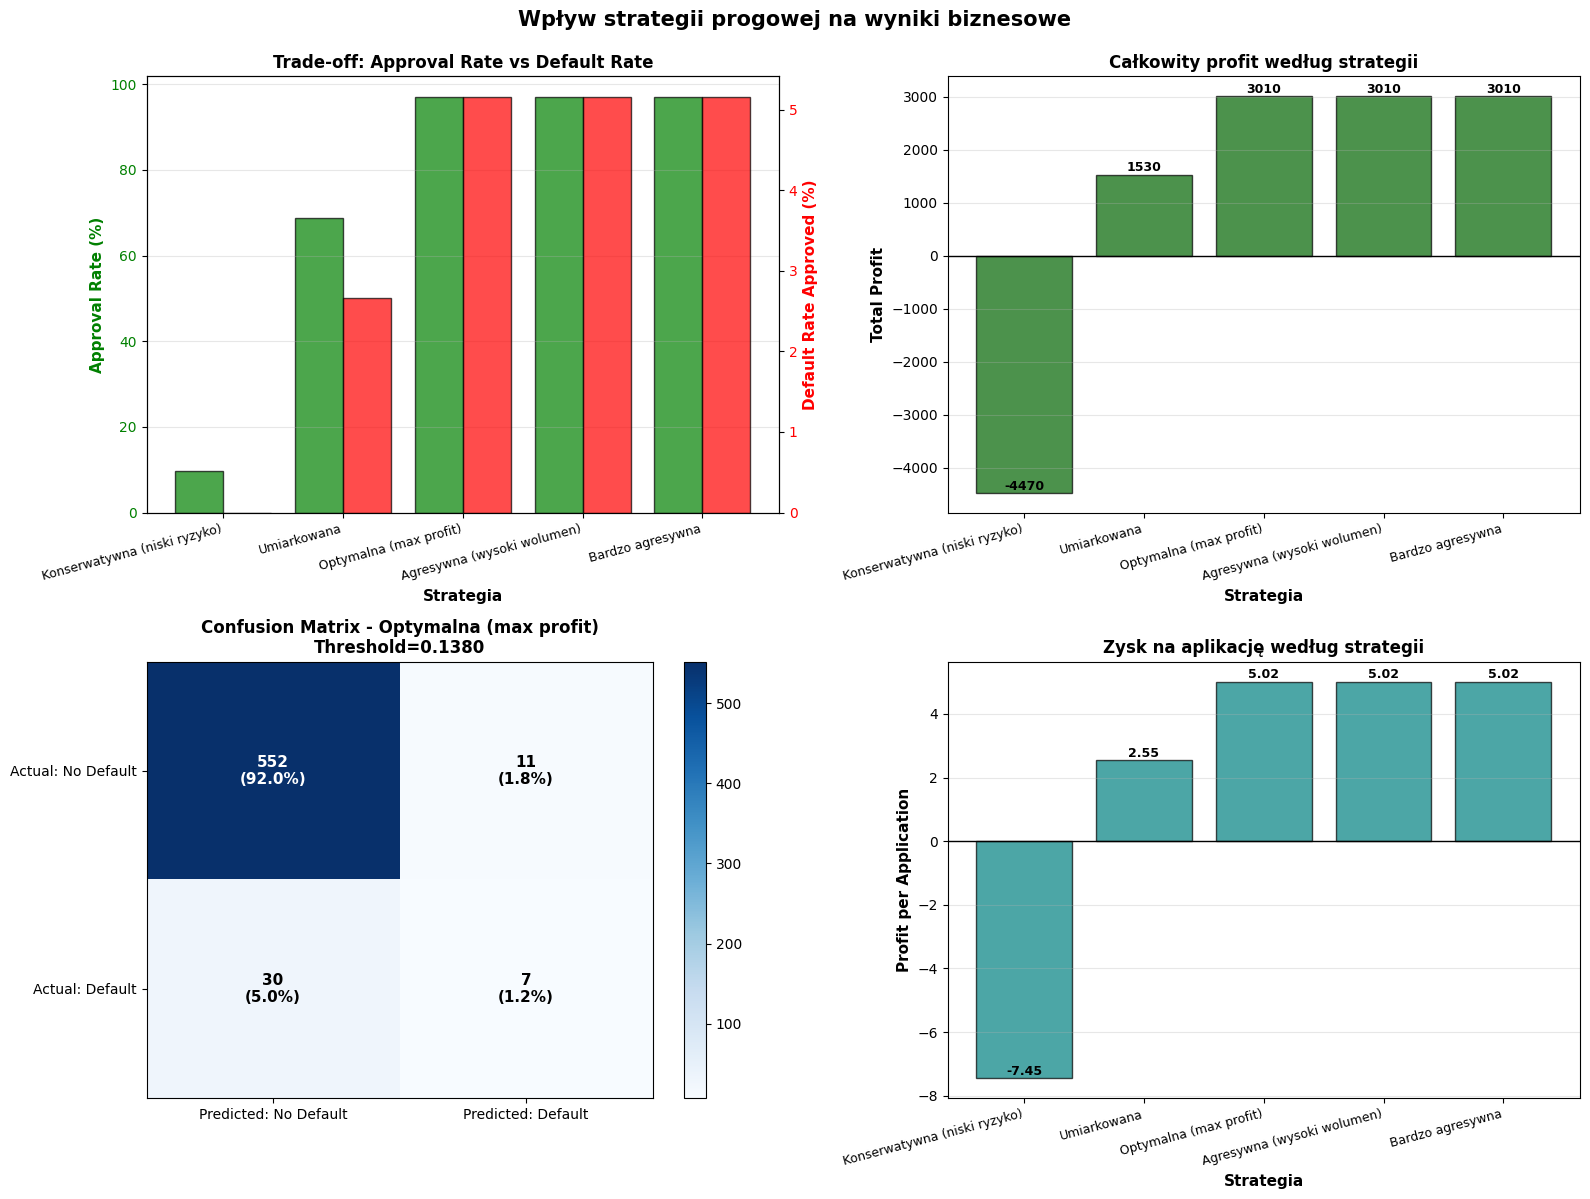

Wykres zapisany: business_impact_threshold_strategies.png


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

strategies = business_df['Strategy'].values
x_pos = np.arange(len(strategies))

ax1 = axes[0, 0]
ax1_twin = ax1.twinx()
bars1 = ax1.bar(x_pos - 0.2, business_df['Approval_Rate'], 0.4, label='Approval Rate', 
                color='green', alpha=0.7, edgecolor='black')
bars2 = ax1_twin.bar(x_pos + 0.2, business_df['DR_Approved'], 0.4, label='DR Approved', 
                     color='red', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Strategia', fontsize=11, fontweight='bold')
ax1.set_ylabel('Approval Rate (%)', fontsize=11, fontweight='bold', color='green')
ax1_twin.set_ylabel('Default Rate Approved (%)', fontsize=11, fontweight='bold', color='red')
ax1.set_title('Trade-off: Approval Rate vs Default Rate', fontsize=12, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(strategies, rotation=15, ha='right', fontsize=9)
ax1.tick_params(axis='y', labelcolor='green')
ax1_twin.tick_params(axis='y', labelcolor='red')
ax1.grid(alpha=0.3, axis='y')

axes[0, 1].bar(x_pos, business_df['Total_Profit'], color='darkgreen', alpha=0.7, edgecolor='black')
axes[0, 1].axhline(0, color='black', linestyle='-', linewidth=1)
axes[0, 1].set_xlabel('Strategia', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Total Profit', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Całkowity profit według strategii', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(strategies, rotation=15, ha='right', fontsize=9)
axes[0, 1].grid(alpha=0.3, axis='y')
for i, profit in enumerate(business_df['Total_Profit']):
    axes[0, 1].text(i, profit + max(business_df['Total_Profit'])*0.02, f'{profit:.0f}', 
                    ha='center', fontsize=9, fontweight='bold')

optimal_strategy_idx = business_df['Total_Profit'].idxmax()
optimal_cm = business_df.iloc[optimal_strategy_idx]
cm_matrix = np.array([[optimal_cm['TN'], optimal_cm['FP']], 
                      [optimal_cm['FN'], optimal_cm['TP']]])
im = axes[1, 0].imshow(cm_matrix, cmap='Blues', aspect='auto')
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_yticks([0, 1])
axes[1, 0].set_xticklabels(['Predicted: No Default', 'Predicted: Default'], fontsize=10)
axes[1, 0].set_yticklabels(['Actual: No Default', 'Actual: Default'], fontsize=10)
axes[1, 0].set_title(f"Confusion Matrix - {optimal_cm['Strategy']}\nThreshold={optimal_cm['Threshold']:.4f}", 
                     fontsize=12, fontweight='bold')
for i in range(2):
    for j in range(2):
        text = axes[1, 0].text(j, i, f'{int(cm_matrix[i, j])}\n({cm_matrix[i, j]/cm_matrix.sum()*100:.1f}%)',
                              ha="center", va="center", color="white" if cm_matrix[i, j] > cm_matrix.max()/2 else "black",
                              fontsize=11, fontweight='bold')
plt.colorbar(im, ax=axes[1, 0])

axes[1, 1].bar(x_pos, business_df['Profit_Per_App'], color='teal', alpha=0.7, edgecolor='black')
axes[1, 1].axhline(0, color='black', linestyle='-', linewidth=1)
axes[1, 1].set_xlabel('Strategia', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Profit per Application', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Zysk na aplikację według strategii', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(strategies, rotation=15, ha='right', fontsize=9)
axes[1, 1].grid(alpha=0.3, axis='y')
for i, profit in enumerate(business_df['Profit_Per_App']):
    axes[1, 1].text(i, profit + max(business_df['Profit_Per_App'])*0.02, f'{profit:.2f}', 
                    ha='center', fontsize=9, fontweight='bold')

plt.suptitle('Wpływ strategii progowej na wyniki biznesowe', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("Wykres zapisany: business_impact_threshold_strategies.png")
print("="*80)

In [95]:
print("="*80)
print("TABELA DECYZYJNA - REKOMENDACJE AKCJI")
print("="*80)

decision_table = []

for _, row in rating_df.iterrows():
    rating = row['Rating']
    avg_pd = row['Avg_PD']
    actual_dr = row['Actual_DR']
    
    if rating in ['A', 'B']:
        action = 'AUTO-ACCEPT'
        terms = 'Standard terms'
        monitoring = 'Standard'
    elif rating in ['C', 'D']:
        action = 'ACCEPT'
        terms = 'Standard terms, możliwe wyższe oprocentowanie'
        monitoring = 'Enhanced'
    elif rating == 'E':
        action = 'MANUAL REVIEW'
        terms = 'Higher interest rate lub collateral'
        monitoring = 'Enhanced'
    elif rating == 'F':
        action = 'REJECT lub MANUAL'
        terms = 'Very high interest + collateral required'
        monitoring = 'Intensive'
    else:
        action = 'AUTO-REJECT'
        terms = 'N/A'
        monitoring = 'N/A'
    
    decision_table.append({
        'Rating': rating,
        'Avg_PD': f'{avg_pd*100:.2f}%',
        'Actual_DR': f'{actual_dr*100:.2f}%',
        'Action': action,
        'Terms': terms,
        'Monitoring': monitoring
    })

decision_df = pd.DataFrame(decision_table)
print(decision_df.to_string(index=False))

print("\n\nLegenda:")
print("  AUTO-ACCEPT: Automatyczna akceptacja bez przeglądu manualnego")
print("  ACCEPT: Akceptacja z możliwością dodatkowych warunków")
print("  MANUAL REVIEW: Wymagany przegląd manualny przez analityka")
print("  REJECT: Odrzucenie z możliwością manual review w wyjątkowych przypadkach")
print("  AUTO-REJECT: Automatyczne odrzucenie")
print("="*80)

TABELA DECYZYJNA - REKOMENDACJE AKCJI
Rating Avg_PD Actual_DR            Action                                         Terms Monitoring
     A  3.33%     3.33%       AUTO-ACCEPT                                Standard terms   Standard
     B  2.62%    50.00%       AUTO-ACCEPT                                Standard terms   Standard
     D  2.74%     2.30%            ACCEPT Standard terms, możliwe wyższe oprocentowanie   Enhanced
     E  3.68%     3.68%     MANUAL REVIEW           Higher interest rate lub collateral   Enhanced
     F  8.64%     8.64% REJECT lub MANUAL      Very high interest + collateral required  Intensive
     G 16.35%    16.35%       AUTO-REJECT                                           N/A        N/A


Legenda:
  AUTO-ACCEPT: Automatyczna akceptacja bez przeglądu manualnego
  ACCEPT: Akceptacja z możliwością dodatkowych warunków
  MANUAL REVIEW: Wymagany przegląd manualny przez analityka
  REJECT: Odrzucenie z możliwością manual review w wyjątkowych przypadkach
  A

In [ ]:
print("="*80)
print("PODSUMOWANIE - PROGI DECYZJI I RATINGI")
print("="*80)

print(f"\nOptymalizacja progów:")
print(f"  Prog maksymalizujący profit: {optimal_threshold:.4f}")
print(f"  Maksymalny profit: {optimal_profit:.2f}")
print(f"  ROC AUC: {roc_auc:.4f}")
print(f"  PR AUC: {pr_auc:.4f}")

print(f"\nKlasy ratingowe:")
print(f"  Liczba klas: {n_rating_classes}")
print(f"  Zakres PD: [{pd_boundaries[0]:.6f}, {pd_boundaries[-1]:.6f}]")
print(f"  Klasa najlepsza (A): DR = {rating_df.iloc[0]['Actual_DR']*100:.3f}%")
print(f"  Klasa najgorsza (G): DR = {rating_df.iloc[-1]['Actual_DR']*100:.2f}%")
print(f"  Monotoniczność: {'Zachowana' if all(rating_df['Actual_DR'].diff()[1:] > 0) else 'Naruszona'}")

print(f"\nRekomendowana strategia biznesowa:")
best_strategy = business_df.iloc[business_df['Total_Profit'].idxmax()]
print(f"  Strategia: {best_strategy['Strategy']}")
print(f"  Prog: {best_strategy['Threshold']:.4f}")
print(f"  Approval Rate: {best_strategy['Approval_Rate']:.2f}%")
print(f"  DR wśród zaakceptowanych: {best_strategy['DR_Approved']:.2f}%")
print(f"  Profit per aplikacja: {best_strategy['Profit_Per_App']:.2f}")
print(f"  Total Profit: {best_strategy['Total_Profit']:.2f}")


PODSUMOWANIE - PROGI DECYZJI I RATINGI

Optymalizacja progów:
  Prog maksymalizujący profit: 0.1380
  Maksymalny profit: 3010.00
  ROC AUC: 0.7565
  PR AUC: 0.2801

Klasy ratingowe:
  Liczba klas: 7
  Zakres PD: [0.000000, 1.000000]
  Klasa najlepsza (A): DR = 3.333%
  Klasa najgorsza (G): DR = 16.35%
  Monotoniczność: Naruszona

Rekomendowana strategia biznesowa:
  Strategia: Optymalna (max profit)
  Prog: 0.1380
  Approval Rate: 97.00%
  DR wśród zaakceptowanych: 5.15%
  Profit per aplikacja: 5.02
  Total Profit: 3010.00

Zapisane pliki:
  threshold_analysis_curves.png
  rating_classes_analysis.png
  business_impact_threshold_strategies.png
